# NATIONAL HEALTH SERVICE (NHS)
## Diagnostic Analysis using Python
### Dr. Karin Agius Ferrante, February 24th, 2025

## Content
1. Approach
2. Data Import & Validation
3. Data Cleaning & Transformation
4. Exploratory Data Analysis
5. Recommendations

## 1. Approach
The National Health Services (NHS) is the publicly funded healthcare system in England. Its objective is to improve quality, clinical outcomes, and patient experience. <br>
To match its increasing population capacity the NHS must expand its infrastructure and resources. However, ineffective resource allocation and a high number of missed appointments reduces efficiency and adversely affects patient experience. <br>
Internal and external data will be used to answer business questions concerning the utilisation of services, missed appointments, and the potential value of using external data sources such as X (formerly Twitter). <br>
The analysis will explore the available data to offer suggestions and recommendations based on data observations.

### Main Business Questions

**1. Has there been adequate staff and capacity in the networks?** <br>
**2. What was the actual utilisation of resources?**

### Sub-questions:

To understand the current capacity and utilisation, the following questions should be answered?
- How is the data quality rated?
- How does the number of appointments overall and by different categories develop over time?
- How does the number of patients and GPs develop over time? What is the number of appointments per patient per month?
- What influences the number of appointments not attended?
- Are there any trends in time between booking an appointment? What type of appointments are booked further in advance and with whom?
- Are the any seasonal trends on the number of appointments?
- Does the utilisation rate allow conclusions whether staff levels are adequate?
- Can social media, such as X, can support the NHS in its activities?

### Data Sources


**4 datasets were provided:** <br/>
Data collected over 30 month period.
- actual_duration: appointment data on the duration of appointments by date and sub-ICB (Date range: 2021-12-01 to 2022-06-30)
- appointments_regional: appointment data on status, healthcare professional, mode and time between booking and appointment by month and ICB (Date range: 2020-01 to 2022-06)
- national_categories: appointment data on service setting, context type and national category by date and sub-ICB (Date range: 2021-08-01 to 2022-06-30)
- tweets: extract of tweets, retweets and favourites from X (formerly Twitter) regarding healthcare

**Additional data included to complete the analysis:**
- Registered Patients: monthly data on the number of patients by sub-ICB and postocde from NHS source (Date range: 2021-08 to 2022-06)
- GP Data: Monthly data on GPs ad Full Time Employees (FTE) split into fully qualified GPs and GPs in training (Date range: 2016-12 to 2024-12)
- ICB Code Mapping: Code Hierachy from region to ICB and sub-ICB
- Workdays: Monthly number of workdays per month extracted from NHS data (Date range: 2020-01 to 2022-06)

# 

## 2. Data Import & Validation

- Import libraries, define functions for data analysis and chart plotting.
- Import the data sources and perform basic exploratory analysis including obtaining descriptive statistics.
- Document initial observations and findings.

### 2.1. Import Libraries & define functions

In [16]:
# Import the necessary libraries.
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import *
import seaborn as sns
from pandas.api.types import CategoricalDtype
import re
from IPython.display import Markdown
from statsmodels.tsa.seasonal import seasonal_decompose

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Maximum column width to display
pd.options.display.max_colwidth = 200

In [17]:
# Define function to validate imported data files.
def validate_data(df):
    # Check metadata.
    dataframe_info = df.info()
    print('Metadata:')
    print(dataframe_info)
    
    # Check for missing values.
    missing_values_count = df.isnull().sum()
    print('\nNumber of missing values:')
    print(missing_values_count)

    # Check for unique values
    unique_counts = df.nunique()
    print('\nUnique values per column:')
    print(unique_counts)
    
    # Check for duplicates
    duplicate_count = df.duplicated().sum()
    print('\nNumber of duplicate rows:')
    print(duplicate_count)
    
    # Summary statistics
    summary_stats = df.describe()
    print('\nSummary statistics:')
    print(summary_stats)

In [18]:
# Define function to determine the total number of appointments per category
# and their percentage share.
def sum_data(df, category_column):
    
    # Group by the specified category column and sum appointments.
    df_sum = df.groupby(category_column)['count_of_appointments'].sum(). \
    sort_values(ascending = False)

    # Calculate the total sum of appointments.
    total_sum = df_sum.sum()

    # Calculate the percentage for each service setting.
    percentage = ((df_sum / total_sum) * 100).round(1)

    # Combine the results into a new DataFrame.
    result = pd.concat([df_sum, percentage], axis=1, \
                       keys=['total_appointments', 'percentage_share'])

    return result

In [19]:
# Define function to clean labels in charts.
def clean_label(label):
    return label.replace('_', ' ').title()

In [20]:
# Define function to plot a lineplot with a trendline.
def generate_lineplot(df, x_axis, y_axis, title, ylim=None, save_path=None, \
                      rotate_xticks=False):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [21]:
# Define function to plot a lineplot with a trendline.
def generate_lineplot_with_trendline(df, x_axis, y_axis, title, date=None, ylim=None, \
                                     rotate_xticks=False, save_path=None, errorbar=None):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Calculate trendline.
    x = np.arange(len(df))
    y = df[y_axis].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Plot the trendline.
    plt.plot(df[x_axis], p(x), linestyle='--', color='r', label='Trendline')

    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [22]:
# Define function to plot a lineplot with various categories and trendline.
def generate_multi_lineplot(df, x_axis, y_axis, hue, title, date=None, ylim=None, \
                            save_path=None, errorbar=None, **kwargs):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, ci=None, **kwargs)

    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')
    
    # Rotate labels on the x-axis.
    plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [23]:
# Define function to plot a lineplot with various categories and trendline.
def generate_multi_lineplot_with_trendline(df, x_axis, y_axis, hue, title, \
                                           save_path=None, date=None, ylim=None, **kwargs):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, ci=None, **kwargs)
   
    # Add trendlines for each role
    for variable in df[hue].unique():
        subset = df[df[hue] == variable]
    
        # Calculate trendline.
        x_numeric= np.arange(len(subset[x_axis]))
        y = subset[y_axis].values
        z = np.polyfit(x_numeric, y, 1)
        p = np.poly1d(z)

        # Plot the trendline.
        plt.plot(subset[x_axis], p(x_numeric), linestyle='--', label=f'{variable} Trendline')

    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')
    
    # Rotate labels on the x-axis.
    plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [24]:
# Define function to plot a barplot.
def generate_barplot(df, x_axis, y_axis, title, save_path=None, rotate_xticks=False):
   
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Plot the barplot.
    sns.barplot(data=df, x=x_axis, y=y_axis, color='#0057ab')

    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

### 2.2. Import & Validate Data

**2.2.1. Dataset actual_duration.csv**

In [28]:
# Import the actual_duration.csv data set as ad.
ad = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/actual_duration.csv')

# View the DataFrame.
ad.head()

sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   
2                   00L                 E38000130   
3                   00L                 E38000130   
4                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
2  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
3  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
4  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date         actual_duration  count_of_appointments  
0        01-Dec-21           31-60 Minutes                    364  
1        01-Dec-21           21-30 Minutes                    619  
2        01-Dec-21            6-10 Minutes                   1698  
3        01-Dec-21  Unknown / Data Quality                   1277  
4        01-Dec-21           16-20 Minutes                    730

In [29]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(ad)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB
Metadata:
None

Number of missing values:
sub_icb_location_code        0
sub_icb_location_ons_code    0
sub_icb_location_name        0
icb_ons_code                 0
region_ons_code              0
appointment_date             0
actual_duration              0
count_of_appointments

> **Observations** <br>
> There are no null values or duplicates. The ICB code values are consistent. <br>
> Date format will be adjusted in Section 3 on "Data Cleaning & Transformation". <br>
> A column for appointment month will be added.

**2.2.2. Import Dataset appointments_regional.csv**

In [33]:
# Import the appointments_regional.csv data set as ar.
ar = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/appointments_regional.csv')

# View the DataFrame.
ar.head()

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  
0                             1 Day                   8107  
1                    15  to 21 Days                   6791  
2                       2 to 7 Days                  20686  
3                    22  to 28 Days                   4268  
4                     8  to 14 Days                  11971

In [34]:
# Rename and shorten column title 'time_between_book_and_appointment'.
ar = ar.rename(columns={'time_between_book_and_appointment': 'book_time'})

# View the DataFrame.
ar.head()

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   

        book_time  count_of_appointments  
0           1 Day                   8107  
1  15  to 21 Days                   6791  
2     2 to 7 Days                  20686  
3  22  to 28 Days                   4268  
4   8  to 14 Days                  11971

In [35]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(ar)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   icb_ons_code           596821 non-null  object
 1   appointment_month      596821 non-null  object
 2   appointment_status     596821 non-null  object
 3   hcp_type               596821 non-null  object
 4   appointment_mode       596821 non-null  object
 5   book_time              596821 non-null  object
 6   count_of_appointments  596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB
Metadata:
None

Number of missing values:
icb_ons_code             0
appointment_month        0
appointment_status       0
hcp_type                 0
appointment_mode         0
book_time                0
count_of_appointments    0
dtype: int64

Unique values per column:
icb_ons_code                42
appointment_month           30
appointment_status           3
hcp_typ

In [36]:
# Data validation shows 21,604 duplicates.
# review the duplicate values.
ar_duplicates = ar[ar.duplicated()]

# Print the DataFrame.
print("Duplicate Rows :")
ar_duplicates

Duplicate Rows :


icb_ons_code appointment_month appointment_status hcp_type  \
19292     E54000044           2020-01           Attended       GP   
19308     E54000044           2020-01           Attended       GP   
19374     E54000044           2020-01                DNA       GP   
19417     E54000044           2020-01                DNA  Unknown   
19419     E54000044           2020-01                DNA  Unknown   
...             ...               ...                ...      ...   
596809    E54000050           2022-06            Unknown  Unknown   
596812    E54000050           2022-06            Unknown  Unknown   
596814    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode               book_time  count_of_appointments  
19292        Home Visit  Unknown / Data Quality                      1  
19308           Unknown  Unknown / Data Quality                      2  
19374        Home Visit           8  to 14 Days                      1  
19417      Face-to-Face             2 to 7 Days                      1  
19419      Face-to-Face                Same Day                      6  
...                 ...                     ...                    ...  
596809        Telephone          15  to 21 Days                      1  
596812        Telephone       More than 28 Days                      1  
596814          Unknown                   1 Day                      2  
596817          Unknown          22  to 28 Days                      8  
596820          Unknown                Same Day                     10  

[21604 rows x 7 columns]

> **Observations** <br>
> There are no null values. The ICB code values are consistent. <br>
> The data validation shows 21,604 duplicates. As the data was previously consolidated on ICB level, the same number of appointments can be recorded at different sub-ICBs. Therefore, it cannot be assumed that records are duplicated.

**2.2.3. Import Dataset national_categories.xlsx**

In [40]:
# Import the national_categories.xlsx data set as nc.
nc = pd.read_excel('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/national_categories.xlsx')

# View the DataFrame.
nc

appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during Care Home Round   
1       Care Related Encounter                         Planned Clinics   
2       Care Related Encounter                              Home Visit   
3       Care Related Encounter              General Consultation Acute   
4       Care Related Encounter            Structured Medication Review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned Clinical Activity   
817390  Care Related Encounter                         Planned Clinics   
817391  Care Related Encounter              Planned Clinical Procedure   
817392  Care Related Encounter            General Consultation Routine   
817393  Care Related Encounter              General Consultation Acute   

        count_of_appointments appointment_month  
0                           3           2021-08  
1                           7           2021-08  
2                          79           2021-08  
3                         725           2021-08  
4                           2           2021-08  
...                       ...               ...  
817389                     12           2022-06  
817390                      4           2022-06  
817391                     92           2022-06  
817392                      4           2022-06  
817393                     19           2022-06  

[817394 rows x 8 columns]

In [41]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(nc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
Metadata:
None

Number of missing values:
appointment_date         0
icb_ons_code             0
sub_icb_location_name    0
service_setting          0
context_type             0
national_category        0
count_of_appoint

> ***Observations*** <br>
> There are no null values or duplicates. The ICB code values are consistent. <br>
> Date formats are correct, and data contains an appointment date and an appointment month for analysis.

**2.2.4. Import Datasets for registred patients**

To analyse the data per patient, NHS data on registered patients by month from August 2021 to June 2022 has been included. The 11 files are then combined into one DataFrame rp using the concat() function.

In [46]:
# Import data on registered patients from NHS monthly csv files as rp_month.
rp_202108 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2021_08.csv')
rp_202109 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2021_09.csv')
rp_202110 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2021_10.csv')
rp_202111 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2021_11.csv')
rp_202112 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2021_12.csv')
rp_202201 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2022_01.csv')
rp_202202 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2022_02.csv')
rp_202203 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2022_03.csv')
rp_202204 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2022_04.csv')
rp_202205 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2022_05.csv')
rp_202206 = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/gp-reg-pat-prac-all_2022_06.csv')

In [47]:
# Concatenate the monthly files into one DataFrame rp.
rp = pd.concat([rp_202108, rp_202109, rp_202110, rp_202111, rp_202112, \
                rp_202201, rp_202202, rp_202203, rp_202204, rp_202205, rp_202206], axis=0)

# View the DataFrame.
rp

publication extract_date type ccg_code ons_ccg_code    code  \
0     GP_PRAC_PAT_LIST    01-Aug-21   GP      00L    E38000130  A84002   
1     GP_PRAC_PAT_LIST    01-Aug-21   GP      00L    E38000130  A84005   
2     GP_PRAC_PAT_LIST    01-Aug-21   GP      00L    E38000130  A84006   
3     GP_PRAC_PAT_LIST    01-Aug-21   GP      00L    E38000130  A84007   
4     GP_PRAC_PAT_LIST    01-Aug-21   GP      00L    E38000130  A84008   
...                ...          ...  ...      ...          ...     ...   
6490  GP_PRAC_PAT_LIST    01-Jun-22   GP    X2C4Y    E38000254  B85660   
6491  GP_PRAC_PAT_LIST    01-Jun-22   GP    X2C4Y    E38000254  Y00081   
6492  GP_PRAC_PAT_LIST    01-Jun-22   GP    X2C4Y    E38000254  Y04266   
6493  GP_PRAC_PAT_LIST    01-Jun-22   GP    X2C4Y    E38000254  Y06659   
6494  GP_PRAC_PAT_LIST    01-Jun-22   GP    X2C4Y    E38000254  Y07275   

      postcode  sex  age  number_of_patients  
0     NE65 7UW  ALL  ALL                5969  
1     NE22 6JX  ALL  ALL               12111  
2     NE66 2NL  ALL  ALL               18827  
3     NE20 9SD  ALL  ALL               10362  
4     NE70 7ER  ALL  ALL                4490  
...        ...  ...  ...                 ...  
6490   HD5 8BE  ALL  ALL                6204  
6491   HD1 9RX  ALL  ALL                  25  
6492   HD4 5RX  ALL  ALL                4036  
6493   HD3 3XA  ALL  ALL                3367  
6494  WF17 5QT  ALL  ALL                3114  

[71856 rows x 10 columns]

In [48]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(rp)

<class 'pandas.core.frame.DataFrame'>
Index: 71856 entries, 0 to 6494
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   publication         71856 non-null  object
 1   extract_date        71856 non-null  object
 2   type                71856 non-null  object
 3   ccg_code            71856 non-null  object
 4   ons_ccg_code        71856 non-null  object
 5   code                71856 non-null  object
 6   postcode            71856 non-null  object
 7   sex                 71856 non-null  object
 8   age                 71856 non-null  object
 9   number_of_patients  71856 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 6.0+ MB
Metadata:
None

Number of missing values:
publication           0
extract_date          0
type                  0
ccg_code              0
ons_ccg_code          0
code                  0
postcode              0
sex                   0
age                   0
number_of_pat

> ***Observations*** <br>
> There are no null values or duplicates. <br>
> The ons_ccg_code values (equivalent of sub-ICB locations) is consistent. <br>
> Date format will be adjusted in Section 3 on "Data Cleaning & Transformation". <br>
> A column for appointment month will be added.

**2.2.5. Import Datasets for General Practitioners (GP)**

To compare the other datasets to the number of GPs, NHS data on GPs (fully qualified and in training) by month from Decemner 2016 to December 2023 has been included by region and ICB.

In [53]:
# Import GP data as gp.
gp = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/icb_gp_data.csv')

# View the DataFrame.
gp.head()

sub_icb_location_ons_code staff_role     fte  patients  patients_per_gp  \
0                 E38000244    All GPs   964.7   1960455           2032.2   
1                 E38000255    All GPs  1121.8   2179602           1943.0   
2                 E38000240    All GPs   879.3   1616912           1838.9   
3                 E38000256    All GPs  1218.9   2442375           2003.7   
4                 E38000245    All GPs   954.7   1665184           1744.1   

         date  
0  28/06/2018  
1  28/06/2018  
2  28/06/2018  
3  28/06/2018  
4  28/06/2018

In [54]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(gp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14310 entries, 0 to 14309
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sub_icb_location_ons_code  14310 non-null  object 
 1   staff_role                 14310 non-null  object 
 2   fte                        14310 non-null  float64
 3   patients                   14310 non-null  int64  
 4   patients_per_gp            14310 non-null  float64
 5   date                       14310 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 670.9+ KB
Metadata:
None

Number of missing values:
sub_icb_location_ons_code    0
staff_role                   0
fte                          0
patients                     0
patients_per_gp              0
date                         0
dtype: int64

Unique values per column:
sub_icb_location_ons_code      106
staff_role                       3
fte                           5184
patient

> ***Oservations*** <br>
> There are no null values or duplicates. The number of sub-ICB locations is consistent. <br>
> Date format will be adjusted in Section 3 on "Data Cleaning & Transformation". <br>
> A column for appointment month will be added.

**2.2.6. Import Datasets on ICB Code Mapping (cm)**

To be able to merge datasets, NHS code mapping data was extracted from the actual_duration dataset and amended to match previous and current codes.

In [59]:
# Import Code Mapping file as cm. This file matches regions, ICBs and sub-ICBs.
cm = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/icb_code_mapping.csv')

# View the DataFrame.
cm.head()

sub_icb_location_ons_code_NEW sub_icb_location_ons_code  \
0                     E38000256                 E38000256   
1                     E38000240                 E38000240   
2                     E38000255                 E38000255   
3                     E38000244                 E38000244   
4                     E38000245                 E38000245   

                sub_icb_location_name region_ons_code region_ons_name  \
0   NHS North West London ICB - W2U3Z       E40000003          London   
1  NHS North Central London ICB - 93C       E40000003          London   
2   NHS North East London ICB - A3A8R       E40000003          London   
3     NHS South East London ICB - 72Q       E40000003          London   
4     NHS South West London ICB - 36L       E40000003          London   

  icb_ons_code                                    icb_ons_name  
0    E54000027     NHS North West London Integrated Care Board  
1    E54000028  NHS North Central London Integrated Care Board  
2    E54000029     NHS North East London Integrated Care Board  
3    E54000030     NHS South East London Integrated Care Board  
4    E54000031     NHS South West London Integrated Care Board

In [60]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(cm)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   sub_icb_location_ons_code_NEW  106 non-null    object
 1   sub_icb_location_ons_code      106 non-null    object
 2   sub_icb_location_name          106 non-null    object
 3   region_ons_code                106 non-null    object
 4   region_ons_name                106 non-null    object
 5   icb_ons_code                   106 non-null    object
 6   icb_ons_name                   106 non-null    object
dtypes: object(7)
memory usage: 5.9+ KB
Metadata:
None

Number of missing values:
sub_icb_location_ons_code_NEW    0
sub_icb_location_ons_code        0
sub_icb_location_name            0
region_ons_code                  0
region_ons_name                  0
icb_ons_code                     0
icb_ons_name                     0
dtype: int64

Unique values per column

> ***Observations*** <br>
> There are no null values or duplicates. The number of ICB codes is consistent.

**2.2.7. Import Datasets on Workdays (wd)**

To calculate workdays and utilisation accurately, the number of workdays per month were extracted from NHS data.

In [65]:
# Import workdays file as wd. # This file shows NHS data on the number of workdays per month.
wd = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/workdays.csv')

# View the DataFrame.
wd.head()

appointment_month  number_of_workdays
0           2020-01                  22
1           2020-02                  20
2           2020-03                  22
3           2020-04                  20
4           2020-05                  19

In [66]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(wd)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   appointment_month   30 non-null     object
 1   number_of_workdays  30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 612.0+ bytes
Metadata:
None

Number of missing values:
appointment_month     0
number_of_workdays    0
dtype: int64

Unique values per column:
appointment_month     30
number_of_workdays     5
dtype: int64

Number of duplicate rows:
0

Summary statistics:
       number_of_workdays
count           30.000000
mean            21.000000
std              1.203443
min             19.000000
25%             20.000000
50%             21.000000
75%             22.000000
max             23.000000


> ***Observations*** <br>
> There are no null values or duplicates. The number of sub-ICB locations is consistent. <br>
> The number of workdays and months are consistent for the time period.

**2.2.8. Import Datasets on Tweets from X (formerly Twitter)**

In [70]:
# Import tweets.csv file as tweets.
tweets = pd.read_csv('/Users/kaferrante/Documents/Python/Course2_Assignment_NHS/tweets.csv')

# View the DataFrame.
tweets.head()

tweet_id  \
0  1567629223795527681   
1  1567582846612553728   
2  1567582787070304256   
3  1567582767625428992   
4  1567582720460570625   

                                                                                                                                                                                           tweet_full_text  \
0  As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...   
1                                                              RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed.  We're #hiring for…   
2                                                           RT @OntarioGreens: $10 billion can go a long way to fixing our broken #Healthcare system.\n\nYet Doug Ford would rather spend it ALL on a hig…   
3                                                             RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…   
4  ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #di...   

                                                                                                                                                                                            tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer...   
2  {'hashtags': [{'text': 'Healthcare', 'indices': [70, 81]}], 'symbols': [], 'user_mentions': [{'screen_name': 'OntarioGreens', 'name': 'Green Party of Ontario', 'id': 37115912, 'id_str': '37115912'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices':...   
4  {'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices'...   

                                                              tweet_entities_hashtags  \
0                                                                         #Healthcare   
1                                                             #PremiseHealth, #hiring   
2                                                                         #Healthcare   
3                                                                                #NEW   
4  #blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare   

                                         tweet_metadata  tweet_retweet_count  \
0  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   
1  {'iso_language_code': 'en', 'result_type': 'recent'}                    2   
2  {'iso_language_code': 'en', 'result_type': 'recent'}                   39   
3  {'iso_language_code': 'en', 'result_type': 'recent'}                    5   
4  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en  
2                     0            False            False         en  
3                     0            False            False         en  
4           

In [71]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(tweets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          1174 non-null   bool  
 8   tweet_retweeted          1174 non-null   bool  
 9   tweet_lang               1174 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 75.8+ KB
Metadata:
None

Number of missing values:
tweet_id                     0
tweet_full_text              0
tweet_entities               0
tweet_entities_hashtags    167
tweet_metadata               0


> ***Observations*** <br>
> There are only null values in the tweet_entities_hashtags colum. <br>
> This suggests no hashtag was used, which will not impact the analysis. <br>
> The validation shows no duplicates.

#

## 3. Data Cleaning & Transformation

- Rewview data quality and unmapped data.
- Transform and merge data as necessary for further analysis.
- Review and adjust date formats as required.

### 3.1. Data Quality

Rewview the data quality of the DataFrames national_categories (nc), appointments_regional (ar) and actual_duration (ad) to analyse the share of entries that is unknown or inconsistent.

In [78]:
# Check for the share of "Unmapped" or "Inconsistent Mapping" in national_categories (nc).
nc_data_check = sum_data(nc, 'national_category')

# View the reuslt.
nc_data_check

total_appointments  \
national_category                                                                         
General Consultation Routine                                                   97271522   
General Consultation Acute                                                     53691150   
Clinical Triage                                                                41546964   
Planned Clinics                                                                28019748   
Inconsistent Mapping                                                           27890802   
Planned Clinical Procedure                                                     25702694   
Unmapped                                                                       11080810   
Unplanned Clinical Activity                                                     3055794   
Home Visit                                                                      2144452   
Structured Medication Review                                                    1858379   
Service provided by organisation external to the practice                        852133   
Patient contact during Care Home Round                                           810330   
Care Home Visit                                                                  628279   
Social Prescribing Service                                                       475828   
Walk-in                                                                          412438   
Care Home Needs Assessment & Personalised Care and Support Planning              405904   
Non-contractual chargeable work                                                  138911   
Group Consultation and Group Education                                            60632   

                                                                     percentage_share  
national_category                                                                      
General Consultation Routine                                                     32.9  
General Consultation Acute                                                       18.1  
Clinical Triage                                                                  14.0  
Planned Clinics                                                                   9.5  
Inconsistent Mapping                                                              9.4  
Planned Clinical Procedure                                                        8.7  
Unmapped                                                                          3.7  
Unplanned Clinical Activity                                                       1.0  
Home Visit                                                                        0.7  
Structured Medication Review                                                      0.6  
Service provided by organisation external to the practice                         0.3  
Patient contact during Care Home Round                                            0.3  
Care Home Visit                                                                   0.2  
Social Prescribing Service                                                        0.2  
Walk-in                                                                           0.1  
Care Home Needs Assessment & Personalised Care and Support Planning               0.1  
Non-contractual chargeable work                                                   0.0  
Group Consultation and Group Education                                            0.0

In [79]:
# Check for the share of "Unknown / Data Quality" in actual_duration (ad).
ad_data_check = sum_data(ad, 'actual_duration')

# View the result.
ad_data_check

total_appointments  percentage_share
actual_duration                                             
Unknown / Data Quality            40284086              24.0
6-10 Minutes                      33800815              20.1
1-5 Minutes                       28600865              17.0
11-15 Minutes                     25160882              15.0
16-20 Minutes                     16004247               9.5
21-30 Minutes                     15026365               8.9
31-60 Minutes                      9103432               5.4

In [80]:
# Check for the share of "unknown" in column hcp_type in appointments_regional (ar).
ar_data_check = sum_data(ar, 'hcp_type')

# View the results.
ar_data_check

total_appointments  percentage_share
hcp_type                                                  
GP                             379650140              51.1
Other Practice staff           339650535              45.7
Unknown                         23503850               3.2

**Note**: in appoinments_regional (ar) there are likely to be more missing data in appointment_mode and time_between_book_and_appointment.

In [82]:
# Create a DataFrame to show the share of unknown/ inconsistent entries in the three DataFrames.
data_quality = {
    'data': ['National Categories', 'Appointments Regional', 'Actual Duration'],
    'share_unknown': [13.1, 3.2, 24.0]}

# View the DataFrame.
data_quality    

{'data': ['National Categories', 'Appointments Regional', 'Actual Duration'],
 'share_unknown': [13.1, 3.2, 24.0]}

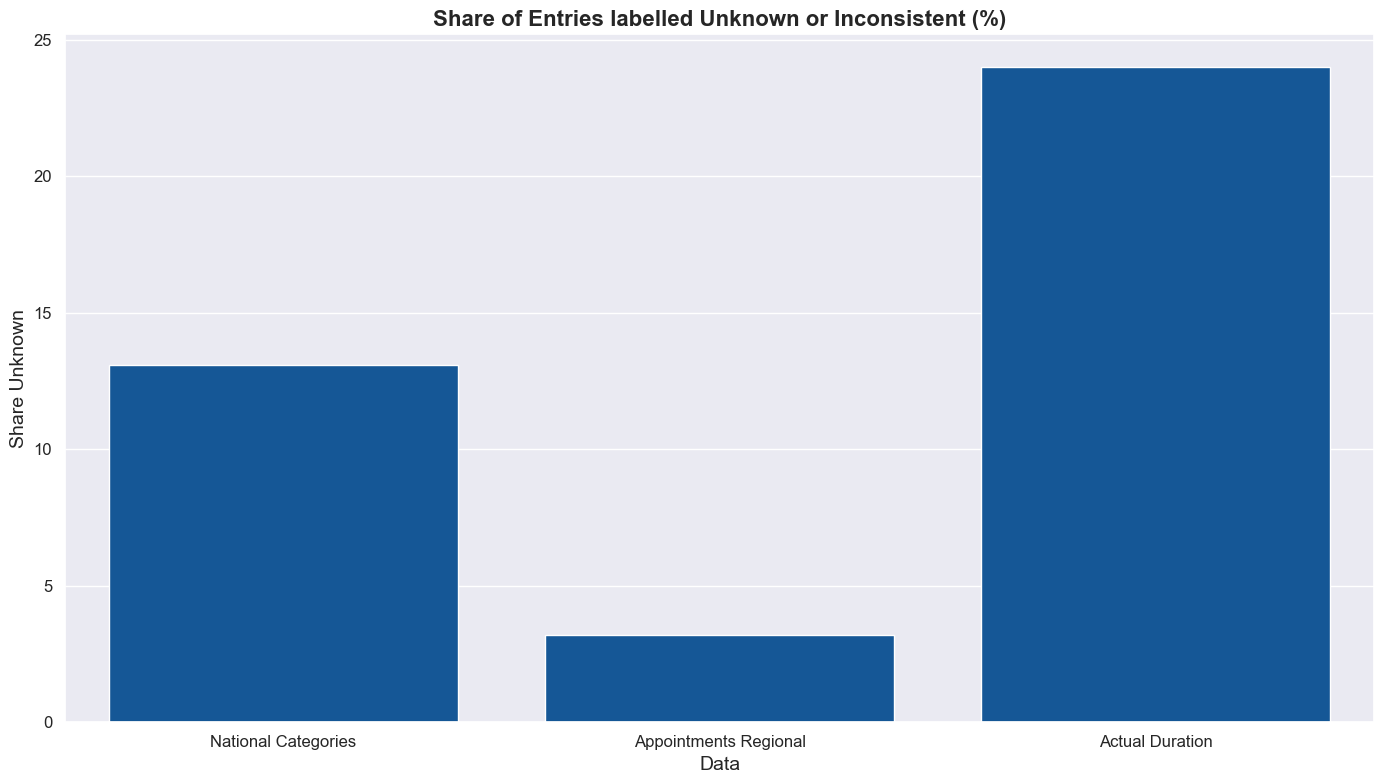

In [83]:
# Create a barplot to the data.
generate_barplot(data_quality, x_axis='data', y_axis='share_unknown', \
                 title='Share of Entries labelled Unknown or Inconsistent (%)', \
                 save_path='fig_share_entries_unknown')

> ***Observations*** <br>
>There are variations in completeness & quality:
> - different practices fill in their records in different ways
> - staff manually classifies the data 
> - different IT system suppliers

### 3.2. Individual Transformations

**3.2.1. Merge data set for registered patients to include all ICB codes and names**

To be able to combine registered_patient (rp) with other datasets, the rp must be merged with code_mapping (cm) file to match the NHS ICB und sub-ICB codes.

In [89]:
# Rename the ons_ccg_code column to sub_icb_location_ons_code_NEW to match other data sets.
rp = rp.rename(columns={'ons_ccg_code': 'sub_icb_location_ons_code_NEW'})

# Merge the grouped registered patient data with the code mapping file using the sub-ICB code.
rp_complete = pd.merge(rp, cm,
                           how='left', on='sub_icb_location_ons_code_NEW')

# View the DataFrame.
rp_complete.head()

publication extract_date type ccg_code sub_icb_location_ons_code_NEW  \
0  GP_PRAC_PAT_LIST    01-Aug-21   GP      00L                     E38000130   
1  GP_PRAC_PAT_LIST    01-Aug-21   GP      00L                     E38000130   
2  GP_PRAC_PAT_LIST    01-Aug-21   GP      00L                     E38000130   
3  GP_PRAC_PAT_LIST    01-Aug-21   GP      00L                     E38000130   
4  GP_PRAC_PAT_LIST    01-Aug-21   GP      00L                     E38000130   

     code  postcode  sex  age  number_of_patients sub_icb_location_ons_code  \
0  A84002  NE65 7UW  ALL  ALL                5969                 E38000130   
1  A84005  NE22 6JX  ALL  ALL               12111                 E38000130   
2  A84006  NE66 2NL  ALL  ALL               18827                 E38000130   
3  A84007  NE20 9SD  ALL  ALL               10362                 E38000130   
4  A84008  NE70 7ER  ALL  ALL                4490                 E38000130   

                        sub_icb_location_name region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L       E40000012   
1  NHS North East and North Cumbria ICB - 00L       E40000012   
2  NHS North East and North Cumbria ICB - 00L       E40000012   
3  NHS North East and North Cumbria ICB - 00L       E40000012   
4  NHS North East and North Cumbria ICB - 00L       E40000012   

            region_ons_name icb_ons_code  \
0  North East and Yorkshire    E54000050   
1  North East and Yorkshire    E54000050   
2  North East and Yorkshire    E54000050   
3  North East and Yorkshire    E54000050   
4  North East and Yorkshire    E54000050   

                                             icb_ons_name  
0  NHS North East and North Cumbria Integrated Care Board  
1  NHS North East and North Cumbria Integrated Care Board  
2  NHS North East and North Cumbria Integrated Care Board  
3  NHS North East and North Cumbria Integrated Care Board  
4  NHS North East and North Cumbria Integrated Care Board

In [90]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(rp_complete)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71856 entries, 0 to 71855
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   publication                    71856 non-null  object
 1   extract_date                   71856 non-null  object
 2   type                           71856 non-null  object
 3   ccg_code                       71856 non-null  object
 4   sub_icb_location_ons_code_NEW  71856 non-null  object
 5   code                           71856 non-null  object
 6   postcode                       71856 non-null  object
 7   sex                            71856 non-null  object
 8   age                            71856 non-null  object
 9   number_of_patients             71856 non-null  int64 
 10  sub_icb_location_ons_code      71856 non-null  object
 11  sub_icb_location_name          71856 non-null  object
 12  region_ons_code                71856 non-null  object
 13  r

> ***Observations*** <br>
> There are no null values or duplicates. The number of sub-ICB locations is consistent. <br>
> Extract_date format will be adjusted in Section 3.2. on "Data Transformation". <br>
> A column for appointment month will be added.

**3.2.2. Analyse and clean Tweets data**

Use tweets (tweets) DataFrame. <br>
Data validation showed now duplicates. Review of retweets and favorites is used to give more insights.

In [95]:
# Rewview data to show how many tweets were retweeted how often.
retweet_count = tweets['tweet_retweet_count'].value_counts()
retweet_count

tweet_retweet_count
0      526
1      215
2      114
3       70
5       35
4       27
7       18
12      16
8       15
73      14
9       13
6       12
208     12
35      10
37       6
11       6
10       5
53       5
44       4
150      4
63       4
76       3
85       3
41       3
62       3
207      3
68       3
78       2
23       2
24       2
72       2
16       2
13       1
49       1
48       1
15       1
107      1
14       1
79       1
20       1
39       1
19       1
303      1
57       1
40       1
54       1
169      1
Name: count, dtype: int64

In [96]:
# Rewview data to show how many tweets were set as favorites.
favorite_count = tweets['tweet_favorite_count'].value_counts()
favorite_count

tweet_favorite_count
0     1027
1       91
2       16
3       13
4        7
5        5
6        2
17       1
12       1
10       1
8        1
13       1
11       1
7        1
20       1
28       1
14       1
18       1
9        1
42       1
Name: count, dtype: int64

In [97]:
# Remove duplicates based on the 'ID' column, keeping only the first occurrence.
tweets_unique = tweets.drop_duplicates(subset=['tweet_full_text'], keep='first')

# View the new DataFrame.
tweets_unique.head()

tweet_id  \
0  1567629223795527681   
1  1567582846612553728   
2  1567582787070304256   
3  1567582767625428992   
4  1567582720460570625   

                                                                                                                                                                                           tweet_full_text  \
0  As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...   
1                                                              RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed.  We're #hiring for…   
2                                                           RT @OntarioGreens: $10 billion can go a long way to fixing our broken #Healthcare system.\n\nYet Doug Ford would rather spend it ALL on a hig…   
3                                                             RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…   
4  ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #di...   

                                                                                                                                                                                            tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer...   
2  {'hashtags': [{'text': 'Healthcare', 'indices': [70, 81]}], 'symbols': [], 'user_mentions': [{'screen_name': 'OntarioGreens', 'name': 'Green Party of Ontario', 'id': 37115912, 'id_str': '37115912'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices':...   
4  {'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices'...   

                                                              tweet_entities_hashtags  \
0                                                                         #Healthcare   
1                                                             #PremiseHealth, #hiring   
2                                                                         #Healthcare   
3                                                                                #NEW   
4  #blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare   

                                         tweet_metadata  tweet_retweet_count  \
0  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   
1  {'iso_language_code': 'en', 'result_type': 'recent'}                    2   
2  {'iso_language_code': 'en', 'result_type': 'recent'}                   39   
3  {'iso_language_code': 'en', 'result_type': 'recent'}                    5   
4  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en  
2                     0            False            False         en  
3                     0            False            False         en  
4           

> ***Observations*** <br>
> There are some anomalies, e.g. 12 tweets were retweeted 208 times. It is likely that only the original tweet was retweetet 208 times, not each retweet. Using the drop_duplicates() method, 213 entries were removed.

### 3.3. Date Transformation

Ensure data formats are aligned and in the correct format for analysis. <br>
For comparison, data merging and chart preparation, an appointment month column will be added to all DataFrames, if it is not already in the data set.

**3.3.1. Dates in actual_duration DataFrame (ad)**

In [103]:
# Determine the date format for 'actual_duration' (ad).
ad.appointment_date.head()

0    01-Dec-21
1    01-Dec-21
2    01-Dec-21
3    01-Dec-21
4    01-Dec-21
Name: appointment_date, dtype: object

In [104]:
# Change date format from 'object' to 'datetime64' and display in a new column.
ad['appointment_date_format'] = ad['appointment_date'].astype('datetime64[ns]')

In [105]:
# Add a new column for appointment_month.
ad['appointment_month'] = pd.to_datetime(ad.appointment_date).dt.strftime('%Y-%m')

In [106]:
# Verify new date formats.
print(ad['appointment_date_format'].dtype)
print(ad['appointment_month'].dtype)

datetime64[ns]
object


**3.3.2. Dates in national_categories DataFrame (nc)**

In [109]:
# Determine the date format for for 'appointment_date' in 'national categories' (nc).
nc.appointment_date.head()

0   2021-08-02
1   2021-08-02
2   2021-08-02
3   2021-08-02
4   2021-08-02
Name: appointment_date, dtype: datetime64[ns]

In [110]:
# Determine the date format for 'appointment_month'.
nc.appointment_month.head()

0    2021-08
1    2021-08
2    2021-08
3    2021-08
4    2021-08
Name: appointment_month, dtype: object

In [111]:
# Add a column for the weekday using 'appointment_date'.
nc['weekday'] = nc['appointment_date'].dt.day_name()

**3.3.3. Dates in appointments_regional DataFrame (ar)**

In [114]:
# Determine the date format for 'appointments_regional' (ar).
ar.appointment_month.head()

0    2020-01
1    2020-01
2    2020-01
3    2020-01
4    2020-01
Name: appointment_month, dtype: object

**3.3.4. Dates in registered_patients DataFrame (rp_complete)**

In [117]:
# Determine the date format for 'registered_patients' (rp_complete).
rp_complete.extract_date.head()

0    01-Aug-21
1    01-Aug-21
2    01-Aug-21
3    01-Aug-21
4    01-Aug-21
Name: extract_date, dtype: object

In [118]:
# Change date format from 'object' to 'datetime64' and display in a new column.
rp_complete['extract_date_format'] = rp_complete['extract_date'].astype('datetime64[ns]')

In [119]:
# Add a new column for appointment_month.
rp_complete['appointment_month'] = pd.to_datetime(rp_complete.extract_date).dt.strftime('%Y-%m')

In [120]:
# Verify new date formats.
print(rp_complete['extract_date_format'].dtype)
print(rp_complete['appointment_month'].dtype)

datetime64[ns]
object


**3.3.5. Dates in general_practitioners DataFrame (gp)**

In [123]:
# Determine the date format for 'GP_data' (gp).
gp.date.head()

0    28/06/2018
1    28/06/2018
2    28/06/2018
3    28/06/2018
4    28/06/2018
Name: date, dtype: object

In [124]:
# Change date format from 'object' to 'datetime64' and display in a new column.
gp['date_format'] = gp['date'].astype('datetime64[ns]')

In [125]:
# Add a new column for appointment_month.
gp['appointment_month'] = pd.to_datetime(gp.date_format).dt.strftime('%Y-%m')

In [126]:
# Verify new date formats.
print(gp['appointment_month'].dtype)
print(gp['date_format'].dtype)

object
datetime64[ns]


**3.3.6. Review earliest and latest date in each DataFrame and align, if needed**

In [129]:
# Determine the minimum and maximum dates in 'actual_duration' (ad).
print('The earliest date in the DataFrame actual_duration (ad) is', ad.appointment_date_format.min())
print('The latest date in the DataFrame actual_duration (ad) is', ad.appointment_date_format.max())

The earliest date in the DataFrame actual_duration (ad) is 2021-12-01 00:00:00
The latest date in the DataFrame actual_duration (ad) is 2022-06-30 00:00:00


In [130]:
# Determine the minimum and maximum dates in 'national_categories' (nc).
print('The earliest date in the DataFrame national_categories (nc) is', nc.appointment_date.min())
print('The latest date in the DataFrame national_categories (nc) is', nc.appointment_date.max())

The earliest date in the DataFrame national_categories (nc) is 2021-08-01 00:00:00
The latest date in the DataFrame national_categories (nc) is 2022-06-30 00:00:00


In [131]:
# Determine the minimum and maximum dates in appointments_regional (ar).
print('The earliest year & month in the DataFrame appointments_regional (ar) is', ar.appointment_month.min())
print('The latest year & month in the DataFrame appointments_regional (ar) is', ar.appointment_month.max())

The earliest year & month in the DataFrame appointments_regional (ar) is 2020-01
The latest year & month in the DataFrame appointments_regional (ar) is 2022-06


In [132]:
# Determine the minimum and maximum dates in registered_patients (rp_complete).
print('The earliest date in the DataFrame Registered Patients (rp_complete) is', rp_complete.extract_date_format.min())
print('The latest date in the DataFrame Registered Patients (rp_complete) is', rp_complete.extract_date_format.max())

The earliest date in the DataFrame Registered Patients (rp_complete) is 2021-08-01 00:00:00
The latest date in the DataFrame Registered Patients (rp_complete) is 2022-06-01 00:00:00


In [133]:
# Determine the minimum and maximum dates in GP data (gp).
print('The earliest date in the DataFrame GP data (gp) is', gp.date_format.min())
print('The latest date in the DataFrame GP data (gp) is', gp.date_format.max())

The earliest date in the DataFrame GP data (gp) is 2016-12-28 00:00:00
The latest date in the DataFrame GP data (gp) is 2023-12-28 00:00:00


In [134]:
# Filter GP data (gp) to only include data up to June 2022 to match the end date of the other data sets.
gp_short = gp[(gp['date_format'] > '2017-01-01') & (gp['date_format'] < '2022-06-30')]

# View the DataFrame.
gp_short

sub_icb_location_ons_code           staff_role     fte  patients  \
0                     E38000244              All GPs   964.7   1960455   
1                     E38000255              All GPs  1121.8   2179602   
2                     E38000240              All GPs   879.3   1616912   
3                     E38000256              All GPs  1218.9   2442375   
4                     E38000245              All GPs   954.7   1665184   
...                         ...                  ...     ...       ...   
10065                 E38000025  Fully qualified GPs    81.3    222801   
10066                 E38000190  Fully qualified GPs   178.1    389527   
10067                 E38000225  Fully qualified GPs   436.4    909468   
10068                 E38000232  Fully qualified GPs   317.3    651538   
10069                 E38000254  Fully qualified GPs   185.9    451326   

       patients_per_gp        date date_format appointment_month  
0               2032.2  28/06/2018  2018-06-28           2018-06  
1               1943.0  28/06/2018  2018-06-28           2018-06  
2               1838.9  28/06/2018  2018-06-28           2018-06  
3               2003.7  28/06/2018  2018-06-28           2018-06  
4               1744.1  28/06/2018  2018-06-28           2018-06  
...                ...         ...         ...               ...  
10065           2739.6  28/06/2022  2022-06-28           2022-06  
10066           2187.5  28/06/2022  2022-06-28           2022-06  
10067           2083.9  28/06/2022  2022-06-28           2022-06  
10068           2053.2  28/06/2022  2022-06-28           2022-06  
10069           2428.1  28/06/2022  2022-06-28           2022-06  

[8480 rows x 8 columns]

In [135]:
# Filter GP data (gp) to only include data from August 2021 to June 2022 to match other data sets.
gp_filtered = gp[(gp['date_format'] > '2021-08-01') & (gp['date_format'] < '2022-06-30')]

# View the DataFrame.
gp_filtered

sub_icb_location_ons_code           staff_role     fte  patients  \
1484                  E38000244              All GPs  1034.1   2036355   
1485                  E38000255              All GPs  1164.2   2319113   
1486                  E38000240              All GPs   962.1   1717248   
1487                  E38000256              All GPs  1316.3   2708064   
1488                  E38000245              All GPs   968.8   1718276   
...                         ...                  ...     ...       ...   
10065                 E38000025  Fully qualified GPs    81.3    222801   
10066                 E38000190  Fully qualified GPs   178.1    389527   
10067                 E38000225  Fully qualified GPs   436.4    909468   
10068                 E38000232  Fully qualified GPs   317.3    651538   
10069                 E38000254  Fully qualified GPs   185.9    451326   

       patients_per_gp        date date_format appointment_month  
1484            1969.2  28/08/2021  2021-08-28           2021-08  
1485            1992.0  28/08/2021  2021-08-28           2021-08  
1486            1784.8  28/08/2021  2021-08-28           2021-08  
1487            2057.4  28/08/2021  2021-08-28           2021-08  
1488            1773.6  28/08/2021  2021-08-28           2021-08  
...                ...         ...         ...               ...  
10065           2739.6  28/06/2022  2022-06-28           2022-06  
10066           2187.5  28/06/2022  2022-06-28           2022-06  
10067           2083.9  28/06/2022  2022-06-28           2022-06  
10068           2053.2  28/06/2022  2022-06-28           2022-06  
10069           2428.1  28/06/2022  2022-06-28           2022-06  

[3498 rows x 8 columns]

In [136]:
# Filter appointments_regional (ar) data set for month range 2021-08 to 2022-06 to match registered_patients.
ar_fil = ar[(ar['appointment_month'] > '2021-07') & (ar['appointment_month'] < '2022-07')]

# View the DataFrame.
ar_fil

icb_ons_code appointment_month appointment_status hcp_type  \
3652      E54000034           2021-08           Attended       GP   
3653      E54000034           2021-08           Attended       GP   
3654      E54000034           2021-08           Attended       GP   
3655      E54000034           2021-08           Attended       GP   
3656      E54000034           2021-08           Attended       GP   
...             ...               ...                ...      ...   
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode          book_time  count_of_appointments  
3652       Face-to-Face              1 Day                   6553  
3653       Face-to-Face     15  to 21 Days                   2390  
3654       Face-to-Face        2 to 7 Days                  10547  
3655       Face-to-Face     22  to 28 Days                    937  
3656       Face-to-Face      8  to 14 Days                   4961  
...                 ...                ...                    ...  
596816          Unknown        2 to 7 Days                     21  
596817          Unknown     22  to 28 Days                      8  
596818          Unknown      8  to 14 Days                     28  
596819          Unknown  More than 28 Days                     17  
596820          Unknown           Same Day                     10  

[223418 rows x 7 columns]

> ***Observations*** <br>
> Date formats were reviewed & amended, and an appointment_month column added to each data set.

#

## 4. Exploratory Data Analysis (EDA)

Analyse the data to identify potential trends in different categories and over time.

### 4.1. General Data

**4.1.1. What are the number of appointments and records by month?**

Use national_categories DataFrame (nc).

In [144]:
# Total number of appointment and records per month.
nc_by_month_rec = nc.groupby(['appointment_month'])['count_of_appointments'].agg(['sum','count'])

# View the DataFrame.
nc_by_month_rec

sum  count
appointment_month                 
2021-08            23852171  69999
2021-09            28522501  74922
2021-10            30303834  74078
2021-11            30405070  77652
2021-12            25140776  72651
2022-01            25635474  71896
2022-02            25355260  71769
2022-03            29595038  82822
2022-04            23913060  70012
2022-05            27495508  77425
2022-06            25828078  74168

In [145]:
# Determine month with the highest number of appointments.
# Group the total number of appointments by month.
nc_month = nc.groupby(['appointment_month'])['count_of_appointments'].agg('sum'). \
                reset_index()

# Determine the month with the highest number of appointments.
max_index = nc_month['count_of_appointments'].idxmax()
max_month = nc_month.loc[max_index]

# Display the result.
print("Month with the highest number of appointments:")
print(max_month)

Month with the highest number of appointments:
appointment_month         2021-11
count_of_appointments    30405070
Name: 3, dtype: object


**4.1.2. How many patients were registered by month and by sub-ICB location?**

Use registered_patients DataFrame (rp_complete).

In [149]:
# Group the number of patients by month.
rp_month = rp_complete.groupby(['appointment_month'])['number_of_patients']. \
                        sum().reset_index(name = 'number_of_patients')

# View the DataFrame.
rp_month

appointment_month  number_of_patients
0            2021-08            61032314
1            2021-09            61086074
2            2021-10            61194033
3            2021-11            61300225
4            2021-12            61395839
5            2022-01            61469262
6            2022-02            61526961
7            2022-03            61573603
8            2022-04            61625745
9            2022-05            61654788
10           2022-06            61715466

In [150]:
# Group the number of patients by Sub-ICB.
rp_sub_icb = rp_complete.groupby(['sub_icb_location_name', 'appointment_month'])['number_of_patients']. \
                            agg(['sum']).reset_index().sort_values(by='sum', ascending=False)

# Rename sum columns to number of patients.
rp_sub_icb = rp_sub_icb.rename(columns={'sum': 'number_of_patients'})

# View the DataFrame.
rp_sub_icb

sub_icb_location_name appointment_month  \
846           NHS North West London ICB - W2U3Z           2022-06   
845           NHS North West London ICB - W2U3Z           2022-05   
844           NHS North West London ICB - W2U3Z           2022-04   
843           NHS North West London ICB - W2U3Z           2022-03   
842           NHS North West London ICB - W2U3Z           2022-02   
..                                          ...               ...   
598  NHS Lancashire and South Cumbria ICB - 02G           2021-12   
597  NHS Lancashire and South Cumbria ICB - 02G           2021-11   
596  NHS Lancashire and South Cumbria ICB - 02G           2021-10   
595  NHS Lancashire and South Cumbria ICB - 02G           2021-09   
594  NHS Lancashire and South Cumbria ICB - 02G           2021-08   

     number_of_patients  
846             2777110  
845             2773232  
844             2771172  
843             2765225  
842             2757592  
..                  ...  
598              114973  
597              114778  
596              114284  
595              113972  
594              113831  

[1166 rows x 3 columns]

**4.1.3. How are the number of appointments spread across the week?**

Use national_categories DataFrame (nc).

In [154]:
# Determine the number of appointments per weekday.
nc_wd = nc.groupby('weekday')['count_of_appointments'].agg(['sum', 'mean', 'count']).reset_index()

# Create order of column 'weekday' by days of the week.
nc_wd['weekday'] = pd.Categorical(nc_wd['weekday'], ['Monday', 'Tuesday', 'Wednesday',  \
                                                     'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Rename column titles.
nc_wd = nc_wd.rename(columns={'sum': 'count_of_appointments', 'count': 'count_of_entries'})

# Sort by days of the week.
nc_wd.sort_values('weekday')

weekday  count_of_appointments        mean  count_of_entries
1     Monday               59695267  413.837745            144248
5    Tuesday               61806933  386.922080            159740
6  Wednesday               58984265  366.523529            160929
4   Thursday               56976354  364.543677            156295
0     Friday               52394868  364.301037            143823
2   Saturday                5574922  144.761808             38511
3     Sunday                 614161   44.350159             13848

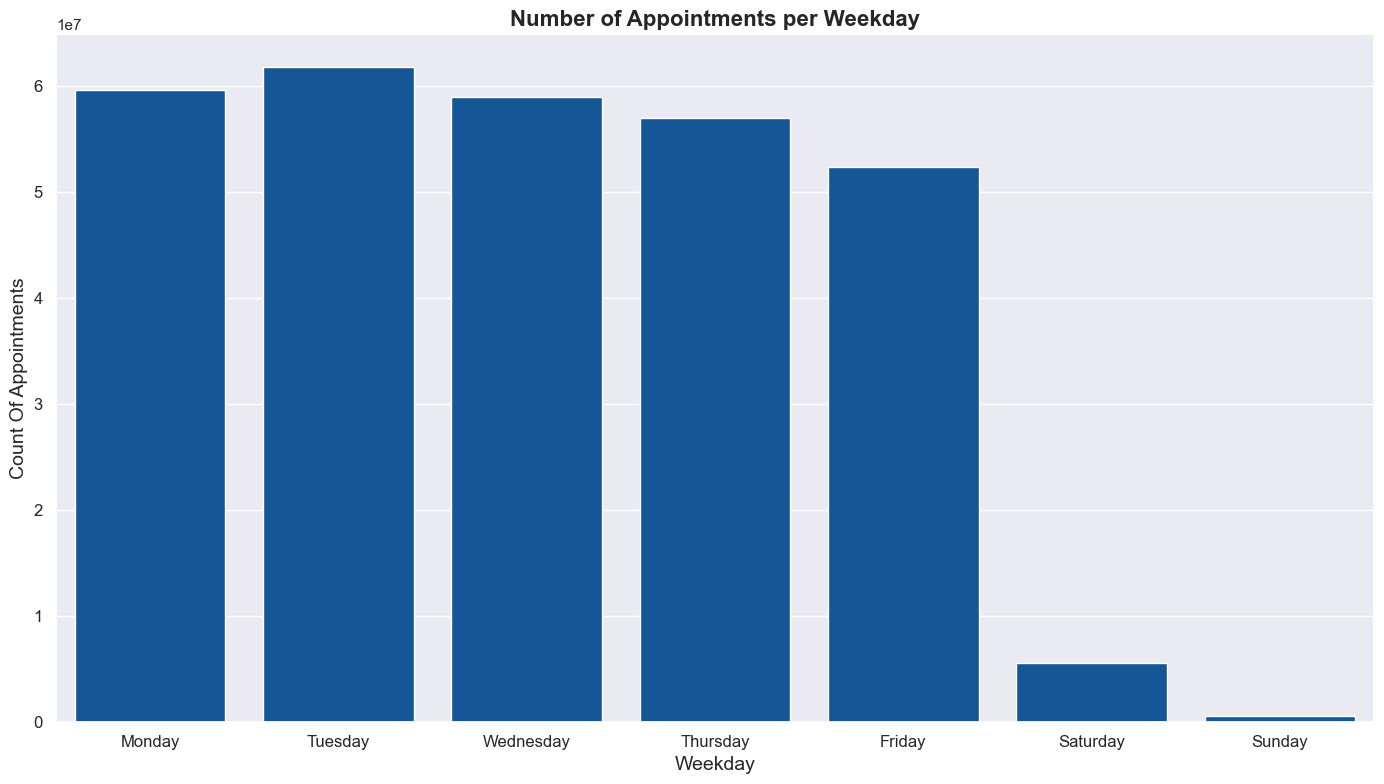

In [155]:
# Create a barplot of the number of appointments per weekday.
generate_barplot(nc_wd, x_axis='weekday', y_axis='count_of_appointments', \
                 title='Number of Appointments per Weekday', \
                 save_path='fig_appoiments_weekday')

> ***Observations*** <br>
> GP Practices are usually open Monday to Friday only, which the data matches.

**4.1.4. Are there any seasonal trends in the monthly number of appointments?**

Use appointments_regional DataFrame (ar). <br>
Seasons: Spring (March to May), Summer (June to August), Autumn (September to November), and Winter (December to February)

In [160]:
# Create a new DataFrame only with 'appointment_month' and 'count_of_appointments'.
new_columns = ['appointment_month', 'count_of_appointments'] 
ar_season = ar[new_columns] 

# View the DataFrame.
ar_season.head()

appointment_month  count_of_appointments
0           2020-01                   8107
1           2020-01                   6791
2           2020-01                  20686
3           2020-01                   4268
4           2020-01                  11971

In [161]:
# Create separate columns for year and month in ar_season.
# Create a new column for appointment_date.
ar_season['appointment_date'] = pd.to_datetime(ar_season['appointment_month'])

# Create a new column 'year' from the new date column.
ar_season['year'] = ar_season['appointment_date'].dt.year

# Create a new column 'month' from the new date column.
ar_season['month'] = ar_season['appointment_date'].dt.month_name()

# View the DataFrame.
ar_season

appointment_month  count_of_appointments appointment_date  year  \
0                2020-01                   8107       2020-01-01  2020   
1                2020-01                   6791       2020-01-01  2020   
2                2020-01                  20686       2020-01-01  2020   
3                2020-01                   4268       2020-01-01  2020   
4                2020-01                  11971       2020-01-01  2020   
...                  ...                    ...              ...   ...   
596816           2022-06                     21       2022-06-01  2022   
596817           2022-06                      8       2022-06-01  2022   
596818           2022-06                     28       2022-06-01  2022   
596819           2022-06                     17       2022-06-01  2022   
596820           2022-06                     10       2022-06-01  2022   

          month  
0       January  
1       January  
2       January  
3       January  
4       January  
...         ...  
596816     June  
596817     June  
596818     June  
596819     June  
596820     June  

[596821 rows x 5 columns]

In [162]:
# Group data by year and month.
ar_mon = ar_season.groupby(['month', 'year'])['count_of_appointments']. \
                            sum().reset_index(name='count_of_appointments')

# Create order of column 'month' by calendar year.
ar_mon['month'] = pd.Categorical(ar_mon['month'], ['January', 'February', 'March', 'April', \
                                                     'May', 'June', 'July', 'August', 'September', \
                                                     'October', 'November', 'December' ])

# View the DataFrame.
ar_mon.head()

month  year  count_of_appointments
0   April  2020               16007881
1   April  2021               23879932
2   April  2022               23913060
3  August  2020               20150520
4  August  2021               23852171

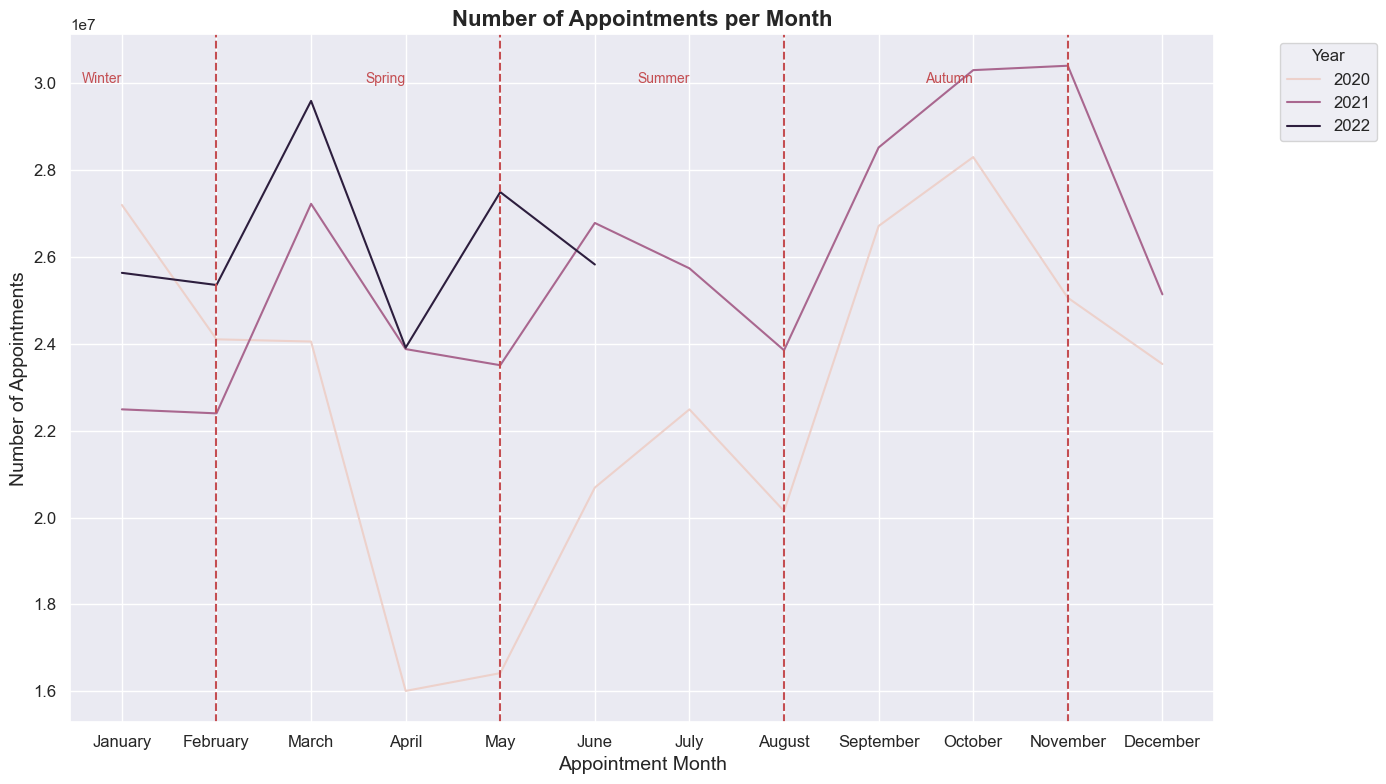

In [163]:
# Create a lineplot of appointments per month for the 3 available years.

# Set figure size & style for seaborn.
sns.set_theme(style='darkgrid')
sns.set(rc={'figure.figsize':(14, 8)})

# Plot the graph.
sns.lineplot(x='month', y='count_of_appointments', hue='year', data=ar_mon, errorbar=None)

# Add annotation lines for the seasons.
plt.axvline(x='May', color='r', linestyle='--')
plt.axvline(x='August', color='r', linestyle='--')
plt.axvline(x='November', color='r', linestyle='--')
plt.axvline(x='February', color='r', linestyle='--')

# Add text labels for the seasons.
plt.text(x='April', y=30000000, s='Spring', color='r', fontsize=10, horizontalalignment='right')
plt.text(x='July', y=30000000, s='Summer', color='r', fontsize=10, horizontalalignment='right')
plt.text(x='October', y=30000000, s='Autumn', color='r', fontsize=10, horizontalalignment='right')
plt.text(x='January', y=30000000, s='Winter', color='r', fontsize=10, horizontalalignment='right')

# Add titles, labels, and legend.
plt.title('Number of Appointments per Month', fontsize=16, fontweight='bold')
plt.xlabel('Appointment Month', fontsize=14)
plt.ylabel('Number of Appointments', fontsize=14)
plt.legend(title = 'Year', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
plt.tick_params(axis='both', labelsize=12)
    
# Save the chart.
plt.savefig('fig_appointment_month_seasonal', dpi=500, bbox_inches='tight')

# Display the chart.
plt.tight_layout()
plt.show()

Determine the seasonal trend withe the seasonal_decompose() method.

In [165]:
# Create a new DataFrame only showing 'appointment_month' and 'count_of_appointments'.
ar_seasonal = ar.groupby(['appointment_month'])['count_of_appointments'].sum()

# View the DataFrame.
ar_seasonal.head()

appointment_month
2020-01    27199296
2020-02    24104621
2020-03    24053468
2020-04    16007881
2020-05    16417212
Name: count_of_appointments, dtype: int64

In [166]:
# Use seasonal_decompose() function to show seasonality across 12 months.
decomposition = seasonal_decompose(ar_seasonal, model='additive', period=12)

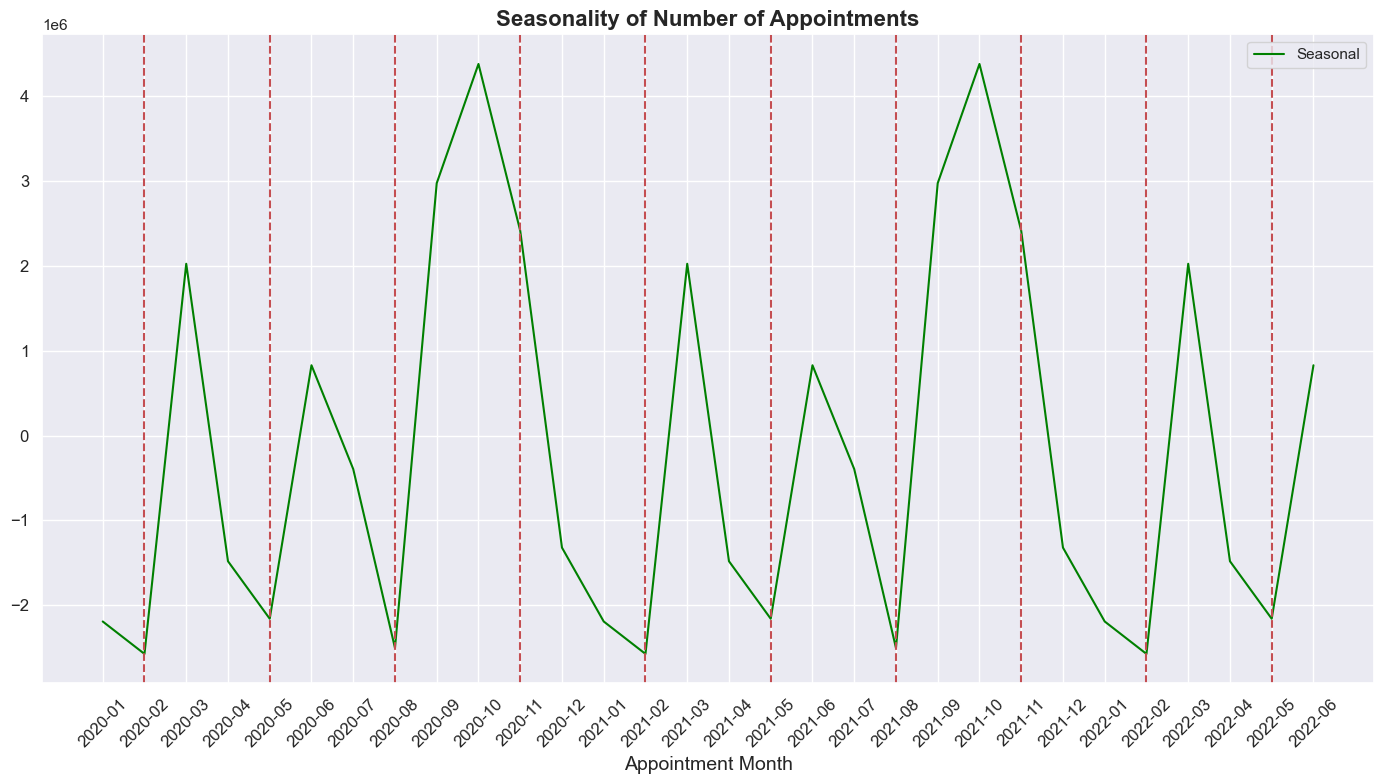

In [167]:
# Plot a line chart to show the seasonal trends.

# Set figure size & style for seaborn.
sns.set_theme(style='darkgrid')
sns.set(rc={'figure.figsize':(14, 8)})

# Plot the lineplot.
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper right')

# Add annotation lines for the seasons.
plt.axvline(x='2020-02', color='r', linestyle='--')
plt.axvline(x='2020-05', color='r', linestyle='--')
plt.axvline(x='2020-08', color='r', linestyle='--')
plt.axvline(x='2020-11', color='r', linestyle='--')
plt.axvline(x='2021-02', color='r', linestyle='--')
plt.axvline(x='2021-05', color='r', linestyle='--')
plt.axvline(x='2021-08', color='r', linestyle='--')
plt.axvline(x='2021-11', color='r', linestyle='--')
plt.axvline(x='2022-02', color='r', linestyle='--')
plt.axvline(x='2022-05', color='r', linestyle='--')

# Customize the plot.
plt.title('Seasonality of Number of Appointments', fontsize=16, fontweight='bold')
plt.xlabel('Appointment Month', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.xticks(rotation=45)

# Save the chart.
plt.savefig('fig_appointment_month_seasonaility', dpi=500, bbox_inches='tight')

# Display the chart.
plt.tight_layout()
plt.show()

> ***Observations*** <br>
> Main peaks are in October and March, which is already known as 'winter pressure'.

### 4.2. National Categories

Use national_categories DataFrame (nc).

**4.2.1. Service Settings**

**Question 1:** How many service settings are there?

In [174]:
# Determine the number of service settings in the nc DataFrame.
print('Number of service settings: ', nc['service_setting'].nunique())

Number of service settings:  5


**Question 2:** How many appointments are there per service setting?

In [176]:
# Determine the total number of appointments per service settings and the percentage share of the total.
result_ss = sum_data(nc, 'service_setting')
result_ss

total_appointments  percentage_share
service_setting                                                
General Practice                    270811691              91.5
Unmapped                             11080810               3.7
Primary Care Network                  6557386               2.2
Other                                 5420076               1.8
Extended Access Provision             2176807               0.7

**Question 3:** How do the number of appointments by service setting change over time?

In [178]:
# Aggregate national categories data on monthly level and determine the sum of records per month.
nc_ss_month = nc.groupby(['appointment_month', 'service_setting'])\
                        ['count_of_appointments'].agg(['sum']).reset_index()

# Rename sum columns to count of appointments.
nc_ss_month = nc_ss_month.rename(columns={'sum': 'count_of_appointments'})

# View output.
nc_ss_month.head()

appointment_month            service_setting  count_of_appointments
0           2021-08  Extended Access Provision                 160927
1           2021-08           General Practice               21575852
2           2021-08                      Other                 449101
3           2021-08       Primary Care Network                 432448
4           2021-08                   Unmapped                1233843

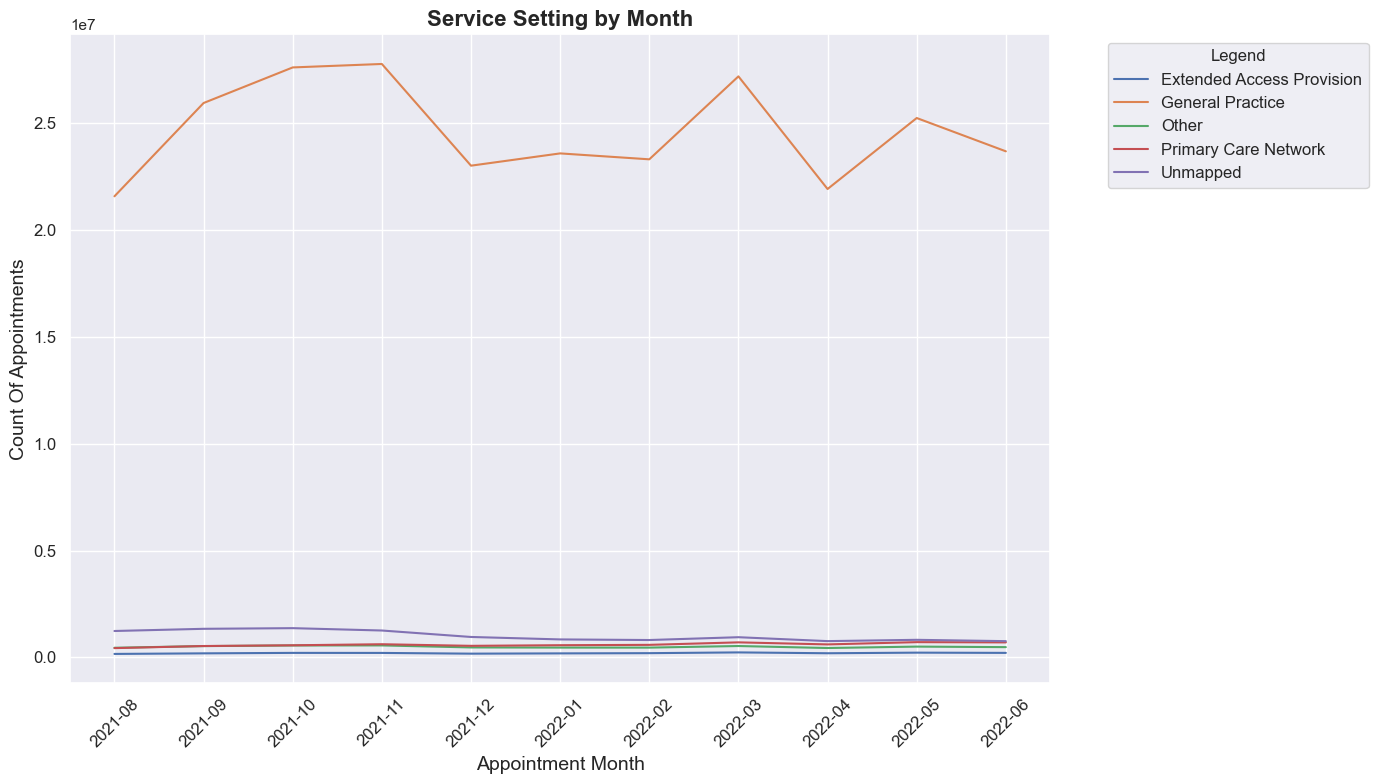

In [179]:
# Create lineplot showing service settings over time.
generate_multi_lineplot(nc_ss_month, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='service_setting', title='Service Setting by Month')

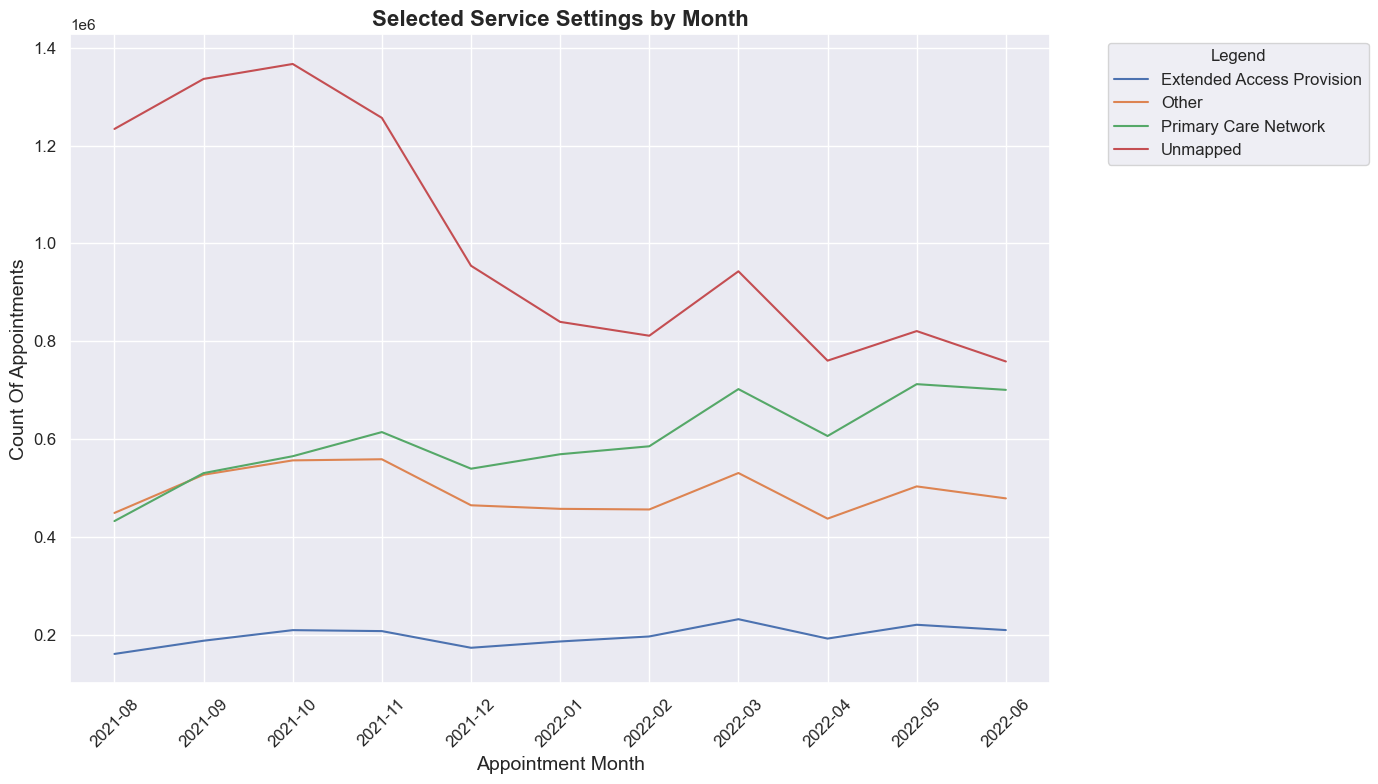

In [180]:
# Create lineplot to only show certain service settings due to scale:
# 'Primary Care Network', 'Other' and 'Extended Access Provision'.
nc_ss_month_sel = nc_ss_month[nc_ss_month['service_setting'].isin(['Primary Care Network', 'Other', \
                                                         'Extended Access Provision', 'Unmapped'])]

# Create lineplot showing the specific service settings over time.
generate_multi_lineplot(nc_ss_month_sel, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='service_setting', title='Selected Service Settings by Month')

**Question 4:** Which service setting was the most popular for NHS North West London from 1 January to 1 June 2022?

In [182]:
# Define the date range.
start_date = '2022-01-01'
end_date = '2022-06-30'

# Filter the DataFrame for the date range
nc_2022 = nc[(nc['appointment_date'] >= start_date) & (nc['appointment_date'] <= end_date)]

# Sum the number of appointments by year, location and service setting.
nc_service = nc_2022.groupby(['sub_icb_location_name', 'service_setting'])['count_of_appointments']. \
                        agg(['sum']).reset_index().sort_values(by='sum', ascending=False) 

# Filter the DataFrame for the date range
nc_service[nc_service['sub_icb_location_name'] == 'NHS North West London ICB - W2U3Z']

sub_icb_location_name            service_setting      sum
381  NHS North West London ICB - W2U3Z           General Practice  5719516
384  NHS North West London ICB - W2U3Z                   Unmapped   462758
382  NHS North West London ICB - W2U3Z                      Other   181576
383  NHS North West London ICB - W2U3Z       Primary Care Network   130526
380  NHS North West London ICB - W2U3Z  Extended Access Provision   115052

> ***Observations*** <br>
> General Practice is the main service setting (92% of appointments). <br>
> Data quality is improving, as the number of unmapped appointments has reduced over time. <br>
> The contribution of the Primary Care Network is low (2.2%), but has been increasing. <br>
> Routine & acute consultations make up 51% of appointments.

**4.2.2. Context Types**

**Question 1**: How many context types are there?

In [187]:
# Determine the number of context types.
print('Number of context types: ', nc['context_type'].nunique())

Number of context types:  3


**Question 2**: How many appointments are there per context type?

In [189]:
# Determine the total number of appointments per context type and the percentage share of the total.
result_ct = sum_data(nc, 'context_type')
result_ct

total_appointments  percentage_share
context_type                                                
Care Related Encounter           257075158              86.8
Inconsistent Mapping              27890802               9.4
Unmapped                          11080810               3.7

**Question 3:** How do the number of appointments by context type change over time?

In [191]:
# Aggregate national categories data on monthly level and determine the sum of records per month.
nc_ct_month = nc.groupby(['appointment_month', 'context_type'])\
                        ['count_of_appointments'].agg(['sum']).reset_index()

# Rename sum columns to count of appointments.
nc_ct_month = nc_ct_month.rename(columns={'sum': 'count_of_appointments'})

# View output.
nc_ct_month.head()

appointment_month            context_type  count_of_appointments
0           2021-08  Care Related Encounter               20255235
1           2021-08    Inconsistent Mapping                2363093
2           2021-08                Unmapped                1233843
3           2021-09  Care Related Encounter               24404251
4           2021-09    Inconsistent Mapping                2782135

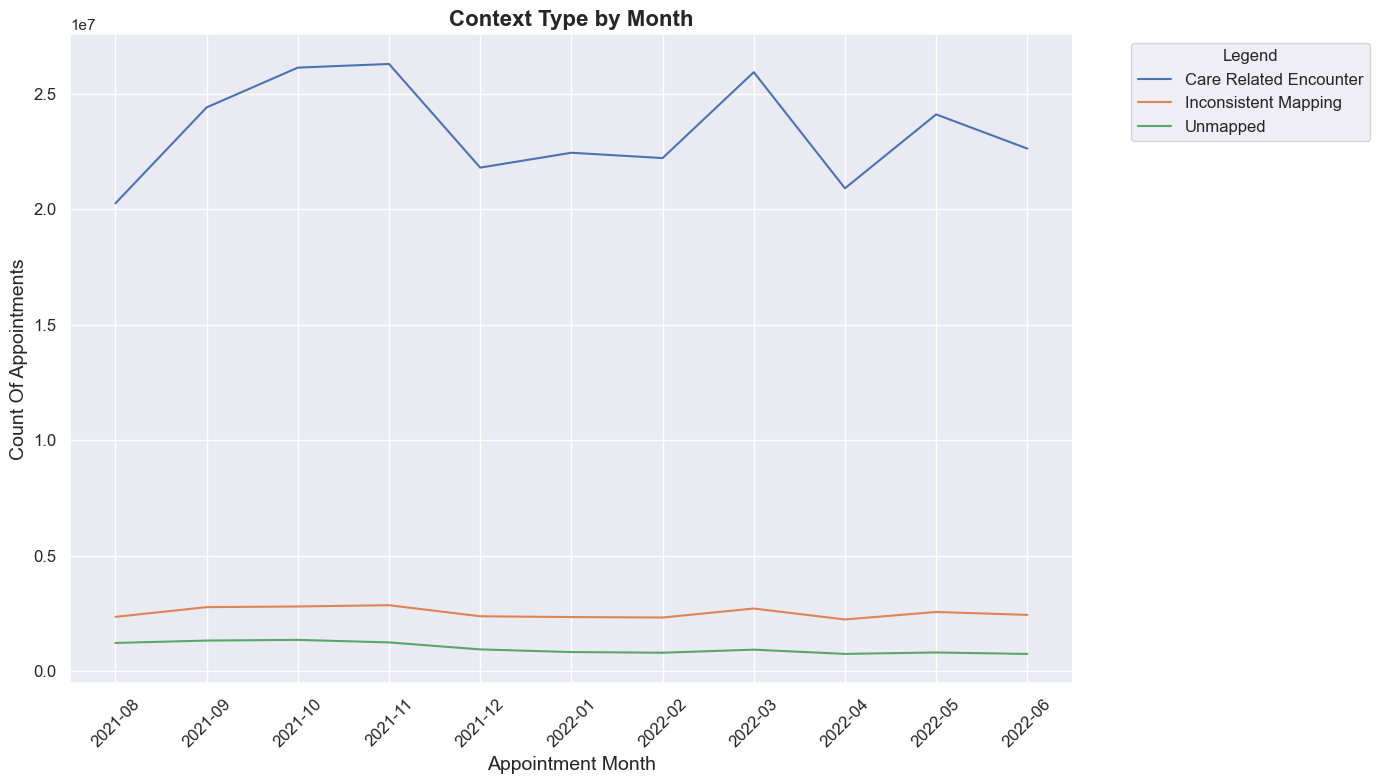

In [192]:
# Create lineplot showing context type over time.
generate_multi_lineplot(nc_ct_month, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='context_type', title='Context Type by Month')

> ***Observations*** <br>
> 13% of appointments are inconsistently mapped or unmapped. <br>
> 87% of appointments are Care Realted Encounters. The line moves simiarly to the GP line in service settings. <br>
> As there is only one usuable variable, context type is less interesting for the analysis.

**4.2.3. National Categories**

**Question 1**: How many national categories are there?

In [197]:
print('Number of national categories: ', nc['national_category'].nunique())

Number of national categories:  18


**Question 2**: How many appointments are there per category?

In [199]:
# Determine the total number of appointments per national category and the percentage share of the total.
result_nc = sum_data(nc, 'national_category')
result_nc

total_appointments  \
national_category                                                                         
General Consultation Routine                                                   97271522   
General Consultation Acute                                                     53691150   
Clinical Triage                                                                41546964   
Planned Clinics                                                                28019748   
Inconsistent Mapping                                                           27890802   
Planned Clinical Procedure                                                     25702694   
Unmapped                                                                       11080810   
Unplanned Clinical Activity                                                     3055794   
Home Visit                                                                      2144452   
Structured Medication Review                                                    1858379   
Service provided by organisation external to the practice                        852133   
Patient contact during Care Home Round                                           810330   
Care Home Visit                                                                  628279   
Social Prescribing Service                                                       475828   
Walk-in                                                                          412438   
Care Home Needs Assessment & Personalised Care and Support Planning              405904   
Non-contractual chargeable work                                                  138911   
Group Consultation and Group Education                                            60632   

                                                                     percentage_share  
national_category                                                                      
General Consultation Routine                                                     32.9  
General Consultation Acute                                                       18.1  
Clinical Triage                                                                  14.0  
Planned Clinics                                                                   9.5  
Inconsistent Mapping                                                              9.4  
Planned Clinical Procedure                                                        8.7  
Unmapped                                                                          3.7  
Unplanned Clinical Activity                                                       1.0  
Home Visit                                                                        0.7  
Structured Medication Review                                                      0.6  
Service provided by organisation external to the practice                         0.3  
Patient contact during Care Home Round                                            0.3  
Care Home Visit                                                                   0.2  
Social Prescribing Service                                                        0.2  
Walk-in                                                                           0.1  
Care Home Needs Assessment & Personalised Care and Support Planning               0.1  
Non-contractual chargeable work                                                   0.0  
Group Consultation and Group Education                                            0.0

**Question 3:** How do the nuumber of appointments by context type change over time?

In [201]:
# Aggregate national categories data on monthly level.
nc_nc_month = nc.groupby(['appointment_month', 'national_category'])\
                        ['count_of_appointments'].agg(['sum']).reset_index()

# Rename sum columns to count of appointments.
nc_nc_month = nc_nc_month.rename(columns={'sum': 'count_of_appointments'})

# View output.
nc_nc_month.head()

appointment_month  \
0           2021-08   
1           2021-08   
2           2021-08   
3           2021-08   
4           2021-08   

                                                     national_category  \
0  Care Home Needs Assessment & Personalised Care and Support Planning   
1                                                      Care Home Visit   
2                                                      Clinical Triage   
3                                           General Consultation Acute   
4                                         General Consultation Routine   

   count_of_appointments  
0                  29676  
1                  47583  
2                3704207  
3                4280920  
4                7756045

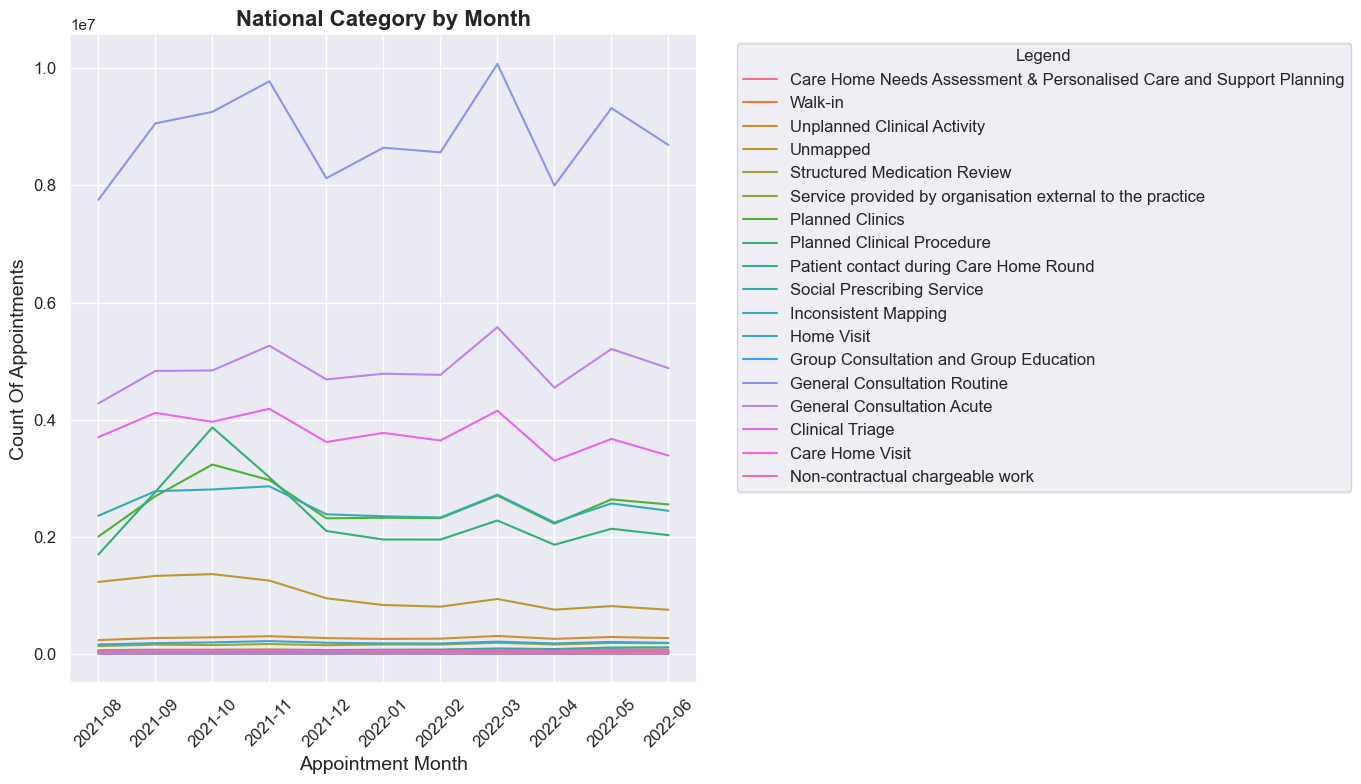

In [202]:
# Create lineplot showing national category over time.
generate_multi_lineplot(nc_nc_month, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='national_category', title='National Category by Month')

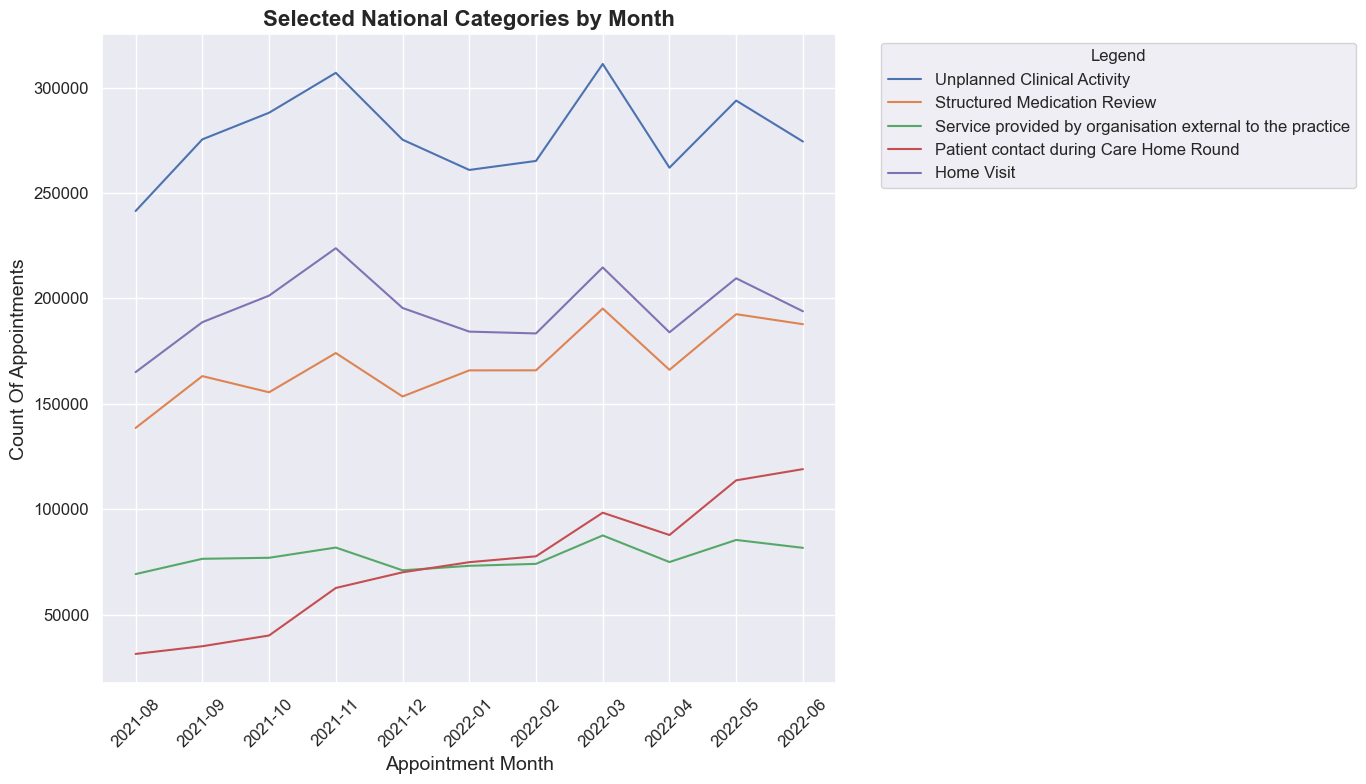

In [203]:
# Only show chart for certain national categories due to scale.
nc_nc_month = nc_nc_month[nc_nc_month['national_category'].isin(['Unplanned Clinical Activity', 'Home Visit', \
                                                               'Structured Medication Review', \
                                                               'Service provided by organisation external to the practice', \
                                                              'Patient contact during Care Home Round'])]

# Create lineplot showing the specific service settings over time.
generate_multi_lineplot(nc_nc_month, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='national_category', title='Selected National Categories by Month')

> ***Observations*** <br>
> Routine & acute consultations make up 51% of appointments. <br>
> 13.2% of entries unmapped or inconsistently mapped.

### 4.3. Monthly Appointment, Patient & GP Data

Use registered_patients (rp_complete) and national_categories (nc) DataFrames. <br>
Appointments per patient are calculated by dividing the total number of appointments by the number of registered patients for each month. <br>
Date range: August 2021 to June 2022

**4.3.1. Appointments per patient over time**

In [209]:
# Merge monthly national_categories (nc) data with monthly registered patient (rp_complete) data.
nc_rp_month = pd.merge(nc_month, rp_month,
                           how='left', on='appointment_month')

# Calculate a new column with the appointments per patient.
nc_rp_month['appointments_per_patient'] = nc_rp_month['count_of_appointments']/nc_rp_month['number_of_patients']

# Round the values.
nc_rp_month['appointments_per_patient'] = nc_rp_month['appointments_per_patient'].round(2)

# View the DataFrame.
nc_rp_month

appointment_month  count_of_appointments  number_of_patients  \
0            2021-08               23852171            61032314   
1            2021-09               28522501            61086074   
2            2021-10               30303834            61194033   
3            2021-11               30405070            61300225   
4            2021-12               25140776            61395839   
5            2022-01               25635474            61469262   
6            2022-02               25355260            61526961   
7            2022-03               29595038            61573603   
8            2022-04               23913060            61625745   
9            2022-05               27495508            61654788   
10           2022-06               25828078            61715466   

    appointments_per_patient  
0                       0.39  
1                       0.47  
2                       0.50  
3                       0.50  
4                       0.41  
5                       0.42  
6                       0.41  
7                       0.48  
8                       0.39  
9                       0.45  
10                      0.42

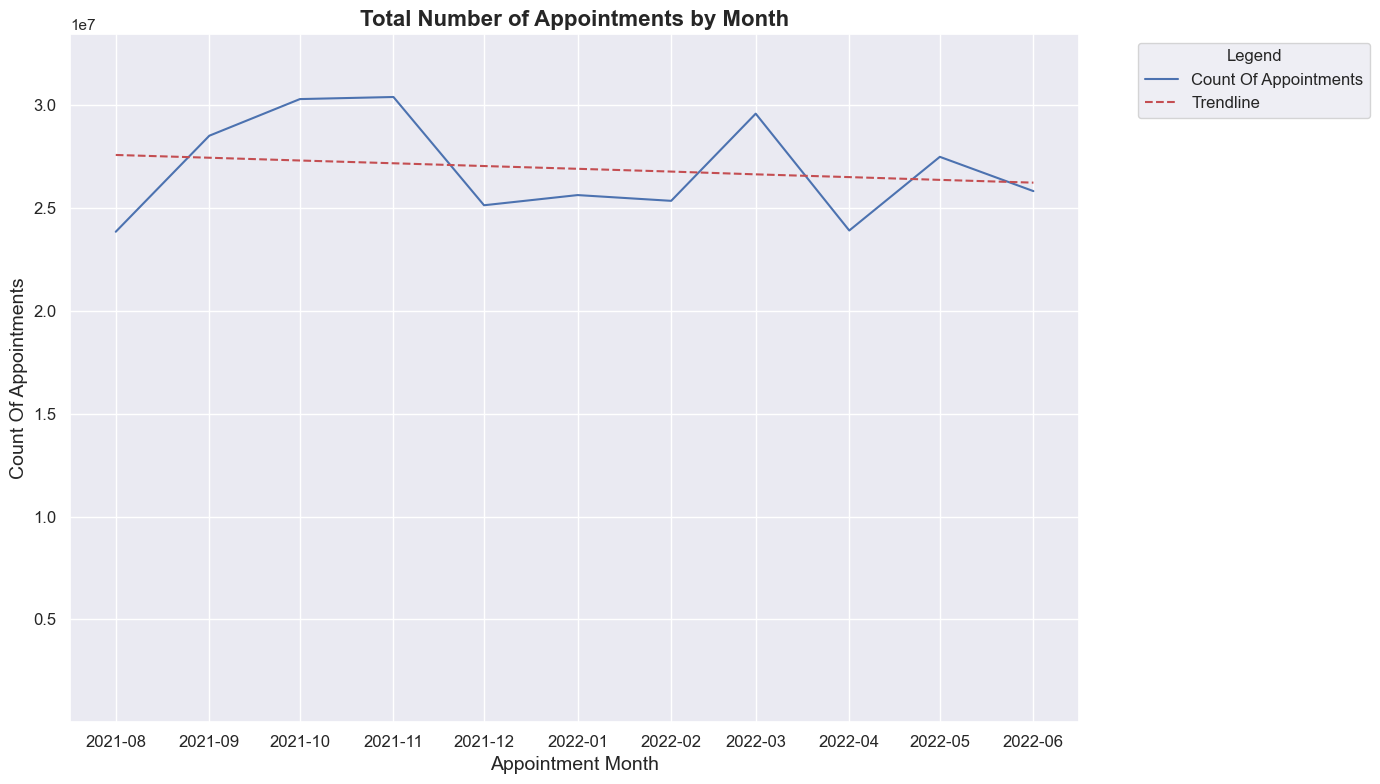

In [210]:
# Use defined function to plot a lineplot for monthly appointments nc_rp_month DataFrame.
generate_lineplot_with_trendline(nc_rp_month, x_axis='appointment_month', \
                                y_axis='count_of_appointments', title='Total Number of Appointments by Month', \
                                ylim=(0.2, nc_rp_month['count_of_appointments'].max() * 1.1), \
                                save_path='fig_appointment_month')

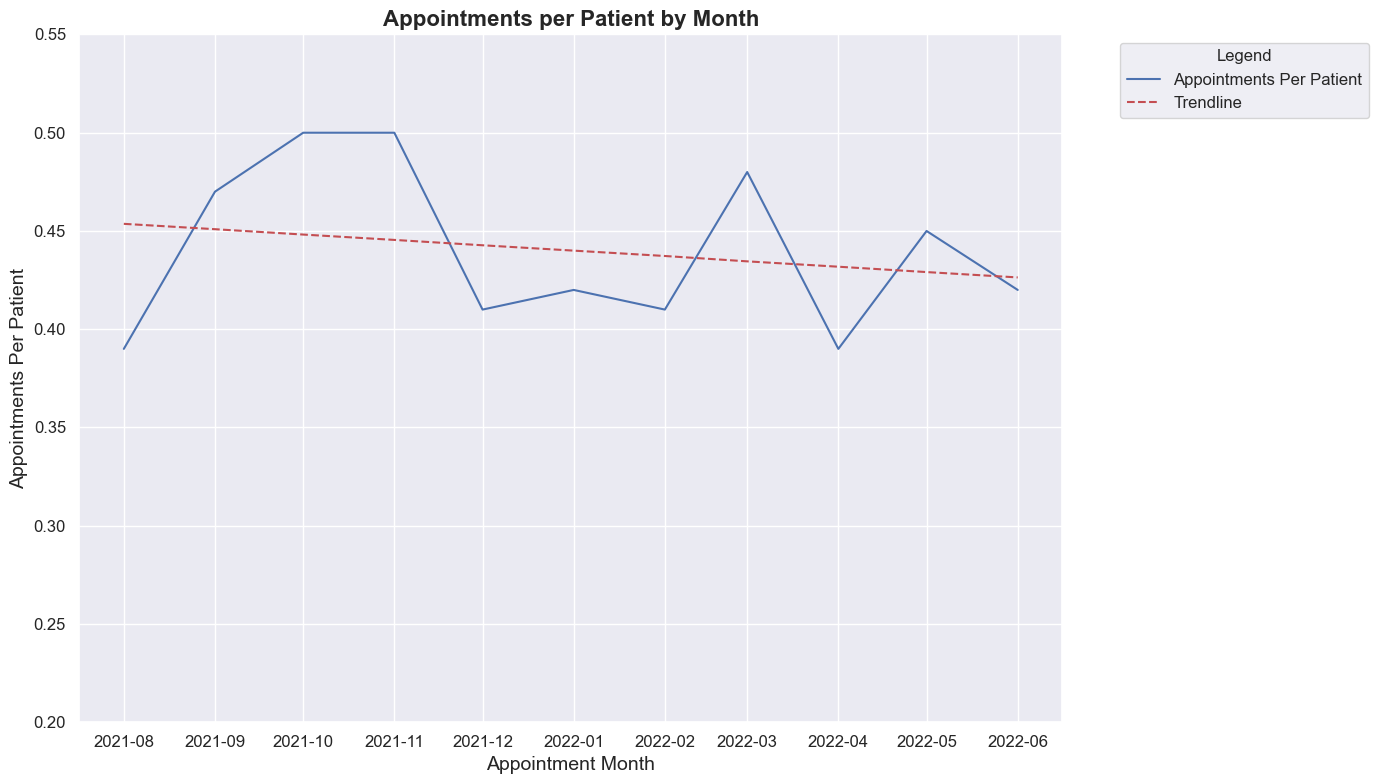

In [211]:
# Use defined function to plot a lineplot for monthly appointments per patient in nc_rp_month DataFrame.
generate_lineplot_with_trendline(nc_rp_month, x_axis='appointment_month', \
                                y_axis='appointments_per_patient', title='Appointments per Patient by Month', \
                                ylim=(0.2, nc_rp_month['appointments_per_patient'].max() * 1.1), \
                                save_path='fig_appointment_patient_month')

**4.3.2. Monthly number of patients over time**

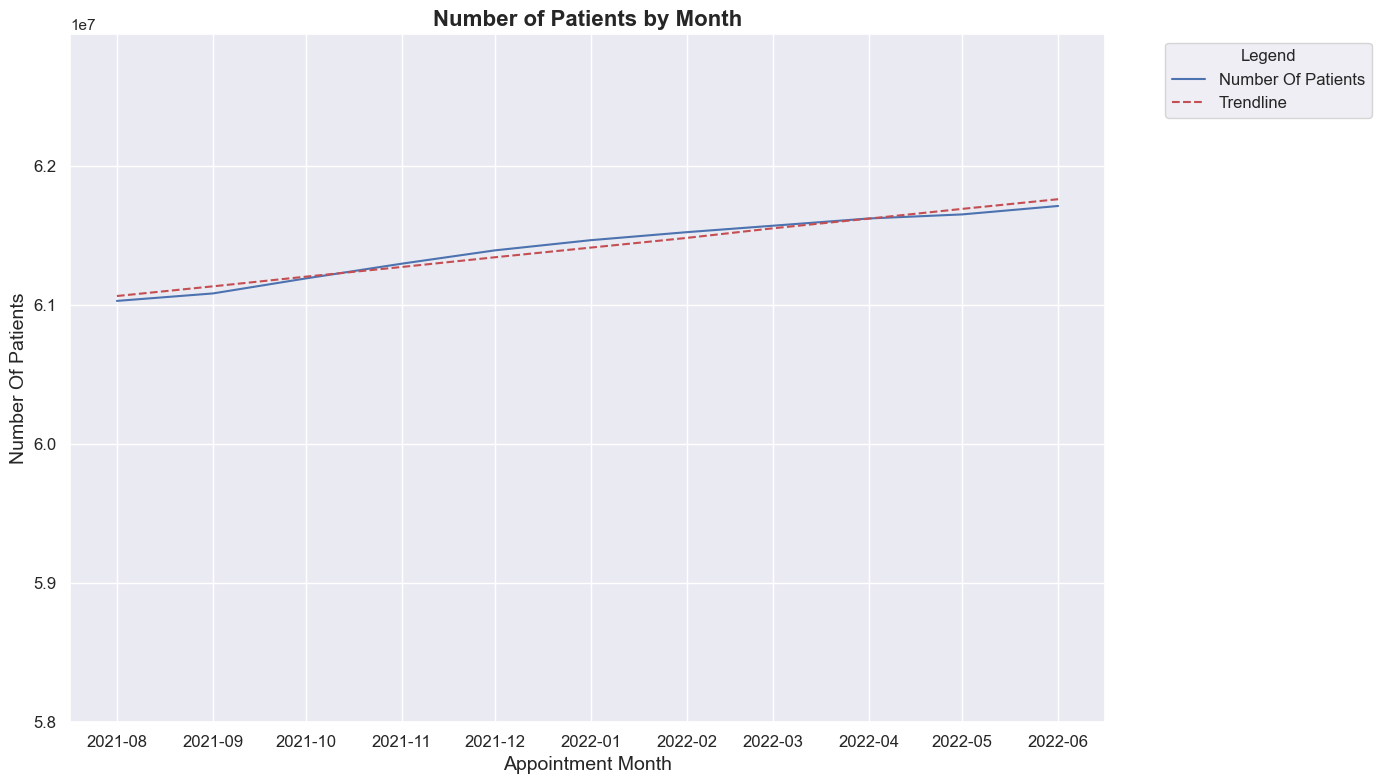

In [214]:
# Use defined function to plot a lineplot for monthly number of patients in nc_rp_month DataFrame.
generate_lineplot_with_trendline(nc_rp_month, x_axis='appointment_month', \
                                 y_axis='number_of_patients', title='Number of Patients by Month', \
                                 ylim=(58000000, nc_rp_month['number_of_patients'].max() * 1.02), \
                                save_path='Patient_Month')

**4.3.3. Monthly number of GPs over time by staff role**

In [217]:
# Use gp DataFrame and group the total number of GPs per month.
gp_month = gp_short.groupby(['appointment_month', 'staff_role'])[['fte', 'patients']].agg('sum'). \
                        reset_index()

gp_month

appointment_month              staff_role      fte  patients
0            2017-03     Fully qualified GPs  29332.1  58265648
1            2017-06     Fully qualified GPs  29113.0  58410942
2            2017-09     Fully qualified GPs  29128.4  58667714
3            2017-12     Fully qualified GPs  28939.6  58860423
4            2018-03     Fully qualified GPs  28817.9  58983661
..               ...                     ...      ...       ...
75           2022-05     Fully qualified GPs  27626.8  61695076
76           2022-05  GPs in training grades   7133.2  61695076
77           2022-06                 All GPs  34586.1  61756357
78           2022-06     Fully qualified GPs  27557.9  61756357
79           2022-06  GPs in training grades   7028.0  61756357

[80 rows x 4 columns]

In [218]:
# Use gp DataFrame and group the total number of GPs per month.
gp_month_filtered = gp_filtered.groupby(['appointment_month', 'staff_role'])[['fte', 'patients']].agg('sum'). \
                        reset_index()

gp_month_filtered.head()

appointment_month              staff_role      fte  patients
0           2021-08                 All GPs  35574.6  61024953
1           2021-08     Fully qualified GPs  27828.6  61024953
2           2021-08  GPs in training grades   7746.4  61024953
3           2021-09                 All GPs  35605.5  61138782
4           2021-09     Fully qualified GPs  27919.7  61138782

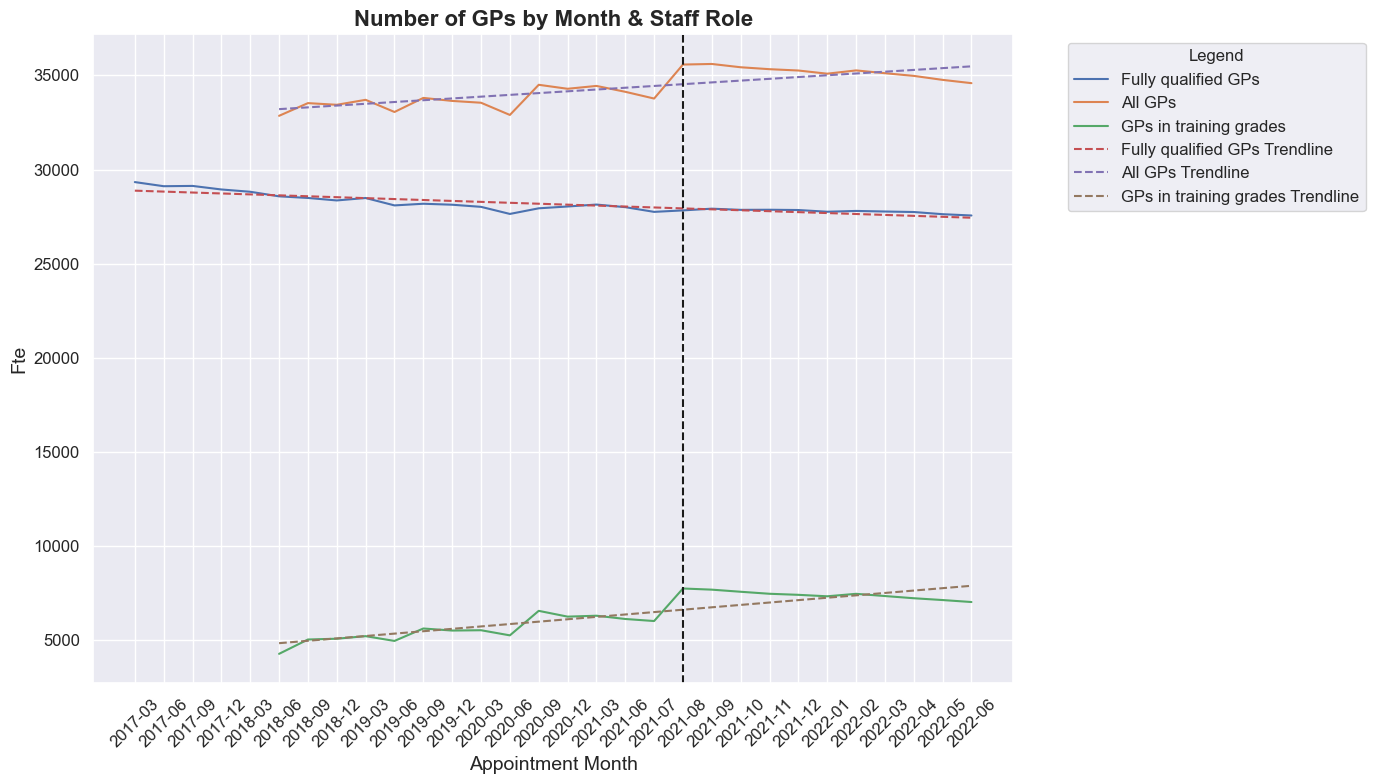

In [219]:
# Use defined function to plot a lineplot for monthyl appointment per patient in nc_rp_month DataFrame.
generate_multi_lineplot_with_trendline(gp_month, x_axis='appointment_month', y_axis='fte', \
                                       hue='staff_role', date='2021-08', title='Number of GPs by Month & Staff Role', \
                                       save_path='fig_gp_month_role')

In [220]:
# Merge filtered GP date and registered patient date to calculate GP per patient value.
gp_rp_month = pd.merge(gp_month_filtered, rp_month,
                       how='left', on='appointment_month')

# Add calculated columns for the share of 'did not attends' (DNA) per total appointments.
gp_rp_month['patient_per_gp'] = (gp_rp_month['number_of_patients']/gp_rp_month['fte']).round(0)

# View the DataFrame.
gp_rp_month.head()

appointment_month              staff_role      fte  patients  \
0           2021-08                 All GPs  35574.6  61024953   
1           2021-08     Fully qualified GPs  27828.6  61024953   
2           2021-08  GPs in training grades   7746.4  61024953   
3           2021-09                 All GPs  35605.5  61138782   
4           2021-09     Fully qualified GPs  27919.7  61138782   

   number_of_patients  patient_per_gp  
0            61032314          1716.0  
1            61032314          2193.0  
2            61032314          7879.0  
3            61086074          1716.0  
4            61086074          2188.0

In [221]:
# Filter the data for All Gps and Fully Qualified GPs. 
gp_rp_filtered = gp_rp_month[gp_rp_month['staff_role'].isin(['All GPs', 'Fully qualified GPs'])]

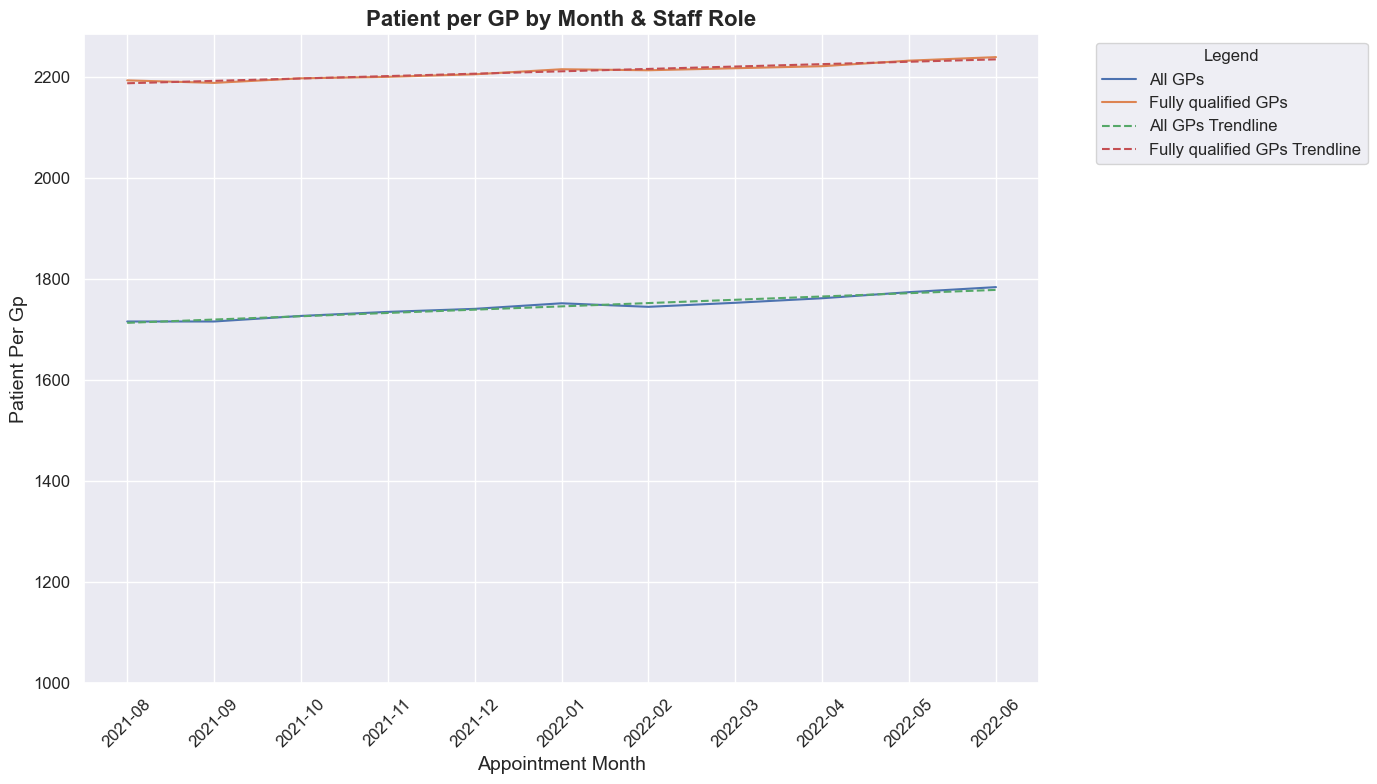

In [222]:
# Use defined function to plot a lineplot for monthly GP per patient data for All GPs and Fully qualified GPs.
generate_multi_lineplot_with_trendline(gp_rp_filtered, x_axis='appointment_month', y_axis='patient_per_gp', \
                                       hue='staff_role', title='Patient per GP by Month & Staff Role', \
                                       ylim=(1000, gp_rp_filtered['patient_per_gp'].max() * 1.02), \
                                       save_path='patient_gp_month_role')

> ***Observations*** <br>
> Between 2021-08 and 2022-06
> - the number of appointments per patient is decreasing
> - the number of patients is increasing
> - the number of fully qualified GPs has remained relatively constant (-1%)
> - the number of GPs in training has decreased (-9%), so that the number of all GPs has reduced by almost -3% <br>
> **Result**: the number of patients per GP is increasing, reducing availability to GPs.

### 4.4. Appointment Status "Did Not Attend" (DNA) 

The appointment status is noted in the appointments_regional DataFrame (ar). <br>
After an appointment has taken place, the appointment status is changed to ‘Attended’ or ‘DNA’ (Did Not Attend). <br>
In 3%–6% of monthly appointments, the final status of an appointment remains as ‘Booked’ and the status of these appointments is reported as 'Unknown'.

**4.4.1. Review and prepare data for analysis**

To analyse 'DNA' the appointments_regional data (ar) is merged with the number of patients (rp_complete). <br>
ar_fil is used instead of ar for the date range of August 2021 to June 2022.

In [229]:
# Determine the number of appointment statuses.
print('Number of appointment statuses: ', ar['appointment_status'].nunique())

Number of appointment statuses:  3


In [230]:
# Determine the total number of appointments per appointment status and the percentage share of the total.
result_as = sum_data(ar, 'appointment_status')
result_as

total_appointments  percentage_share
appointment_status                                      
Attended                     677755876              91.2
Unknown                       34137416               4.6
DNA                           30911233               4.2

In [231]:
# Group and pivot filtered appointments_regional by month and ICB.
ar_as_pivot= ar.pivot_table(index=['appointment_month'], columns='appointment_status', 
                                      values='count_of_appointments',  aggfunc='sum')

# Rename the columns in the pivot for consistency.
ar_as_pivot = ar_as_pivot.rename(columns={'Attended': 'attended', 'DNA': 'dna', 'Unknown': 'unknown'})

# Add a column for the sum of total appointments.
ar_as_pivot['total_appointments'] = ar_as_pivot[['attended', 'dna', 'unknown']].sum(axis=1)

# View the DataFrame.
ar_as_pivot.head()

appointment_status  attended      dna  unknown  total_appointments
appointment_month                                                 
2020-01             24538291  1298269  1362736            27199296
2020-02             21640067  1215154  1249400            24104621
2020-03             20718865  1166314  2168289            24053468
2020-04             13982824   478766  1546291            16007881
2020-05             14962850   449057  1005305            16417212

In [232]:
# Group and pivot filtered appointments_regional by month and ICB.
ar_fil_as_pivot = ar_fil.pivot_table(index=['appointment_month', 'icb_ons_code'], columns='appointment_status', 
                                      values='count_of_appointments',  aggfunc='sum')

# Reset the index.
ar_fil_as_pivot = ar_fil_as_pivot.reset_index()

# Rename the columns in the pivot for consistency.
ar_fil_as_pivot = ar_fil_as_pivot.rename(columns={'Attended': 'attended', 'DNA': 'dna', 'Unknown': 'unknown'})

# Add a column for the sum of total appointments.
ar_fil_as_pivot['total_appointments'] = ar_fil_as_pivot[['attended', 'dna', 'unknown']].sum(axis=1)

# View the DataFrame.
ar_fil_as_pivot.head()

appointment_status appointment_month icb_ons_code  attended    dna  unknown  \
0                            2021-08    E54000008    971735  51385    41684   
1                            2021-08    E54000010    393482  18966    17272   
2                            2021-08    E54000011    196788   7088     5948   
3                            2021-08    E54000013    310949  10866    10812   
4                            2021-08    E54000015    475673  16659    14683   

appointment_status  total_appointments  
0                              1064804  
1                               429720  
2                               209824  
3                               332627  
4                               507015

In [233]:
# Group registered_patients by ICB and month and rename the sum column.
rp_icb = rp_complete.groupby(['icb_ons_code', 'icb_ons_name', 'appointment_month'])['number_of_patients'] \
           .sum() .reset_index(name='number_of_patients')

# View the DataFrame.
rp_icb.head()

icb_ons_code                                       icb_ons_name  \
0    E54000008  NHS Cheshire and Merseyside Integrated Care Board   
1    E54000008  NHS Cheshire and Merseyside Integrated Care Board   
2    E54000008  NHS Cheshire and Merseyside Integrated Care Board   
3    E54000008  NHS Cheshire and Merseyside Integrated Care Board   
4    E54000008  NHS Cheshire and Merseyside Integrated Care Board   

  appointment_month  number_of_patients  
0           2021-08             2695605  
1           2021-09             2698499  
2           2021-10             2702059  
3           2021-11             2705889  
4           2021-12             2709289

In [234]:
# Merge the two new DataFrames.
ar_fil_rp = pd.merge(ar_fil_as_pivot, rp_icb,
                           how='left', on=['appointment_month', 'icb_ons_code'])

# View the DataFrame.
ar_fil_rp.head()

appointment_month icb_ons_code  attended    dna  unknown  \
0           2021-08    E54000008    971735  51385    41684   
1           2021-08    E54000010    393482  18966    17272   
2           2021-08    E54000011    196788   7088     5948   
3           2021-08    E54000013    310949  10866    10812   
4           2021-08    E54000015    475673  16659    14683   

   total_appointments  \
0             1064804   
1              429720   
2              209824   
3              332627   
4              507015   

                                                      icb_ons_name  \
0                NHS Cheshire and Merseyside Integrated Care Board   
1       NHS Staffordshire and Stoke-on-Trent Integrated Care Board   
2         NHS Shropshire, Telford and Wrekin Integrated Care Board   
3                           NHS Lincolnshire Integrated Care Board   
4  NHS Leicester, Leicestershire and Rutland Integrated Care Board   

   number_of_patients  
0             2695605  
1             1164902  
2              515076  
3              804269  
4             1168408

In [235]:
# Validate date and sense-check for missing values, duplicates and descriptive statistics.
validate_data(ar_fil_rp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   appointment_month   462 non-null    object
 1   icb_ons_code        462 non-null    object
 2   attended            462 non-null    int64 
 3   dna                 462 non-null    int64 
 4   unknown             462 non-null    int64 
 5   total_appointments  462 non-null    int64 
 6   icb_ons_name        462 non-null    object
 7   number_of_patients  462 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 29.0+ KB
Metadata:
None

Number of missing values:
appointment_month     0
icb_ons_code          0
attended              0
dna                   0
unknown               0
total_appointments    0
icb_ons_name          0
number_of_patients    0
dtype: int64

Unique values per column:
appointment_month      11
icb_ons_code           42
attended              462
dna          

**4.4.2. What is the share of appointments that were not attended (DNA) by month?**

In [238]:
# Group data by appointment_month.
ar_rp_month = ar_fil_rp.groupby(['appointment_month'])[['attended', 'dna', 'unknown', 'total_appointments',\
                            'number_of_patients']].agg('sum').reset_index()

# Add a calculated column for share of DNA per total number of appointments and round to 2 decimals.
ar_rp_month['share_dna'] = (ar_rp_month['dna']/ ar_rp_month['total_appointments']).round(3)

# Add a calculated column for share of Unknown per total number of appointments and round to 2 decimals.
ar_rp_month['share_unknown'] = (ar_rp_month['unknown']/ ar_rp_month['total_appointments']).round(2)

# View the DataFrame.
ar_rp_month

appointment_month  attended      dna  unknown  total_appointments  \
0            2021-08  22081765   949137   821269            23852171   
1            2021-09  25757066  1321348  1444087            28522501   
2            2021-10  27170506  1565624  1567704            30303834   
3            2021-11  27667665  1428087  1309318            30405070   
4            2021-12  22853483  1198866  1088427            25140776   
5            2022-01  23597196  1076013   962265            25635474   
6            2022-02  23351939  1076658   926663            25355260   
7            2022-03  27170002  1289888  1135148            29595038   
8            2022-04  21948814  1045455   918791            23913060   
9            2022-05  25343941  1199518   952049            27495508   
10           2022-06  23715317  1167790   944971            25828078   

    number_of_patients  share_dna  share_unknown  
0             61032314      0.040           0.03  
1             61086074      0.046           0.05  
2             61194033      0.052           0.05  
3             61300225      0.047           0.04  
4             61395839      0.048           0.04  
5             61469262      0.042           0.04  
6             61526961      0.042           0.04  
7             61573603      0.044           0.04  
8             61625745      0.044           0.04  
9             61654788      0.044           0.03  
10            61715466      0.045           0.04

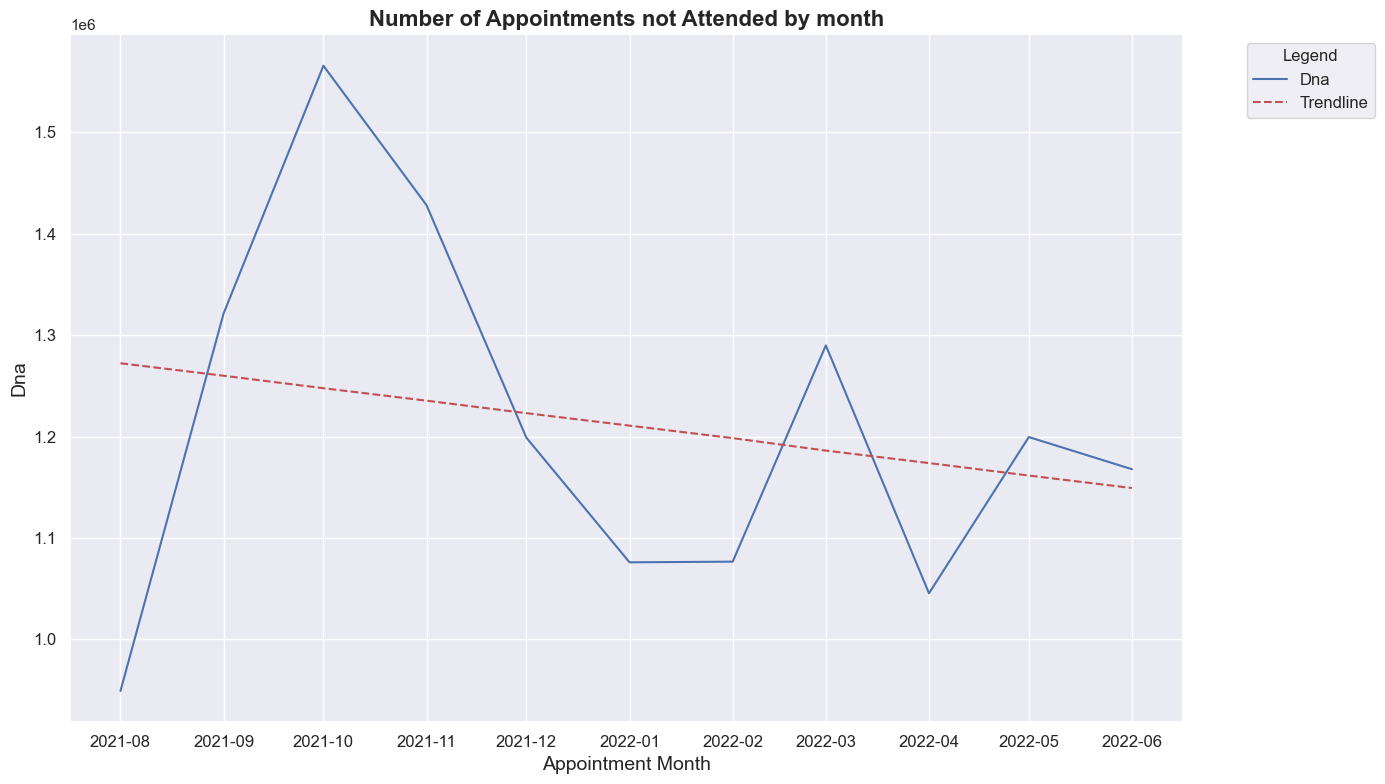

In [239]:
# Plot a graph to show the number of DNA per month.
generate_lineplot_with_trendline(ar_rp_month, x_axis='appointment_month', y_axis='dna', \
                                 title='Number of Appointments not Attended by month')

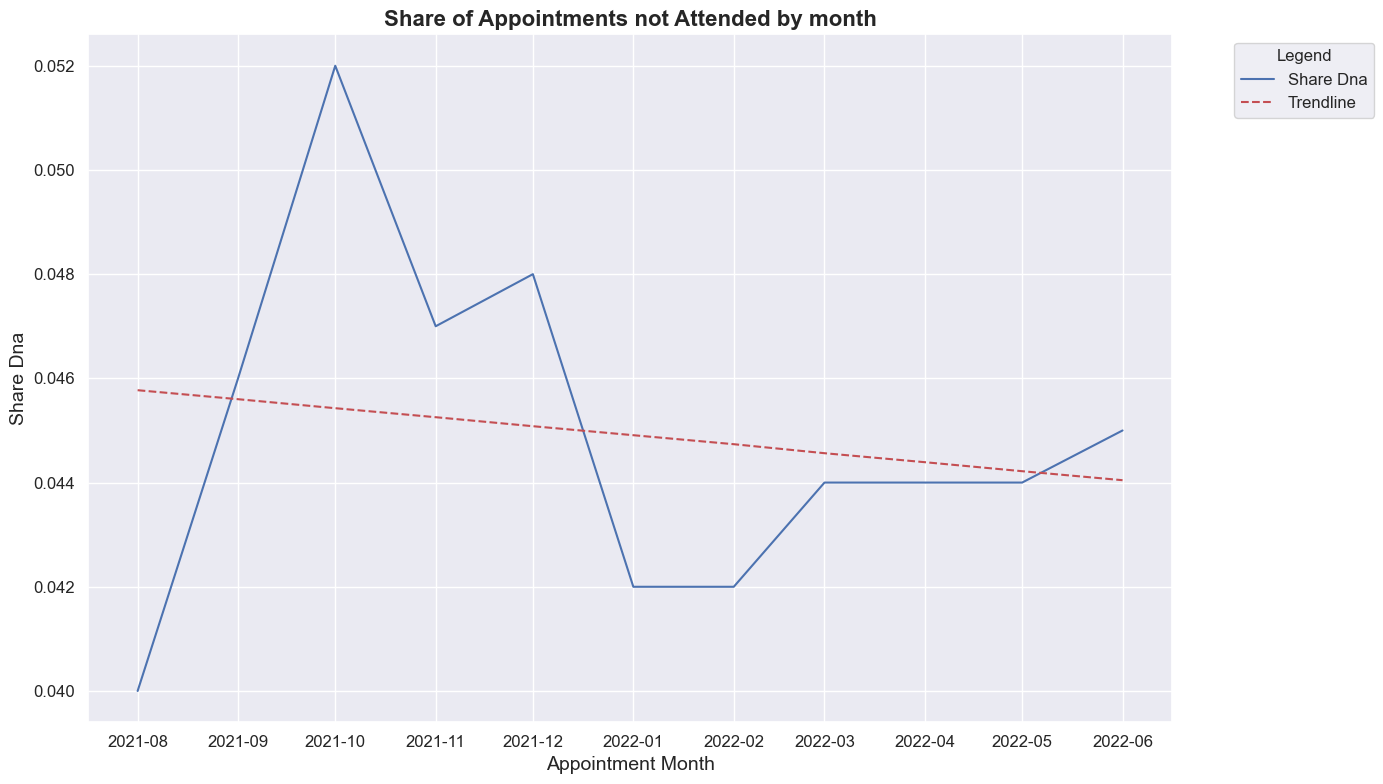

In [240]:
# Plot a graph to show the number of DNA per month.
generate_lineplot_with_trendline(ar_rp_month, x_axis='appointment_month', y_axis='share_dna', \
                                 title='Share of Appointments not Attended by month',
                                save_path='fig_share_dna_month')

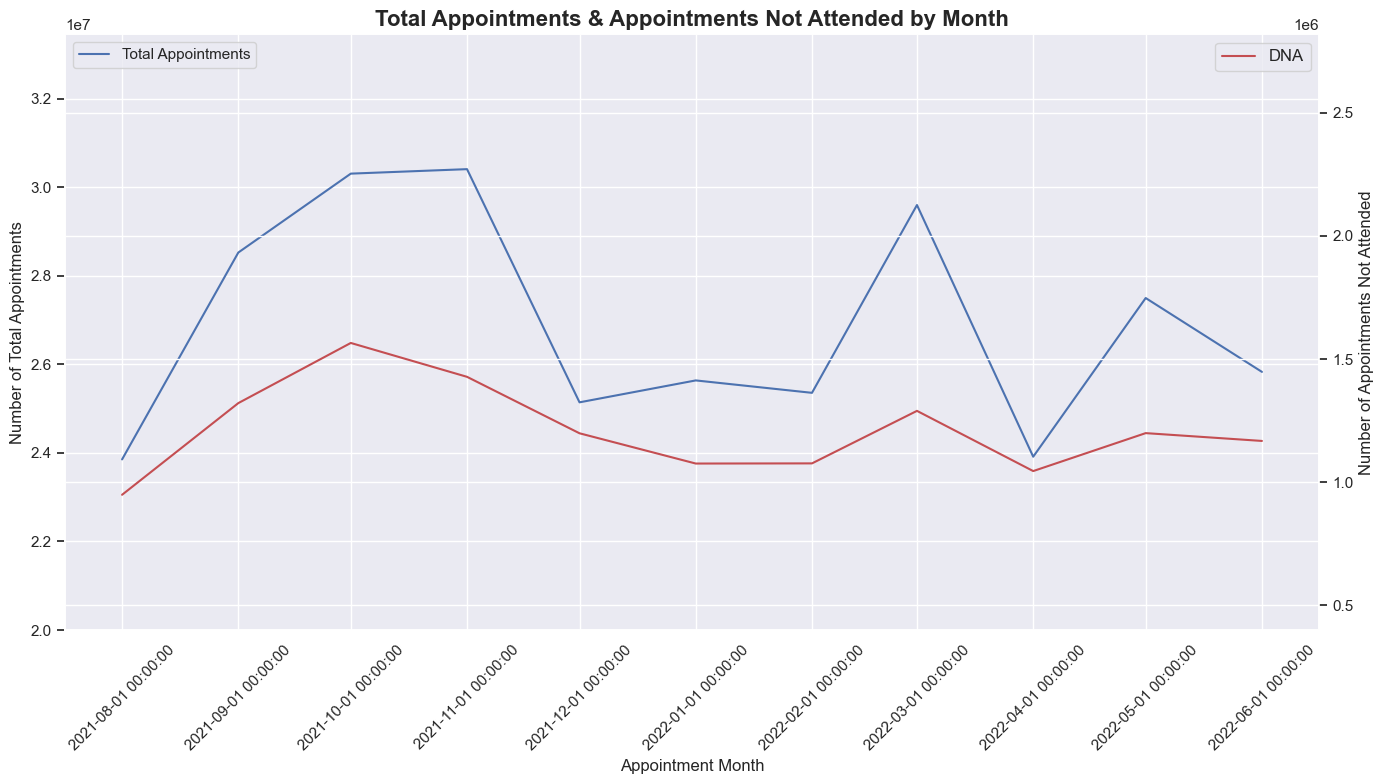

In [241]:
# Plot a graph to show the total number of appointments and the number of DNA per month.
# Use a chart with a secondary y-axis.

# Plot the number of total appointments.
sns.lineplot(x='appointment_month', y='total_appointments', data=ar_rp_month, label='Total Appointments', color='b')

# Show the legend
plt.legend(loc='upper left')
plt.ylim(20000000, ar_rp_month['total_appointments'].max() * 1.1)

# Create a secondary y-axis
ax = plt.gca() 
ax2 = plt.gca().twinx()

# Plot the number of DNA on the secondary y-axis.
sns.lineplot(x='appointment_month', y='dna', data=ar_rp_month, label='DNA', color='r', ax=ax2)

# Adding titles and labels.
plt.title('Total Appointments & Appointments Not Attended by Month', fontsize=16, fontweight='bold')
ax.set_xlabel('Appointment Month')
ax.set_ylabel('Number of Total Appointments')
ax2.set_ylabel('Number of Appointments Not Attended')

# Set figure size & style for seaborn.
sns.set(rc={'figure.figsize':(14, 8)})
sns.set_theme(style='darkgrid')
plt.rcParams['axes.titlesize'] = 14    # Title font size for axes
plt.rcParams['axes.labelsize'] = 14    # Label font size for axes
plt.rcParams['legend.fontsize'] = 12   # Legend font size
plt.rcParams['xtick.labelsize'] = 12   # x-axis tick label size
plt.rcParams['ytick.labelsize'] = 12   # y-axis tick label size

# Rotate the x-axis labels using the Axes object.
ax.set_xticklabels(ar_rp_month['appointment_month'], rotation=45)
plt.ylim(400000, ar_rp_month['dna'].max() * 1.8)

# Show the legend
plt.legend(loc='upper right')

# Save the plot.
plt.savefig('fig_appointment_dna_2021', dpi=500, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

> ***Observations*** <br>
> The line movement is comparable. <br>
> Share of DNA appears to be declining, although historically it is inceasing, as also reflected from January 2022.

**4.4.3. Are the number of appointments per patient and the share of DNA correlated?**

In [245]:
# Group registered patient data by ICB code.
ar_rp_icb = ar_fil_rp.groupby(['icb_ons_code'])[['attended', 'dna', 'unknown', \
                                                 'total_appointments', 'number_of_patients']].agg('sum'). \
                                                  reset_index()

# Add calculated columns for the share of total appointment per patient.
ar_rp_icb['appointments_per_patient'] = (ar_rp_icb['total_appointments']/ar_rp_icb['number_of_patients']).round(2)

# Add calculated columns for the share of 'did not attends' (DNA) per total appointments.
ar_rp_icb['share_dna'] = (ar_rp_icb['dna']/ar_rp_icb['total_appointments']).round(3)

# View the DataFrame.
ar_rp_icb.head()

icb_ons_code  attended     dna  unknown  total_appointments  \
0    E54000008  11897557  732856   619898            13250311   
1    E54000010   4794962  268625   262203             5325790   
2    E54000011   2360872  105274   102341             2568487   
3    E54000013   3947733  152036   153625             4253394   
4    E54000015   5810231  233322   198977             6242530   

   number_of_patients  appointments_per_patient  share_dna  
0            29805037                      0.44      0.055  
1            12857574                      0.41      0.050  
2             5697300                      0.45      0.041  
3             8883304                      0.48      0.036  
4            12960600                      0.48      0.037

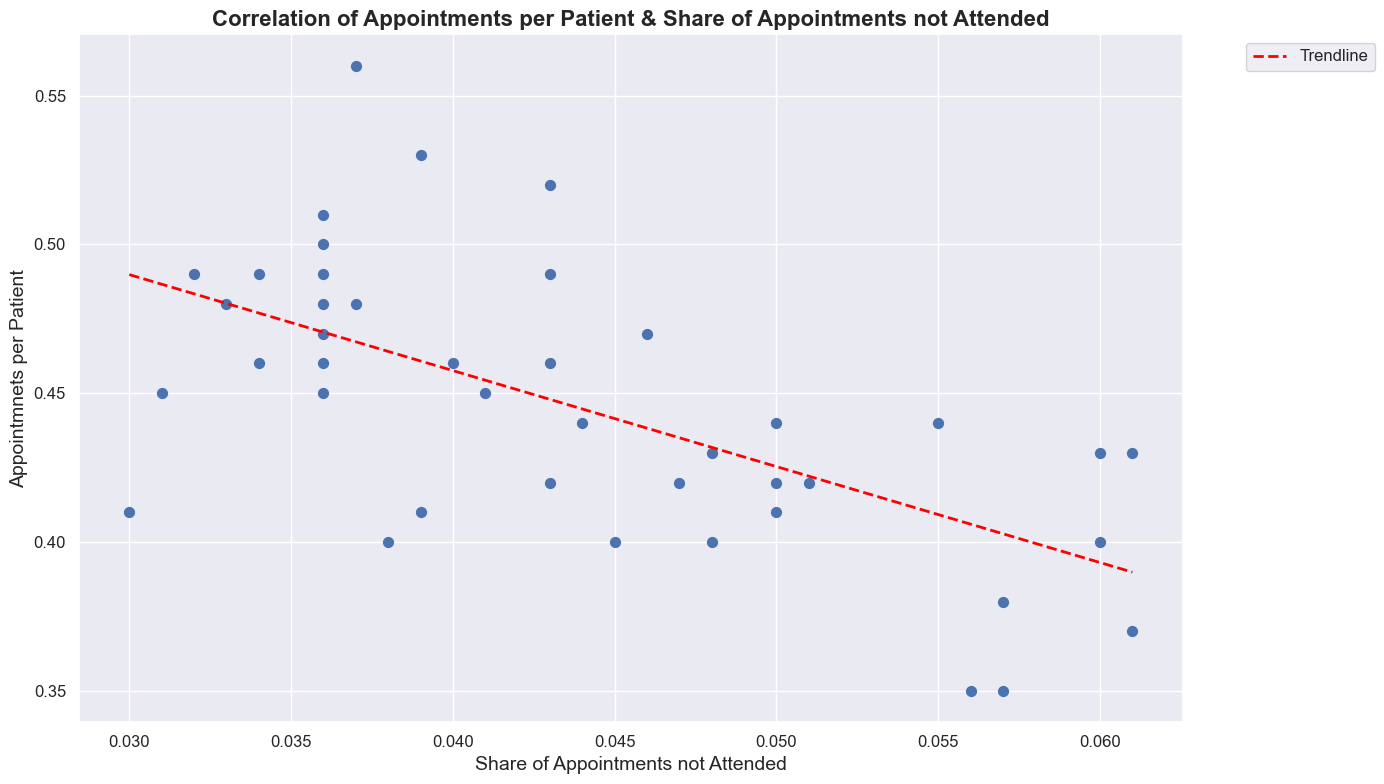

In [246]:
# Create the scatter plot to show the relationship between the number of appointments per patient 
# and the share of 'did not attends' (DNA) per total appointments.
ax = ar_rp_icb.plot.scatter(x='share_dna', y='appointments_per_patient', s=50)

# Calculate the trendline
z = np.polyfit(ar_rp_icb['share_dna'], ar_rp_icb['appointments_per_patient'], 1)  # 1 for linear
p = np.poly1d(z)

# Create trendline data
x_values = np.linspace(ar_rp_icb['share_dna'].min(), ar_rp_icb['share_dna'].max(), 100)
y_values = p(x_values)

# Plot trendline
plt.plot(x_values, y_values, color='red', linestyle='--', linewidth=2, label='Trendline')

# Add titles, labels, and legend
plt.title('Correlation of Appointments per Patient & Share of Appointments not Attended', fontsize=16, fontweight='bold')
plt.xlabel('Share of Appointments not Attended')
plt.ylabel('Appointmnets per Patient')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')

# Set figure size & style for seaborn.
sns.set(rc = {'figure.figsize':(14, 8)})
sns.set_theme(style='darkgrid')
plt.rcParams['axes.titlesize'] = 14    # Title font size for axes
plt.rcParams['axes.labelsize'] = 14    # Label font size for axes
plt.rcParams['legend.fontsize'] = 12   # Legend font size
plt.rcParams['xtick.labelsize'] = 12   # x-axis tick label size
plt.rcParams['ytick.labelsize'] = 12   # y-axis tick label size

# Save the chart.
plt.savefig('fig_correlation', dpi=500, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

> ***Observations*** <br>
> The data shows a correlation between the number of appointments per patient and the share of DNA, meaning greater availability of appointments per patient reduces the share of DNA.

**4.4.4. When were appointments booked and how does it impact the share of DNA?**

In [250]:
# Pivot the data to show appointment status as columns.
ar_fil_bt = ar_fil.pivot_table(index='book_time', columns='appointment_status', 
                                      values='count_of_appointments',  aggfunc='sum')

# Rename the columns in the pivot for consistency.
ar_fil_bt = ar_fil_bt.rename(columns={'Attended': 'attended', 'DNA': 'dna', 'Unknown': 'unknown'})

# Create manual order according to number of days.
custom_order = ['Same Day', '1 Day', '2 to 7 Days', '8  to 14 Days', '15  to 21 Days',  \
                '22  to 28 Days', 'More than 28 Days', 'Unknown / Data Quality']

# Reindex based on the specified order
ar_fil_bt = ar_fil_bt.reindex(custom_order)

# Add a calculated column for the total number of appointments.
ar_fil_bt['total_appointments'] = ar_fil_bt[['attended', 'dna', 'unknown']].sum(axis=1)

# Add a calculated column for share of DNA per total number of appointments.
ar_fil_bt['share_dna'] = (ar_fil_bt['dna']/ ar_fil_bt['total_appointments']).round(2)

# Add a calculated column for share of Unknown per total number of appointments.
ar_fil_bt['share_unknown'] = (ar_fil_bt['unknown']/ ar_fil_bt['total_appointments']).round(2)

# View the DataFrame.
ar_fil_bt

appointment_status       attended      dna  unknown  total_appointments  \
book_time                                                                 
Same Day                125798420  2289152  2889070           130976642   
1 Day                    24012214  1045140   815620            25872974   
2 to 7 Days              54639327  3695097  2399676            60734100   
8  to 14 Days            32528864  2869665  2108522            37507051   
15  to 21 Days           16512807  1568871  1372650            19454328   
22  to 28 Days            9480045   935245  1015294            11430584   
More than 28 Days         7546107   910122  1424309             9880538   
Unknown / Data Quality     139910     5092    45551              190553   

appointment_status      share_dna  share_unknown  
book_time                                         
Same Day                     0.02           0.02  
1 Day                        0.04           0.03  
2 to 7 Days                  0.06           0.04  
8  to 14 Days                0.08           0.06  
15  to 21 Days               0.08           0.07  
22  to 28 Days               0.08           0.09  
More than 28 Days            0.09           0.14  
Unknown / Data Quality       0.03           0.24

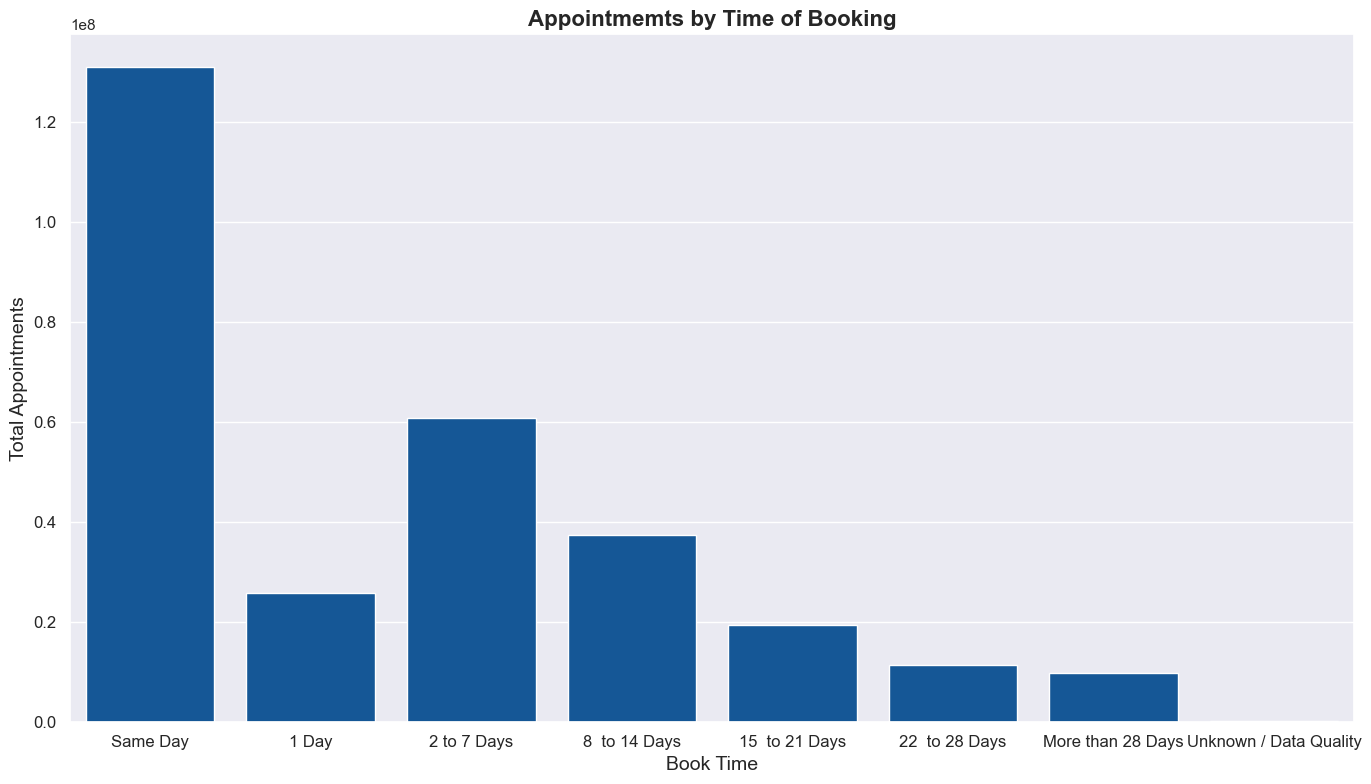

In [251]:
# Create a barplot of total appoitnments by the time of appointment booking.
generate_barplot(ar_fil_bt, x_axis='book_time', y_axis='total_appointments', \
                                 title='Appointmemts by Time of Booking', \
                                 save_path='fig_appointment_book_time.png')

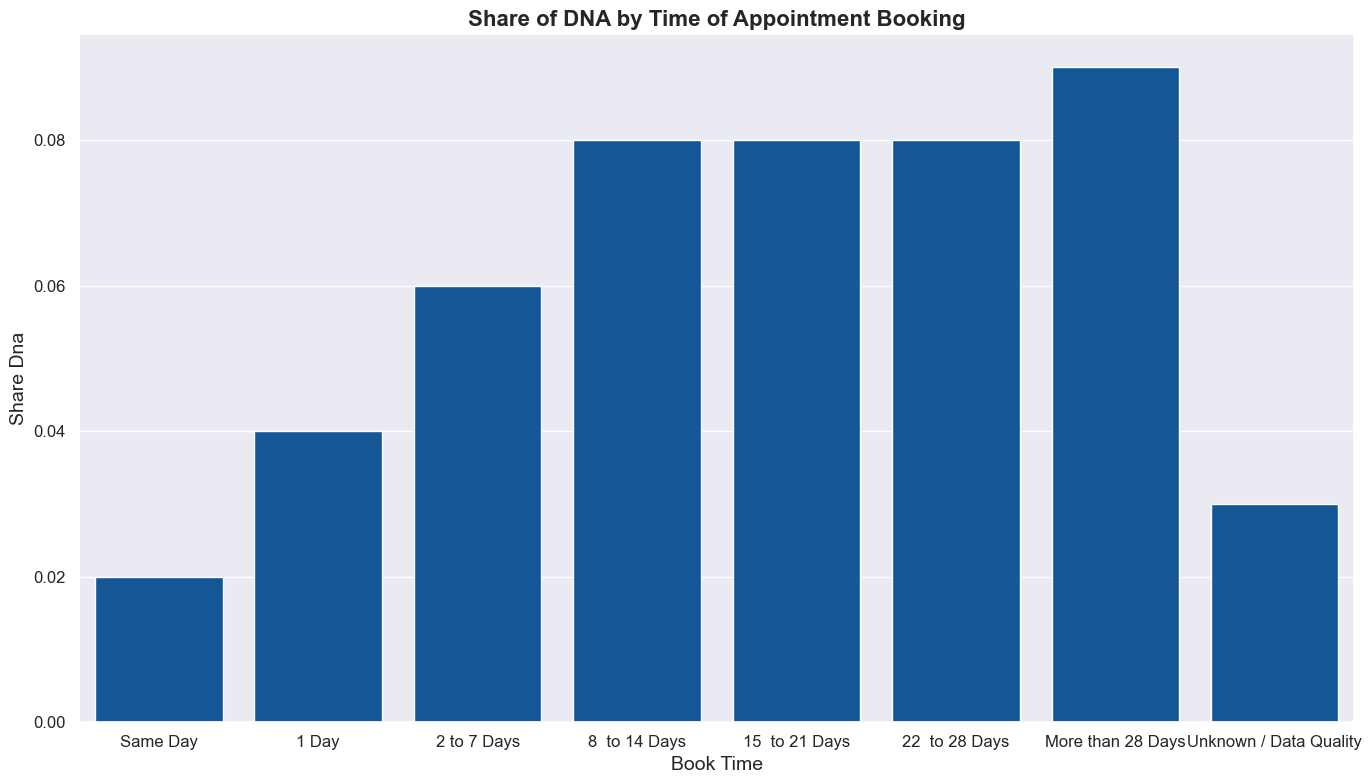

In [252]:
# Create a barplot of the share of DNA by the time of appointment booking.
generate_barplot(ar_fil_bt, x_axis='book_time', y_axis='share_dna', \
                                 title='Share of DNA by Time of Appointment Booking', \
                                 save_path='fig_dna_book_time.png')

> ***Observations*** <br>
> - 53% of appointments are booked for the same day or the day after.
> - The further in advance an appointment is booked, the higher the share of unknown.
> - The further in advance an appointment is booked, the higher the share of DNA.

**4.4.5. Which ICBs have the highest share of DNA?**

In [256]:
# View the DataFrame.
ar_rp_icb.head()

icb_ons_code  attended     dna  unknown  total_appointments  \
0    E54000008  11897557  732856   619898            13250311   
1    E54000010   4794962  268625   262203             5325790   
2    E54000011   2360872  105274   102341             2568487   
3    E54000013   3947733  152036   153625             4253394   
4    E54000015   5810231  233322   198977             6242530   

   number_of_patients  appointments_per_patient  share_dna  
0            29805037                      0.44      0.055  
1            12857574                      0.41      0.050  
2             5697300                      0.45      0.041  
3             8883304                      0.48      0.036  
4            12960600                      0.48      0.037

In [257]:
# Sort the DataFrame by 'DNA per Total Appointments' in descending order.
ar_rp_icb = ar_rp_icb.sort_values(by='share_dna', ascending=False)

# Filter the DataFrame for values greater than 5%.
ar_rp_icb_fil = ar_rp_icb[ar_rp_icb['share_dna'] > 0.05]

# Count the number of ICBs with a share above the threshold.
count_above_threshold = ar_rp_icb_fil.shape[0]

# View the DataFrame.
print("\nCount of ICBs with share of Share of DNA above 5%:", count_above_threshold, "of 42 ICBs")
ar_rp_icb_fil


Count of ICBs with share of Share of DNA above 5%: 9 of 42 ICBs


icb_ons_code  attended     dna  unknown  total_appointments  \
41    E54000062   6304923  426234   302480             7033637   
14    E54000029   8580355  584327   424209             9588891   
36    E54000057  12281729  837503   738668            13857900   
34    E54000055   5755631  381487   246628             6383746   
16    E54000031   6444408  406608   304014             7155030   
15    E54000030   7039643  448185   362342             7850170   
13    E54000028   6111747  381109   255102             6747958   
0     E54000008  11897557  732856   619898            13250311   
22    E54000039   4446216  251879   201413             4899508   

    number_of_patients  appointments_per_patient  share_dna  
41            16530995                      0.43      0.061  
14            25771479                      0.37      0.061  
36            34972557                      0.40      0.060  
34            14822858                      0.43      0.060  
16            18978201                      0.38      0.057  
15            22505980                      0.35      0.057  
13            19112488                      0.35      0.056  
0             29805037                      0.44      0.055  
22            11610039                      0.42      0.051

> ***Observations*** <br>
> 22% of ICBs have a share of DNA greater than 5%.

**4.4.6. How does the appointment mode impact the share of DNA?**

In [261]:
# Determine the total number of appointments per appointment mode and the percentage share of the total.
# Use defined function sum_data.
result_am = sum_data(ar_fil, 'appointment_mode')
result_am

total_appointments  percentage_share
appointment_mode                                      
Face-to-Face               183503587              62.0
Telephone                  100274881              33.9
Unknown                      8733661               3.0
Home Visit                   1991144               0.7
Video/Online                 1543497               0.5

In [262]:
# Pivot appointments_regional data to compare appointment_mode and appointment_status.
ar_fil_am = ar_fil.pivot_table(index='appointment_mode', columns='appointment_status', 
                                      values='count_of_appointments',  aggfunc='sum')

# Rename the columns in the pivot for consistency.
ar_fil_am = ar_fil_am.rename(columns={'Attended': 'attended', 'DNA': 'dna', 'Unknown': 'unknown'})

# Create manual order according to number of days.
custom_order = ['Face-to-Face', 'Home Visit', 'Video/Online', 'Telephone', 'Unknown']

# Reindex based on the specified order
ar_fil_am = ar_fil_am.reindex(custom_order)


# Add a calculated column for the total number of appointments.
ar_fil_am['total_appointments'] = ar_fil_am[['attended', 'dna', 'unknown']].sum(axis=1)

# Add a calculated column for share of DNA per total number of appointments and round to 2 decimals.
ar_fil_am['share_dna'] = (ar_fil_am['dna']/ ar_fil_am['total_appointments']).round(2)

# Add a calculated column for share of Unknown per total number of appointments and round to 2 decimals.
ar_fil_am['share_unknown'] = (ar_fil_am['unknown']/ ar_fil_am['total_appointments']).round(2)

# View the DataFrame.
ar_fil_am

appointment_status   attended       dna  unknown  total_appointments  \
appointment_mode                                                       
Face-to-Face        164524501  10762022  8217064           183503587   
Home Visit            1514429     78476   398239             1991144   
Video/Online          1416110     77528    49859             1543497   
Telephone            95363359   2094584  2816938           100274881   
Unknown               7839295    305774   588592             8733661   

appointment_status  share_dna  share_unknown  
appointment_mode                              
Face-to-Face             0.06           0.04  
Home Visit               0.04           0.20  
Video/Online             0.05           0.03  
Telephone                0.02           0.03  
Unknown                  0.04           0.07

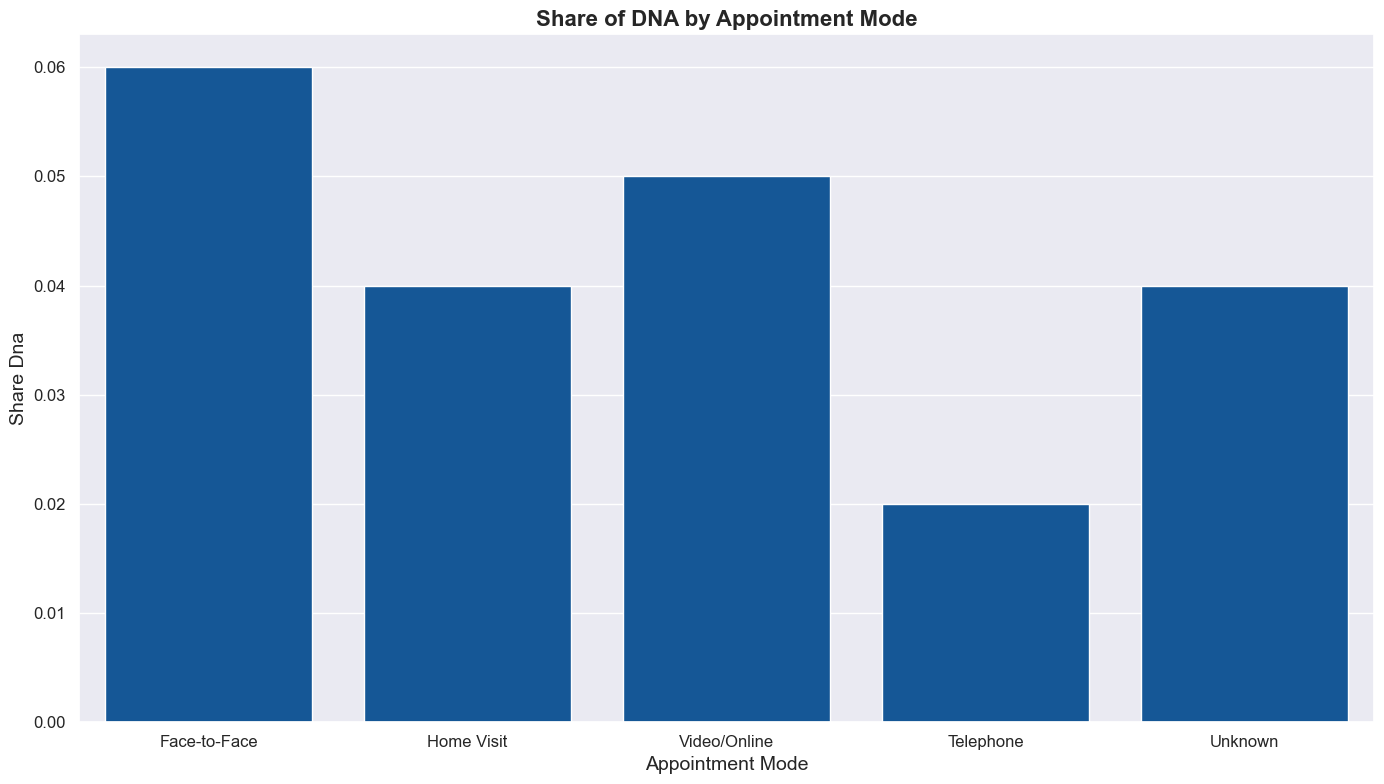

In [263]:
# Create a barplot of the share of DNA by the time of appointment booking.
generate_barplot(ar_fil_am, x_axis='appointment_mode', y_axis='share_dna', \
                                 title='Share of DNA by Appointment Mode', \
                                 save_path='fig_dna_mode.png')

> ***Observations*** <br>
> Face-to-Face appointments have the highest share of DNA, while Telephone appointments have the lowest.

**4.4.7. How does the healthcare professional (HCP) impact the share of DNA?**

In [267]:
# Determine the total number of appointments per hcp type and the percentage share of the total.
# Use defined function sum_data.
result_hcp = sum_data(ar_fil, 'hcp_type')
result_hcp

total_appointments  percentage_share
hcp_type                                                  
GP                             148371442              50.1
Other Practice staff           137982773              46.6
Unknown                          9692555               3.3

In [268]:
# Pivot appointments_regional data to compare appointment_mode and appointment_status.
ar_fil_hcp = ar_fil.pivot_table(index='hcp_type', columns='appointment_status', 
                                      values='count_of_appointments',  aggfunc='sum')

# Rename the columns in the pivot for consistency.
ar_fil_hcp = ar_fil_hcp.rename(columns={'Attended': 'attended', 'DNA': 'dna', 'Unknown': 'unknown'})

# Add a calculated column for the total number of appointments.
ar_fil_hcp['total_appointments'] = ar_fil_hcp[['attended', 'dna', 'unknown']].sum(axis=1)

# Add a calculated column for share of DNA per total number of appointments and round to 2 decimals.
ar_fil_hcp['share_dna'] = (ar_fil_hcp['dna']/ ar_fil_hcp['total_appointments']).round(2)

# Add a calculated column for share of Unknown per total number of appointments and round to 2 decimals.
ar_fil_hcp['share_unknown'] = (ar_fil_hcp['unknown']/ ar_fil_hcp['total_appointments']).round(2)

# View the DataFrame.
ar_fil_hcp

appointment_status     attended      dna  unknown  total_appointments  \
hcp_type                                                                
GP                    140189684  3845356  4336402           148371442   
Other Practice staff  121811567  9197617  6973589           137982773   
Unknown                 8656443   275411   760701             9692555   

appointment_status    share_dna  share_unknown  
hcp_type                                        
GP                         0.03           0.03  
Other Practice staff       0.07           0.05  
Unknown                    0.03           0.08

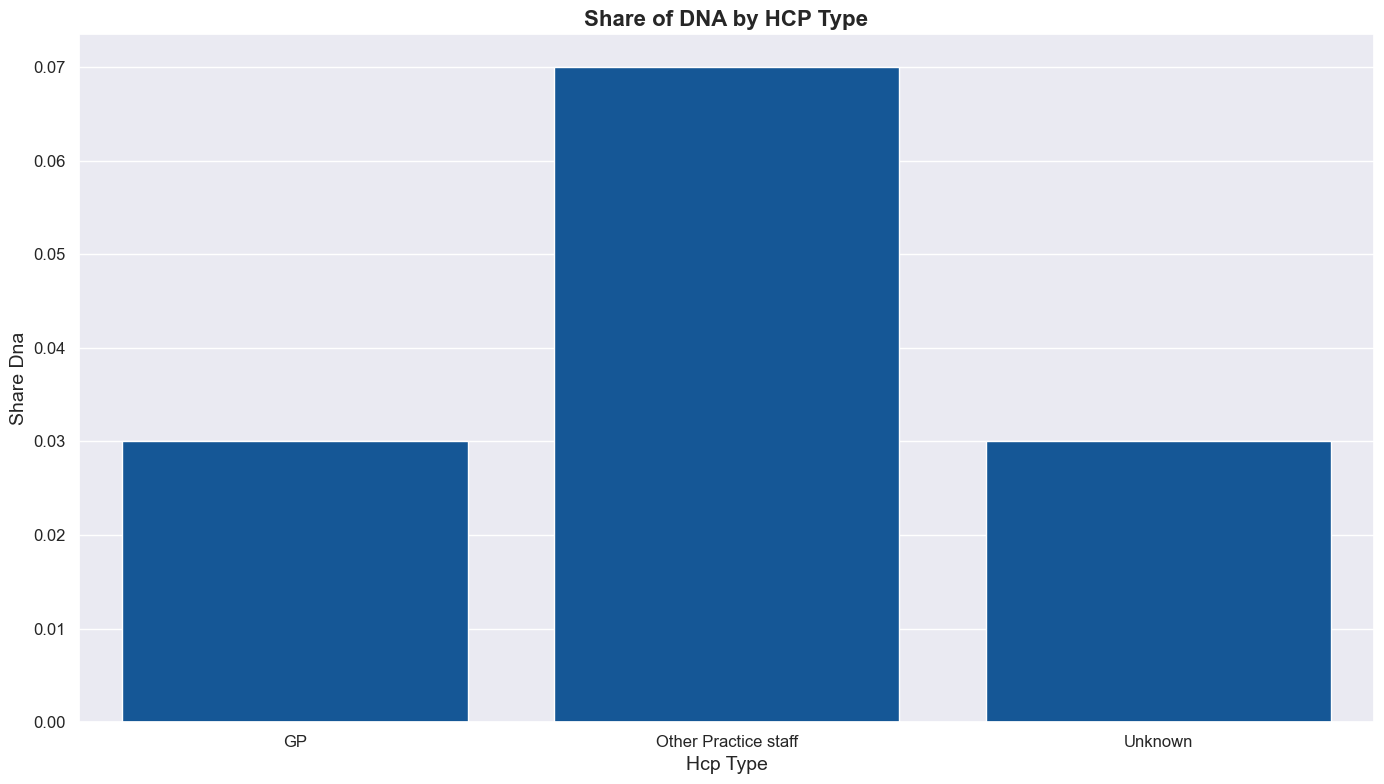

In [269]:
# Create a barplot of the share of DNA by the time of appointment booking.
generate_barplot(ar_fil_hcp, x_axis='hcp_type', y_axis='share_dna', \
                                 title='Share of DNA by HCP Type', \
                                 save_path='fig_dna_hcp.png')

> ***Observations*** <br>
> The share of DNA for appointments with Other Practice Staff is higher than for GPs.

### 4.5. Appointment Duration

Use appointment_duration DataFrame (ad).

**4.5.1. How many locations are there in the data set?**

In [275]:
# Determine the number of regions, ICBs and sub-ICBS in the ad DataFrame.
print('Number of regions: ', ad['region_ons_code'].nunique())
print('Number of Integrated Care Boards (ICB): ', ad['icb_ons_code'].nunique())
print('Number of Sub-Integrated Care Boards (Sub-ICB): ', ad['sub_icb_location_code'].nunique())

Number of regions:  7
Number of Integrated Care Boards (ICB):  42
Number of Sub-Integrated Care Boards (Sub-ICB):  106


**4.5.2. What are the ten locations with the highest number of appointment and records?**

In [277]:
# Determine the top ten locations based on number of appointments.
print(ad.groupby(['sub_icb_location_name'])['count_of_appointments'].sum().nlargest(10))

sub_icb_location_name
NHS North West London ICB - W2U3Z              6976986
NHS North East London ICB - A3A8R              5341883
NHS Kent and Medway ICB - 91Q                  5209641
NHS Hampshire and Isle Of Wight ICB - D9Y0V    4712737
NHS South East London ICB - 72Q                4360079
NHS Devon ICB - 15N                            4255338
NHS South West London ICB - 36L                4014321
NHS Black Country ICB - D2P2L                  3901431
NHS North Central London ICB - 93C             3795250
NHS Birmingham and Solihull ICB - 15E          3600087
Name: count_of_appointments, dtype: int64


In [278]:
# Determine the top ten locations based on records.
print(ad.groupby(['sub_icb_location_name'])['count_of_appointments'].count().nlargest(10))

sub_icb_location_name
NHS Bedfordshire Luton and Milton Keynes ICB - M1J4Y    1484
NHS Greater Manchester ICB - 14L                        1484
NHS Kent and Medway ICB - 91Q                           1484
NHS Norfolk and Waveney ICB - 26A                       1484
NHS North East London ICB - A3A8R                       1484
NHS North West London ICB - W2U3Z                       1484
NHS Devon ICB - 15N                                     1483
NHS Sussex ICB - 09D                                    1483
NHS West Yorkshire ICB - 15F                            1482
NHS Black Country ICB - D2P2L                           1480
Name: count_of_appointments, dtype: int64


**4.5.3. What is the actual duration of appointments?**

In [281]:
# Group appointments_regional (ar) by duration.
ad_ad = ad.groupby(['actual_duration'])['count_of_appointments'].sum().sort_values(ascending=False)

# Create manual order according to number of days.
custom_order = ['1-5 Minutes', '6-10 Minutes', '11-15 Minutes', '16-20 Minutes', '21-30 Minutes',  \
                '31-60 Minutes', 'Unknown / Data Quality']

# Reindex based on the specified order.
ad_ad = ad_ad.reindex(custom_order)

# Calculate the total sum of appointments.
total_sum = ad_ad.sum()

# Calculate the percentage for each duration.
percentage_ad = (ad_ad / total_sum) * 100

# Round the percentage values.
percentage_ad = percentage_ad.round(1)

# Combine the results into a new DataFrame.
pd.concat([ad_ad,percentage_ad], axis=1, keys=['total_appointments', 'percentage_share'])

total_appointments  percentage_share
actual_duration                                             
1-5 Minutes                       28600865              17.0
6-10 Minutes                      33800815              20.1
11-15 Minutes                     25160882              15.0
16-20 Minutes                     16004247               9.5
21-30 Minutes                     15026365               8.9
31-60 Minutes                      9103432               5.4
Unknown / Data Quality            40284086              24.0

In [282]:
# Pivot appointment_duration data to compare share of Unknown/ Data Quality by month.
ad_pivot_month = ad.pivot_table(index='appointment_month', columns='actual_duration', 
                                      values='count_of_appointments',  aggfunc='sum')

# Rename the columns in the pivot for consistency.
ad_pivot_month = ad_pivot_month.rename(columns={'1-5 Minutes': '1-5_minutes', '6-10 Minutes': '6-10_minutes',  \
                                                '11-15 Minutes': '11-15_minutes', '16-20 Minutes': '16-20_minutes',  \
                                                '21-30 Minutes': '21-30_minutes', '31-60 Minutes': '31-60_minutes',  \
                                                'Unknown / Data Quality': 'unknown'})

# Create manual order according to number of days.
custom_order = ['1-5_minutes', '6-10_minutes', '11-15_minutes', '16-20_minutes', '21-30_minutes',  \
                '31-60_minutes', 'unknown']

# Reorder the DataFrame
ad_pivot_month = ad_pivot_month[custom_order]

# Add a calculated column for the total number of appointments.
ad_pivot_month['total_appointments'] = ad_pivot_month[['1-5_minutes', '6-10_minutes', '11-15_minutes',  \
                                                       '16-20_minutes', '21-30_minutes', '31-60_minutes', \
                                                       'unknown']].sum(axis=1)

# Add a calculated column for share of Unknown per total number of appointments and round to 3 decimals.
ad_pivot_month['share_unknown'] = (ad_pivot_month['unknown']/ ad_pivot_month['total_appointments']).round(3)

# View the DataFrame.
ad_pivot_month

actual_duration    1-5_minutes  6-10_minutes  11-15_minutes  16-20_minutes  \
appointment_month                                                            
2021-12                4266686       4654000        3280132        2023774   
2022-01                3975252       4778719        3537308        2242739   
2022-02                3908364       4695914        3508227        2238822   
2022-03                4570114       5489184        4095290        2607518   
2022-04                3714437       4422913        3297961        2095851   
2022-05                4203478       5033645        3845162        2481613   
2022-06                3962534       4726440        3596802        2313930   

actual_duration    21-30_minutes  31-60_minutes  unknown  total_appointments  \
appointment_month                                                              
2021-12                  1885864        1163515  5579512            22853483   
2022-01                  2125583        1310454  5627141            23597196   
2022-02                  2116476        1295696  5588440            23351939   
2022-03                  2450292        1485532  6472072            27170002   
2022-04                  1958618        1177878  5281156            21948814   
2022-05                  2330326        1390177  6059540            25343941   
2022-06                  2159206        1280180  5676225            23715317   

actual_duration    share_unknown  
appointment_month                 
2021-12                    0.244  
2022-01                    0.238  
2022-02                    0.239  
2022-03                    0.238  
2022-04                    0.241  
2022-05                    0.239  
2022-06                    0.239

In [283]:
# Pivot appointments_regional data to compare share of Unknown/ Data Quality by sub_ICB.
ad_pivot_icb = ad.pivot_table(index=['sub_icb_location_ons_code','sub_icb_location_name'], columns='actual_duration', 
                                      values='count_of_appointments',  aggfunc='sum')

# Rename the columns in the pivot for consistency.
ad_pivot_icb = ad_pivot_icb.rename(columns={'1-5 Minutes': '1-5_minutes', '6-10 Minutes': '6-10_minutes',  \
                                            '11-15 Minutes': '11-15_minutes', '16-20 Minutes': '16-20_minutes',  \
                                            '21-30 Minutes': '21-30_minutes', '31-60 Minutes': '31-60_minutes',  \
                                            'Unknown / Data Quality': 'unknown'})

# Create manual order according to number of days.
custom_order = ['1-5_minutes', '6-10_minutes', '11-15_minutes', '16-20_minutes', '21-30_minutes',  \
                '31-60_minutes', 'unknown']

# Reorder the DataFrame
ad_pivot_icb = ad_pivot_icb[custom_order]

# Add a calculated column for the total number of appointments.
ad_pivot_icb['total_appointments'] = ad_pivot_icb[['1-5_minutes', '6-10_minutes', '11-15_minutes',  \
                                                   '16-20_minutes', '21-30_minutes', '31-60_minutes', \
                                                   'unknown']].sum(axis=1)

# Add a calculated column for share of Unknown per total number of appointments and round to 2 decimals.
ad_pivot_icb['share_unknown'] = (ad_pivot_icb['unknown']/ ad_pivot_icb['total_appointments']).round(3)

# Sort data by share of unknown of total appointments.
ad_pivot_icb = ad_pivot_icb.sort_values(by='share_unknown', ascending=False)

# Filter the DataFrame for values greater than 20% of the maximum
ad_pivot_filtered = ad_pivot_icb[ad_pivot_icb['share_unknown'] > 0.3]

# Count the number of sub_ICBs with a share above the threshold.
count_above_threshold = ad_pivot_filtered.shape[0]

# View the DataFrame.
print("\nCount of Sub-ICBs with share of entries 'Unknown / Data Quality' above 30%:", count_above_threshold, "of 106 Sub-ICBs")
ad_pivot_filtered


Count of Sub-ICBs with share of entries 'Unknown / Data Quality' above 30%: 20 of 106 Sub-ICBs


actual_duration                                                           1-5_minutes  \
sub_icb_location_ons_code sub_icb_location_name                                         
E38000226                 NHS Lancashire and South Cumbria ICB - 02M            56820   
E38000163                 NHS North East and North Cumbria ICB - 00N            44112   
E38000068                 NHS Cheshire and Merseyside ICB - 01F                 42523   
E38000091                 NHS Cheshire and Merseyside ICB - 01J                 65936   
E38000172                 NHS Cheshire and Merseyside ICB - 01X                 61600   
E38000240                 NHS North Central London ICB - 93C                   479241   
E38000187                 NHS Greater Manchester ICB - 02A                      56631   
E38000205                 NHS Greater Manchester ICB - 02H                     103319   
E38000208                 NHS Cheshire and Merseyside ICB - 12F                194321   
E38000028                 NHS Staffordshire and Stoke-on-Trent ICB - 04Y        57922   
E38000255                 NHS North East London ICB - A3A8R                    745899   
E38000015                 NHS Lancashire and South Cumbria ICB - 00R            70094   
E38000101                 NHS Cheshire and Merseyside ICB - 99A                232453   
E38000212                 NHS North East and North Cumbria ICB - 13T           198183   
E38000127                 NHS North East and North Cumbria ICB - 99C            89040   
E38000050                 NHS Lancashire and South Cumbria ICB - 01A           119752   
E38000194                 NHS Cheshire and Merseyside ICB - 02E                 85869   
E38000244                 NHS South East London ICB - 72Q                      636898   
E38000014                 NHS Lancashire and South Cumbria ICB - 00Q            71351   
E38000263                 NHS Greater Manchester ICB - 01Y                      86069   

actual_duration                                                           6-10_minutes  \
sub_icb_location_ons_code sub_icb_location_name                                          
E38000226                 NHS Lancashire and South Cumbria ICB - 02M             80817   
E38000163                 NHS North East and North Cumbria ICB - 00N             60721   
E38000068                 NHS Cheshire and Merseyside ICB - 01F                  51667   
E38000091                 NHS Cheshire and Merseyside ICB - 01J                  70902   
E38000172                 NHS Cheshire and Merseyside ICB - 01X                  71021   
E38000240                 NHS North Central London ICB - 93C                    554789   
E38000187                 NHS Greater Manchester ICB - 02A                       77742   
E38000205                 NHS Greater Manchester ICB - 02H                      123342   
E38000208                 NHS Cheshire and Merseyside ICB - 12F                 175674   
E38000028                 NHS Staffordshire and Stoke-on-Trent ICB - 04Y         72629   
E38000255                 NHS North East London ICB - A3A8R                     889047   
E38000015                 NHS Lancashire and South Cumbria ICB - 00R             92487   
E38000101                 NHS Cheshire and Merseyside ICB - 99A                 228621   
E38000212                 NHS North East and North Cumbria ICB - 13T            253805   
E38000127                 NHS North East and North Cumbria ICB - 99C            115098   
E38000050                 NHS Lancashire and South Cumbria ICB - 01A            182416   
E38000194                 NHS Cheshire and Merseyside ICB - 02E                 108332   
E38000244                 NHS South East London ICB - 72Q                       754005   
E38000014                 NHS Lancashire and South Cumbria ICB - 00Q             88471   
E38000263                 NHS Greater Manchester ICB - 01Y                      114662   

actual_duration                                             

In [284]:
# Exclude category 'Unknown / Data Quality'
excluded_category = 'Unknown / Data Quality'
ad_filtered = ad[ad['actual_duration'] != excluded_category]

# Group and pivot appointments_regional by month and ICB.
ad_ad_filtered = ad_filtered.groupby(['actual_duration'])['count_of_appointments'].sum().sort_values(ascending=False)

# Create manual order according to number of days.
custom_order = ['1-5 Minutes', '6-10 Minutes', '11-15 Minutes', '16-20 Minutes', '21-30 Minutes',  \
                '31-60 Minutes']

# Reindex based on the specified order
ad_ad_filtered = ad_ad_filtered.reindex(custom_order)

# Calculate the total sum of appointments.
total_sum = ad_ad_filtered.sum()

# Calculate the percentage for each service setting.
percentage_ad = ((ad_ad_filtered / total_sum) * 100).round(1)

# Combine the results into a new DataFrame.
ad_percentage = pd.concat([ad_ad_filtered, percentage_ad], axis=1, keys=['Total Appointments', 'Percentage Share (%)'])

# View the DataFrame.
ad_percentage

Total Appointments  Percentage Share (%)
actual_duration                                          
1-5 Minutes                28600865                  22.4
6-10 Minutes               33800815                  26.5
11-15 Minutes              25160882                  19.7
16-20 Minutes              16004247                  12.5
21-30 Minutes              15026365                  11.8
31-60 Minutes               9103432                   7.1

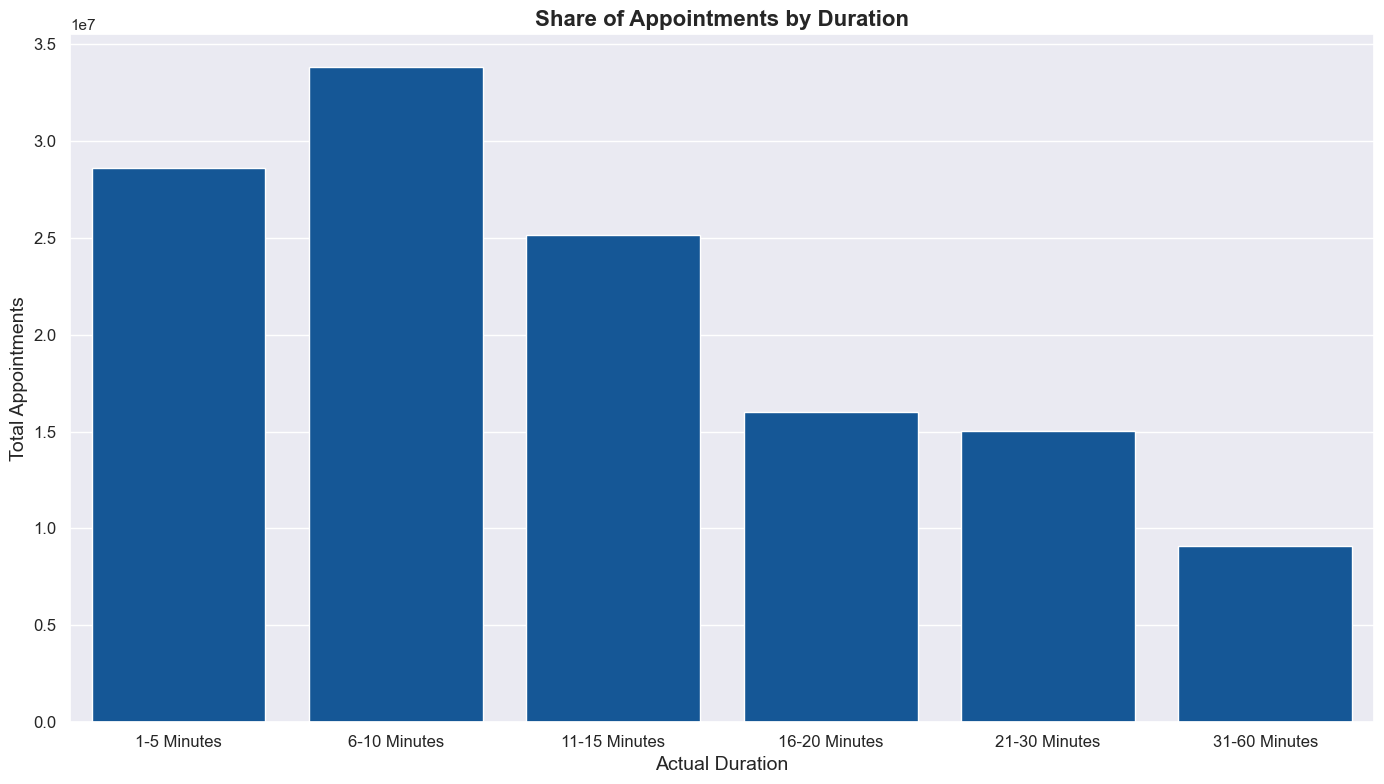

In [285]:
# Create a barplot of the share of appointments by duration.
generate_barplot(ad_percentage, x_axis='actual_duration', y_axis='Total Appointments', \
                                 title='Share of Appointments by Duration', \
                                 save_path='fig_appointment_duration.png')

> ***Observations*** <br>
> 24% of appointment have an unknown appointment mode and/or data quality issues. <br>
> The percentage of the category unknown does not vary significantly over time.
> 20 of 106 Sub-ICBS (19%) have a share of >30% of entries in unknown category.
> Almost 69% of appointments take less than 15 minutes.

### 4.6. Social Media Data from X (formerly Twitter)

Analyse and plot the hashtags by number of mentions using the tweets DataFrame (tweets).

In [290]:
# Create a new DataFrame to rank the top 30 hashtags in the dataset using tweet_full_text.
tweets_unique_text = tweets_unique[['tweet_full_text']]

# Create a variable (tags), and assign an empty list to it.
tags = []

# Loop through the messages and create a list of values containing the # symbol.
for tweet in tweets_unique_text['tweet_full_text']:
    # Split the tweet into words.
    words = tweet.split(' ')
    for word in words:
        if '#' in word:
            # Clean the tag: remove punctuation and convert to lowercase.
            clean_tag = re.sub(r'[^\w#]', '', word).lower()
            tags.append(clean_tag)
            
# Create a Series to count the values in the list.
tags_series = pd.Series(tags)

# Display the first 30 records using value_counts().
tag_counts = tags_series.value_counts()
print("\nTop 30 tags:")
print(tag_counts.head(30))


Top 30 tags:
#healthcare                    708
#health                         65
#job                            35
#strategy                       31
#pharmaceutical                 28
#ai                             27
#biotech                        25
#marketing                      25
#competitiveintelligence        25
#pharma                         25
#digitalhealth                  24
#medicine                       23
#medical                        21
#news                           17
#competitivemarketing           16
#hiring                         16
#technology                     15
#wellness                       15
#covid19                        15
#doctorofveterinarymedicine     14
#telemedicine                   13
#nursing                        13
#patientcare                    13
#hospitals                      12
#covid                          12
#doctor                         12
#mentalhealth                   12
#healthtech                     12
#innov

In [291]:
# Convert the Series to a DataFrame in preparation for visualisation.
tags_df = pd.DataFrame(tag_counts).reset_index()

# Rename the columns.
tags_df = tags_df.rename(columns={'index': 'word'})

# View the DataFrame.
tags_df

word  count
0             #healthcare    708
1                 #health     65
2                    #job     35
3               #strategy     31
4         #pharmaceutical     28
...                   ...    ...
1652        #stocktowatch      1
1653            #cheverly      1
1654           #kettering      1
1655  #medicalcertificate      1
1656               #csjmu      1

[1657 rows x 2 columns]

In [292]:
# Filter records where the count is larger than 15.
tags_df_top = tags_df[tags_df['count'] >= 15]

# View the DataFrame.
tags_df_top

word  count
0                #healthcare    708
1                    #health     65
2                       #job     35
3                  #strategy     31
4            #pharmaceutical     28
5                        #ai     27
6                   #biotech     25
7                 #marketing     25
8   #competitiveintelligence     25
9                    #pharma     25
10            #digitalhealth     24
11                 #medicine     23
12                  #medical     21
13                     #news     17
14     #competitivemarketing     16
15                   #hiring     16
16               #technology     15
17                 #wellness     15
18                  #covid19     15

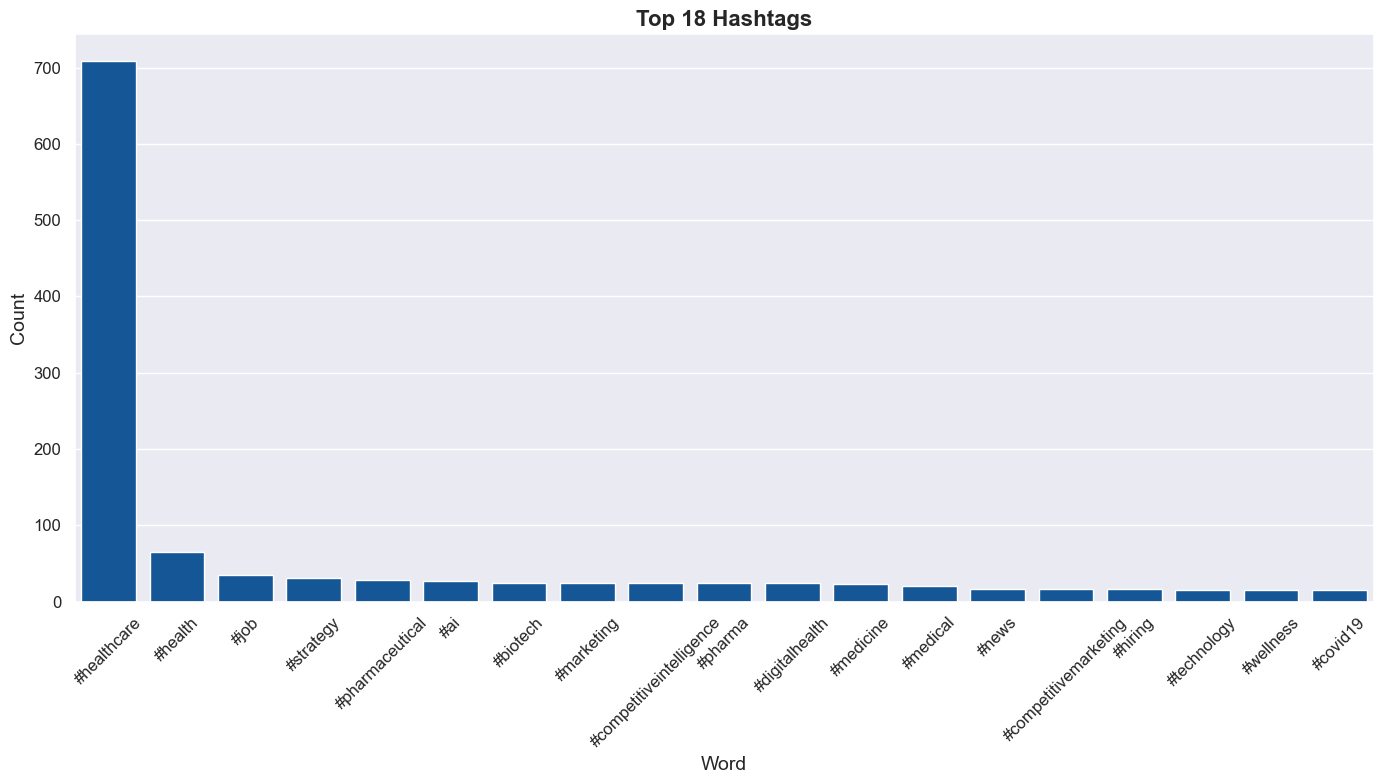

In [293]:
# Create a Seaborn barplot for the top 18 hastags (more than 15 mentions).
generate_barplot(tags_df_top, x_axis='word', y_axis='count', title='Top 18 Hashtags', rotate_xticks=True)

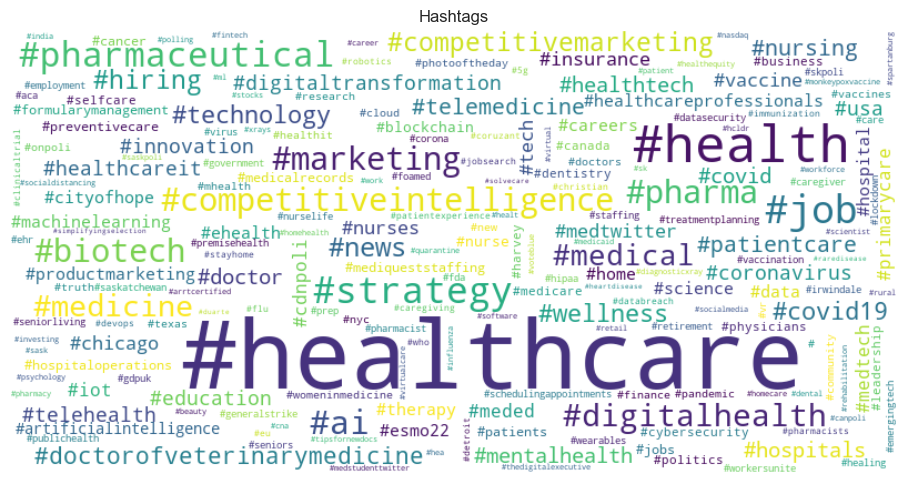

In [294]:
# Create a word cloud for all hastags.
# Prepare the word cloud data.
word_freq = {row['word']: row['count'] for index, row in tags_df.iterrows()}

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')        # Turn off the axis
plt.title('Hashtags')
plt.tight_layout()

# Save the wordcloud.
plt.savefig('fig_wordcloud_large.png', format='png', dpi=300, bbox_inches='tight')

# Display the wordcoud.
plt.show()

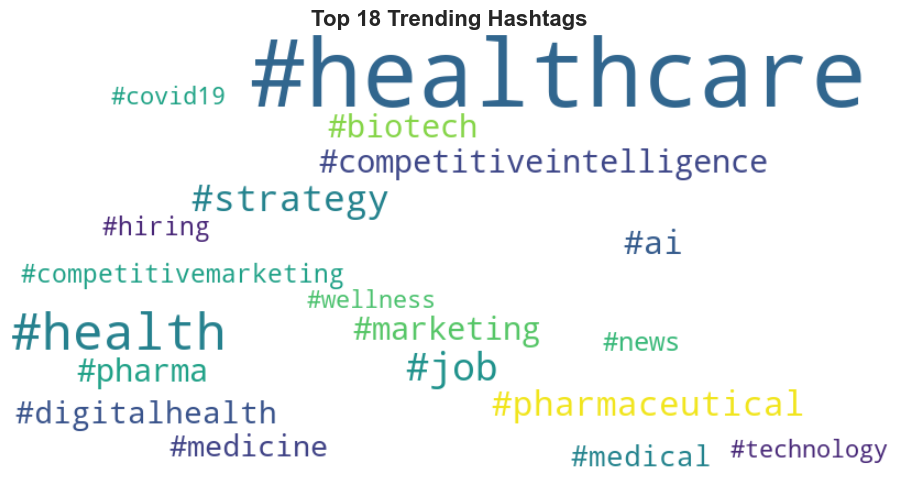

In [295]:
# Create a word cloud for the top 18 hastags (more than 15 mentions).
# Prepare the word cloud data.
word_freq = {row['word']: row['count'] for index, row in tags_df_top.iterrows()}

# Create the word cloud.
wordcloud = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1.0).generate_from_frequencies(word_freq)

# Plot the word cloud.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')         # Turn off the axis
plt.title('Top 18 Trending Hashtags',fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the wordcloud.
plt.savefig('fig_wordcloud_small.png', format='png', dpi=300, bbox_inches='tight')

# Display the wordcoud.
plt.show()

> ***Observations*** <br>
> #healthcare, #health, #job, #strategy and #pharmaceutical are the top 5 trending hashtags. <br>
> The #job suggests that X can be used to advertise jobs.

# 

## 5. Recommendations

### Investigate the main concerns posed by the NHS. 
1. Has there been adequate staff and capacity in the networks? <br>
2. What was the actual utilisation of resources?

### 5.1. Should the NHS start looking at increasing staff levels?

Use the appoinments_regional DataFrame (ar).

**5.1.1. Prepare the data**

In [304]:
# Use only the DataFrame from 2021-08 onwards.
ar_fil

icb_ons_code appointment_month appointment_status hcp_type  \
3652      E54000034           2021-08           Attended       GP   
3653      E54000034           2021-08           Attended       GP   
3654      E54000034           2021-08           Attended       GP   
3655      E54000034           2021-08           Attended       GP   
3656      E54000034           2021-08           Attended       GP   
...             ...               ...                ...      ...   
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode          book_time  count_of_appointments  
3652       Face-to-Face              1 Day                   6553  
3653       Face-to-Face     15  to 21 Days                   2390  
3654       Face-to-Face        2 to 7 Days                  10547  
3655       Face-to-Face     22  to 28 Days                    937  
3656       Face-to-Face      8  to 14 Days                   4961  
...                 ...                ...                    ...  
596816          Unknown        2 to 7 Days                     21  
596817          Unknown     22  to 28 Days                      8  
596818          Unknown      8  to 14 Days                     28  
596819          Unknown  More than 28 Days                     17  
596820          Unknown           Same Day                     10  

[223418 rows x 7 columns]

In [305]:
# Create an aggregated data set to review appointment status and mode.
ar_agg_fil = ar_fil.groupby(['appointment_month', 'hcp_type', 'appointment_status', 'appointment_mode', \
                             'book_time'])['count_of_appointments']. \
                            sum().reset_index(name='count_of_appointments')
# View the DataFrame.
ar_agg_fil

appointment_month hcp_type appointment_status appointment_mode  \
0              2021-08       GP           Attended     Face-to-Face   
1              2021-08       GP           Attended     Face-to-Face   
2              2021-08       GP           Attended     Face-to-Face   
3              2021-08       GP           Attended     Face-to-Face   
4              2021-08       GP           Attended     Face-to-Face   
...                ...      ...                ...              ...   
3749           2022-06  Unknown            Unknown          Unknown   
3750           2022-06  Unknown            Unknown          Unknown   
3751           2022-06  Unknown            Unknown          Unknown   
3752           2022-06  Unknown            Unknown          Unknown   
3753           2022-06  Unknown            Unknown     Video/Online   

                   book_time  count_of_appointments  
0                      1 Day                 507835  
1             15  to 21 Days                 194726  
2                2 to 7 Days                 959486  
3             22  to 28 Days                 102111  
4              8  to 14 Days                 398772  
...                      ...                    ...  
3749           8  to 14 Days                   5494  
3750       More than 28 Days                   5115  
3751                Same Day                   1914  
3752  Unknown / Data Quality                     53  
3753             2 to 7 Days                      1  

[3754 rows x 6 columns]

In [306]:
# Determine the total number of appointments per month.
ar_month_fil = ar_agg_fil.groupby(['appointment_month'])['count_of_appointments']. \
                            sum().reset_index(name='count_of_appointments')

ar_month_fil

appointment_month  count_of_appointments
0            2021-08               23852171
1            2021-09               28522501
2            2021-10               30303834
3            2021-11               30405070
4            2021-12               25140776
5            2022-01               25635474
6            2022-02               25355260
7            2022-03               29595038
8            2022-04               23913060
9            2022-05               27495508
10           2022-06               25828078

**5.1.2. Calculate the utilisation rate**

Utilisation Rate is calculated by dividing the actual appointments per workday by the average number of available appointments per workday. <br>
The NHS suggests the average number of available appointments per workday is 1,200,000. <br>
The number of appointments per workday are calculated by dividing the monthly total number of appointments by the number of workdays. <br>
The number of workdays per month are taken from the workdays DataFrame (wd).

In [310]:
# Merge the aggregated appointments_regional (ar_month_fil) with the weekdays per month (wd).
ar_wd_fil = pd.merge(ar_month_fil, wd,
                           how='left', on='appointment_month')

# Add a column to caculate the number of appointments per workday.
ar_wd_fil['appointments_per_workday'] = (ar_wd_fil['count_of_appointments']/ ar_wd_fil['number_of_workdays']).round(0).astype(int)

# Add a column to calculate the average utilisation of services.
# NHS average available appointments per workday is 1,200,000.
ar_wd_fil['utilisation'] = (ar_wd_fil['appointments_per_workday']/1200000).round(2)

# View the DataFrame.
ar_wd_fil

appointment_month  count_of_appointments  number_of_workdays  \
0            2021-08               23852171                  21   
1            2021-09               28522501                  22   
2            2021-10               30303834                  21   
3            2021-11               30405070                  22   
4            2021-12               25140776                  21   
5            2022-01               25635474                  20   
6            2022-02               25355260                  20   
7            2022-03               29595038                  23   
8            2022-04               23913060                  19   
9            2022-05               27495508                  21   
10           2022-06               25828078                  20   

    appointments_per_workday  utilisation  
0                    1135818         0.95  
1                    1296477         1.08  
2                    1443040         1.20  
3                    1382049         1.15  
4                    1197180         1.00  
5                    1281774         1.07  
6                    1267763         1.06  
7                    1286741         1.07  
8                    1258582         1.05  
9                    1309310         1.09  
10                   1291404         1.08

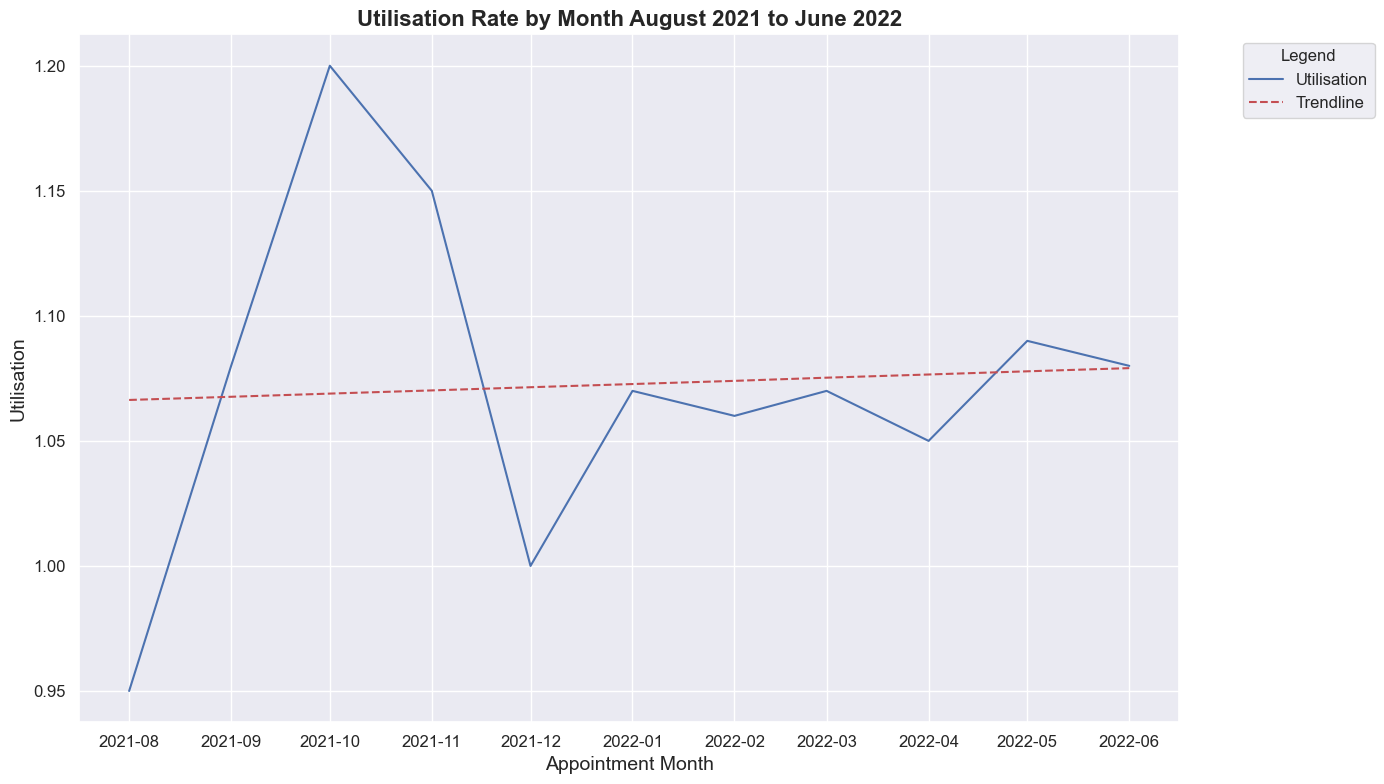

In [311]:
# Create a lineplot for the utilisation rate per month.
generate_lineplot_with_trendline(ar_wd_fil, x_axis='appointment_month', y_axis='utilisation', \
                                 title='Utilisation Rate by Month August 2021 to June 2022', \
                                 save_path='fig_utilisation_month_2021')

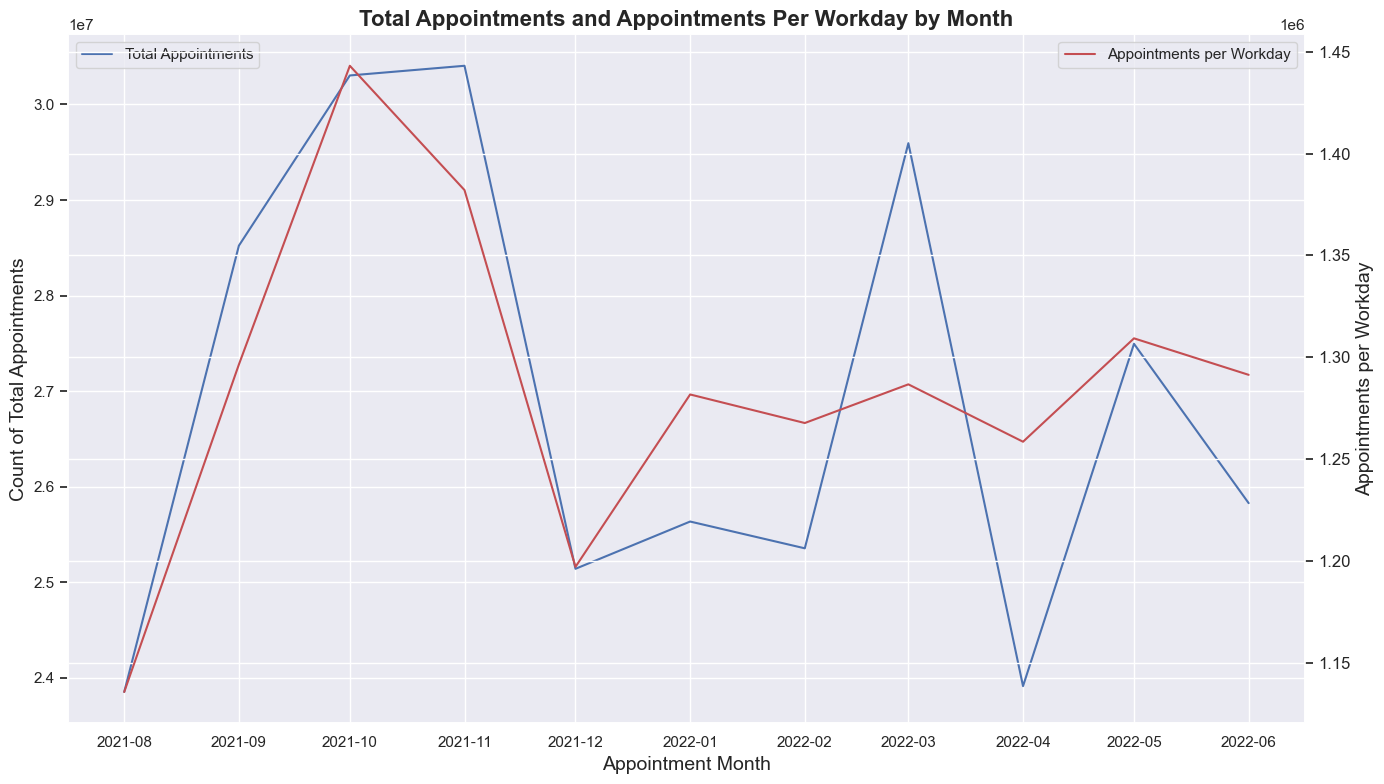

In [312]:
# Create a lineplot with a seconday y-axis for total appointments and appointments per workday.

# Set figure size & style for seaborn.
sns.set_theme(style='darkgrid')
sns.set(rc={'figure.figsize':(14, 8)})

# Plot total appointments.
sns.lineplot(x='appointment_month', y='count_of_appointments', data=ar_wd_fil, label='Total Appointments', color='b')

# Show the legend.
plt.legend(loc='upper left')

# Create a secondary y-axis.
ax = plt.gca() 
ax2 = plt.gca().twinx()

# Plot appointments per workday on the secondary y-axis.
sns.lineplot(x='appointment_month', y='appointments_per_workday', data=ar_wd_fil, label='Appointments per Workday', color='r', ax=ax2)

# Adding titles and labels.
plt.title('Total Appointments and Appointments Per Workday by Month', fontsize=16, fontweight='bold')
ax.set_xlabel('Appointment Month',  fontsize=14)
ax.set_ylabel('Count of Total Appointments',  fontsize=14)
ax2.set_ylabel('Appointments per Workday',  fontsize=14)

# Format axis.
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=12)

# Format legend.
plt.legend(loc='upper right')

# Show the plot.
plt.tight_layout()
plt.show()

**5.1.3. Calculate the utilisation rate using historical date from 2020 onwards**

In [315]:
# Determine the total number of appointments per month.
ar_month = ar.groupby(['appointment_month'])['count_of_appointments']. \
                            sum().reset_index()

ar_month.head()

appointment_month  count_of_appointments
0           2020-01               27199296
1           2020-02               24104621
2           2020-03               24053468
3           2020-04               16007881
4           2020-05               16417212

In [316]:
# Merge the aggregated appointments_regional (ar_month) with the weekdays per month (wd).
ar_wd = pd.merge(ar_month, wd,
                           how='left', on='appointment_month')

# Add a column to calculate the number of appointments per workday and round the decimal places.
ar_wd['appointments_per_workday'] = (ar_wd['count_of_appointments']/ ar_wd['number_of_workdays']).round(0)

# Add a column to calculate the average utilisation of services and round the decimal places.
# NHS data of an average of 1,200,000 appointments per workday.
ar_wd['utilisation'] = (ar_wd['appointments_per_workday']/1200000).round(2)

# View the DataFrame.
ar_wd.head()

appointment_month  count_of_appointments  number_of_workdays  \
0           2020-01               27199296                  22   
1           2020-02               24104621                  20   
2           2020-03               24053468                  22   
3           2020-04               16007881                  20   
4           2020-05               16417212                  19   

   appointments_per_workday  utilisation  
0                 1236332.0         1.03  
1                 1205231.0         1.00  
2                 1093339.0         0.91  
3                  800394.0         0.67  
4                  864064.0         0.72

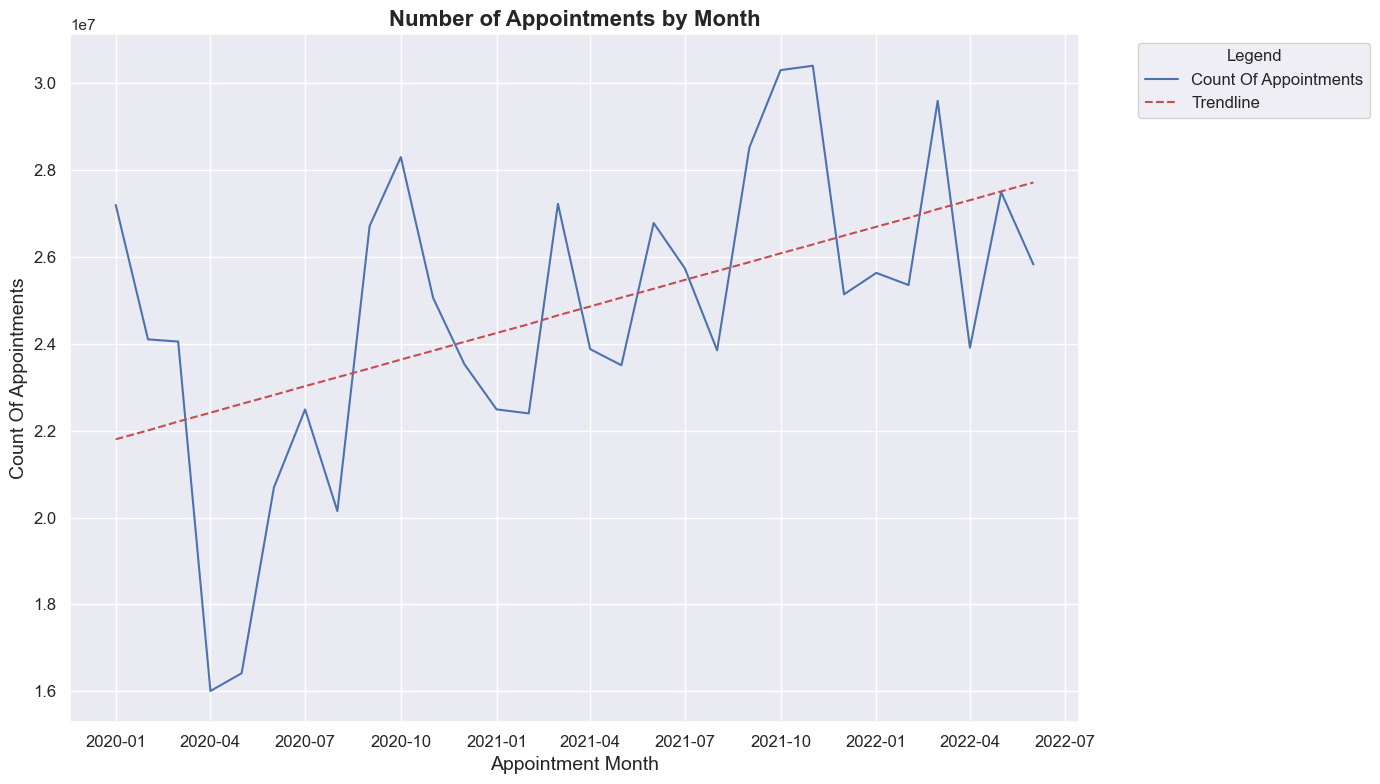

In [317]:
# Create a lineplot for the total appointments per month.
generate_lineplot_with_trendline(ar_wd, x_axis='appointment_month', y_axis='count_of_appointments', \
                               title='Number of Appointments by Month')

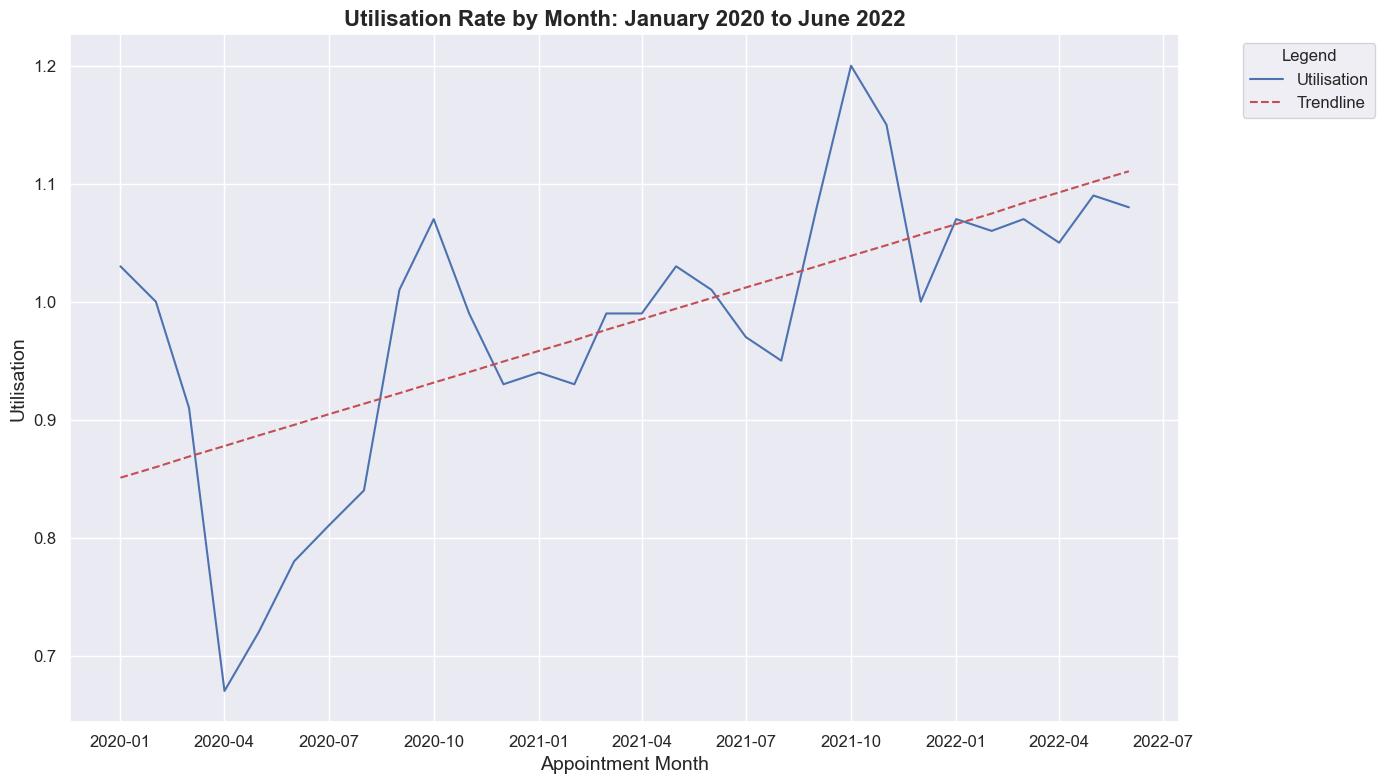

In [318]:
# Create a lineplot for the utilisation rate per month.
generate_lineplot_with_trendline(ar_wd, x_axis='appointment_month', y_axis='utilisation', \
                                 title='Utilisation Rate by Month: January 2020 to June 2022', ylim=None, \
                                 save_path='fig_utilisation_month')

> ***Observations*** <br>
> Utilisation Rate > 1 means there is more demand than average monthly capacity. <br>

### 5.2. Are there significant changes in whether visits are attended or not?

Combine the analysis on utilisation rate and DNA.

In [323]:
# Merge the appointments_regional by month and ICB (ar_as_pivot) with weekdays (wd).
ar_wd_as = pd.merge(ar_as_pivot, wd,
                    how='left', on='appointment_month')

# Add a column to calculate the share of DNA and round the decimal places.
ar_wd_as['share_dna'] = (ar_wd_as['dna']/ ar_wd_as['total_appointments']).round(3)

# Add a column to calculate the number of appointments per workday and round the decimal places.
ar_wd_as['appointments_per_workday'] = (ar_wd_as['total_appointments']/ ar_wd_as['number_of_workdays']).round(0)

# Add a column to calculate the average utilisation of services and round the decimal places.
# NHS data of an average of 1,200,000 appointments per workday.
ar_wd_as['utilisation'] = (ar_wd_as['appointments_per_workday']/1200000).round(2)

# Add a column to calculate the number of appointments without DNA and round the decimal places.
ar_wd_as['total_appointments_excl_dna'] = (ar_wd_as['total_appointments'] - ar_wd_as['dna'])

# Add a column to calculate the number of appointments per workday without DNA and round the decimal places.
ar_wd_as['appointments_per_workday_excl_dna'] = (ar_wd_as['total_appointments_excl_dna']/ ar_wd_as['number_of_workdays']).round(0)

# Add a column to calculate the average utilisation of services and round the decimal places without 
# NHS data of an average of 1,200,000 appointments per workday.
ar_wd_as['utilisation_excl_dna'] = (ar_wd_as['appointments_per_workday_excl_dna']/1200000).round(2)

# View the DataFrame.
ar_wd_as.head()

appointment_month  attended      dna  unknown  total_appointments  \
0           2020-01  24538291  1298269  1362736            27199296   
1           2020-02  21640067  1215154  1249400            24104621   
2           2020-03  20718865  1166314  2168289            24053468   
3           2020-04  13982824   478766  1546291            16007881   
4           2020-05  14962850   449057  1005305            16417212   

   number_of_workdays  share_dna  appointments_per_workday  utilisation  \
0                  22      0.048                 1236332.0         1.03   
1                  20      0.050                 1205231.0         1.00   
2                  22      0.048                 1093339.0         0.91   
3                  20      0.030                  800394.0         0.67   
4                  19      0.027                  864064.0         0.72   

   total_appointments_excl_dna  appointments_per_workday_excl_dna  \
0                     25901027                          1177319.0   
1                     22889467                          1144473.0   
2                     22887154                          1040325.0   
3                     15529115                           776456.0   
4                     15968155                           840429.0   

   utilisation_excl_dna  
0                  0.98  
1                  0.95  
2                  0.87  
3                  0.65  
4                  0.70

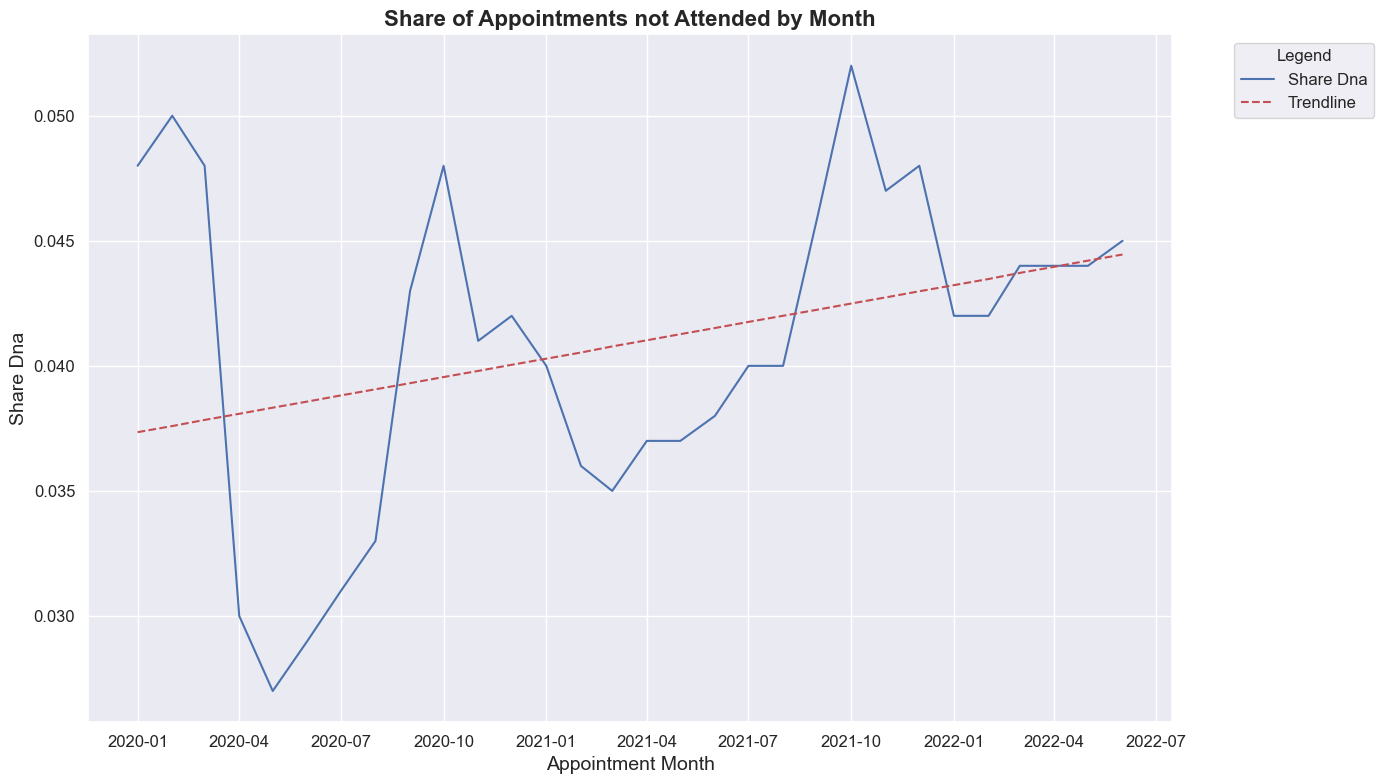

In [324]:
# Create a lineplot for the share of appointments not attended.
generate_lineplot_with_trendline(ar_wd_as, x_axis='appointment_month', y_axis='share_dna',  \
                                 title='Share of Appointments not Attended by Month', \
                                 save_path='fig_dna_share')

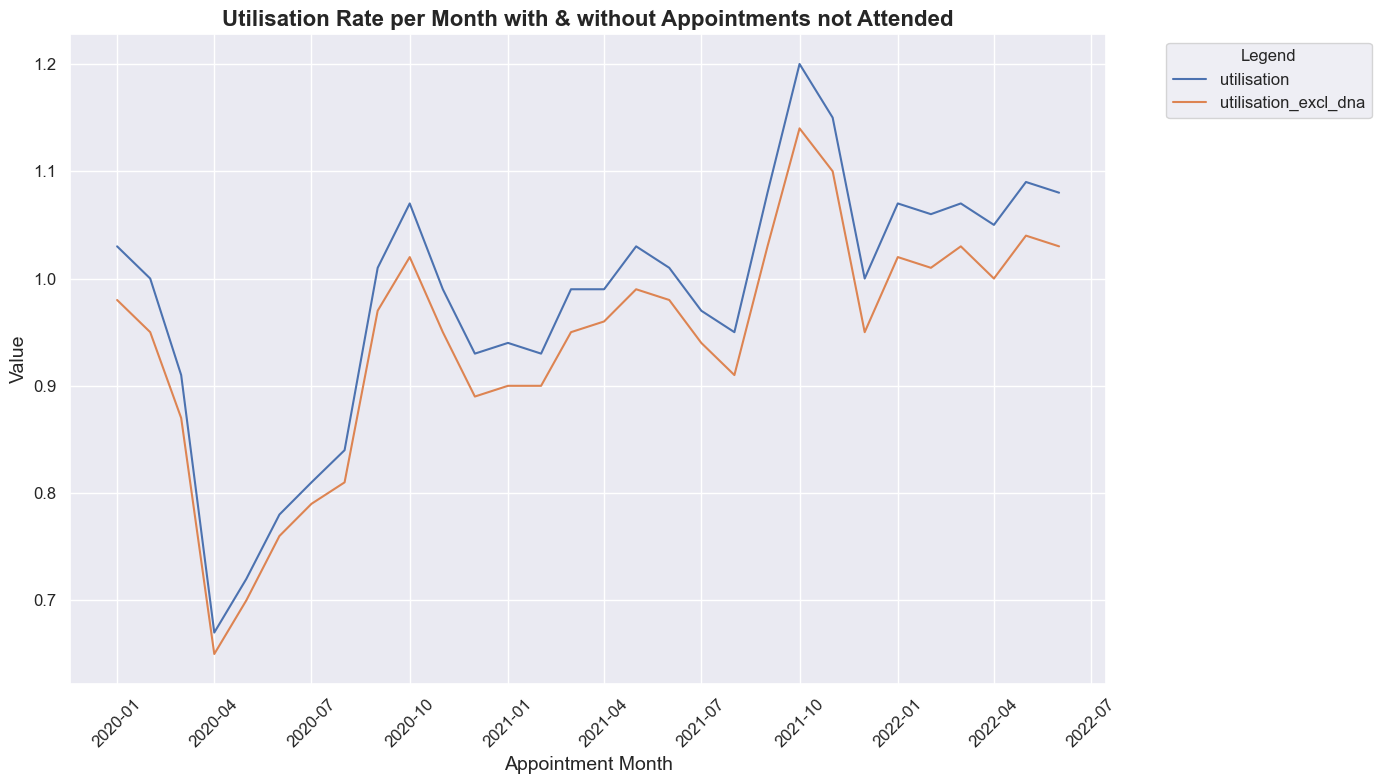

In [325]:
# Reshape the DataFrame for 2 utilisation lines.
ar_wd_as_ut = ar_wd_as.melt(id_vars='appointment_month', 
                         value_vars=['utilisation', 'utilisation_excl_dna'],
                         var_name='Metric', 
                         value_name='Value')

# Create a multi lineplot to show utilisation with and without DNA.
generate_multi_lineplot(ar_wd_as_ut, x_axis='appointment_month', y_axis= 'Value', hue='Metric', \
                        title='Utilisation Rate per Month with & without Appointments not Attended', \
                        save_path='fig_utilisation_dna_month')

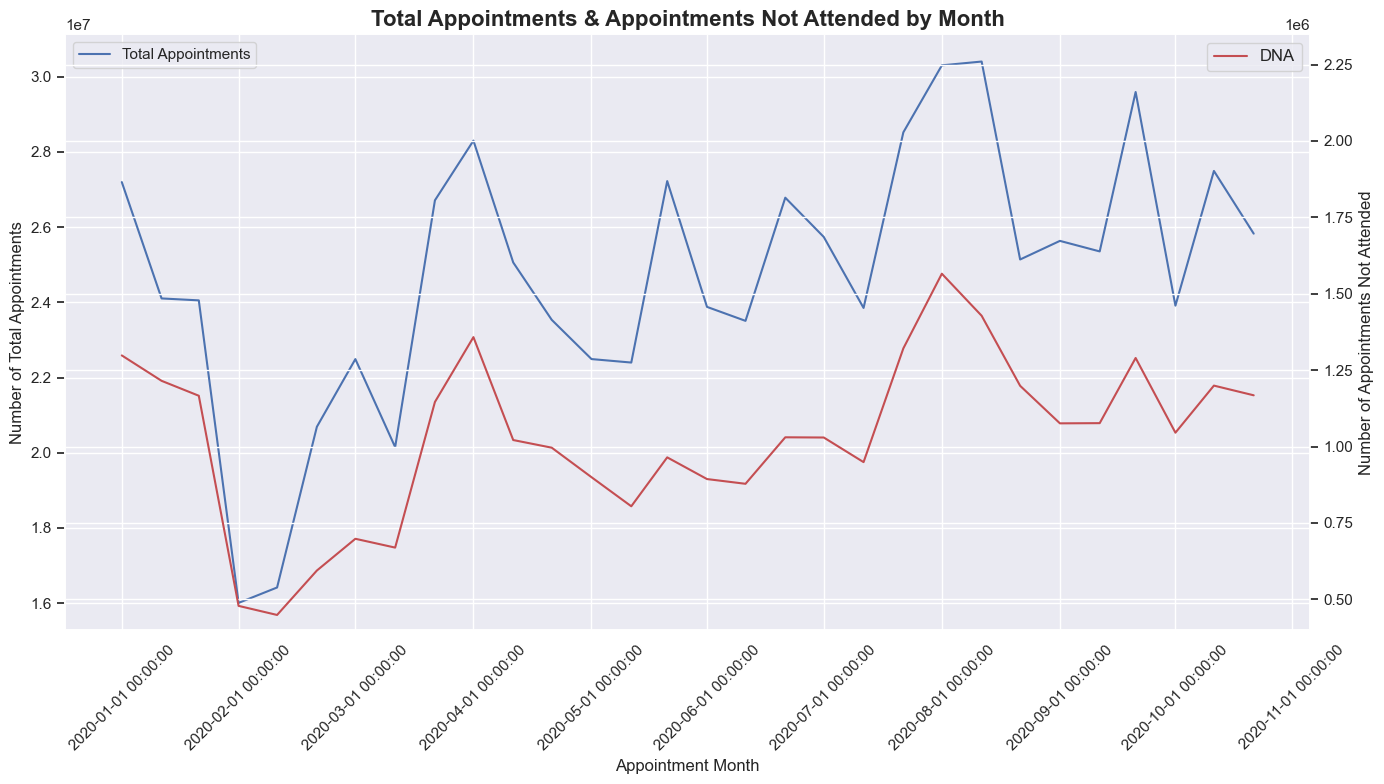

In [326]:
# Plot a graph to show the total number of appointments and the number of DNA per month.
# Use a chart with a secondary y-axis.

# Plot the number of total appointments.
sns.lineplot(x='appointment_month', y='total_appointments', data=ar_wd_as, label='Total Appointments', color='b')

# Show the legend.
plt.legend(loc='upper left')

# Create a secondary y-axis.
ax = plt.gca() 
ax2 = plt.gca().twinx()

# Plot the second line (Appointments Per Workday) on the secondary y-axis.
sns.lineplot(x='appointment_month', y='dna', data=ar_wd_as, label='DNA', color='r', ax=ax2)

# Adding titles and labels.
plt.title('Total Appointments & Appointments Not Attended by Month', fontsize=16, fontweight='bold')
ax.set_xlabel('Appointment Month')
ax.set_ylabel('Number of Total Appointments')
ax2.set_ylabel('Number of Appointments Not Attended')

# Set figure size & style for seaborn.
sns.set(rc={'figure.figsize':(14, 8)})
sns.set_theme(style='darkgrid')
plt.rcParams['axes.titlesize'] = 14    # Title font size for axes
plt.rcParams['axes.labelsize'] = 14    # Label font size for axes
plt.rcParams['legend.fontsize'] = 12   # Legend font size
plt.rcParams['xtick.labelsize'] = 12   # x-axis tick label size
plt.rcParams['ytick.labelsize'] = 12   # y-axis tick label size

# Rotate the x-axis labels using the Axes object.
ax.set_xticklabels(ar_wd_as['appointment_month'], rotation=45)
plt.ylim(400000, ar_wd_as['dna'].max() * 1.5)

# Show the legend.
plt.legend(loc='upper right')

# Save the plot.
plt.savefig('fig_appointment_dna', dpi=500, bbox_inches='tight')
    
# Show the plot.
plt.tight_layout()
plt.show()

> ***Observations*** <br>
> The number of appointments not attended is increasing.

### 5.3. Are there changes in terms of appointment type and the busiest months?

Use the appoinments_regional DataFrame (ar).

**5.3.1. Appointment Mode since August 2021**

In [332]:
# Create an aggregated data set to review appointment mode from August 2021 onwards.
ar_am_fil = ar_fil.groupby(['appointment_month', 'appointment_mode'])['count_of_appointments']. \
                            sum().reset_index()
# View the DataFrame.
ar_am_fil.head()

appointment_month appointment_mode  count_of_appointments
0           2021-08     Face-to-Face               13717325
1           2021-08       Home Visit                 151619
2           2021-08        Telephone                9149072
3           2021-08          Unknown                 724126
4           2021-08     Video/Online                 110029

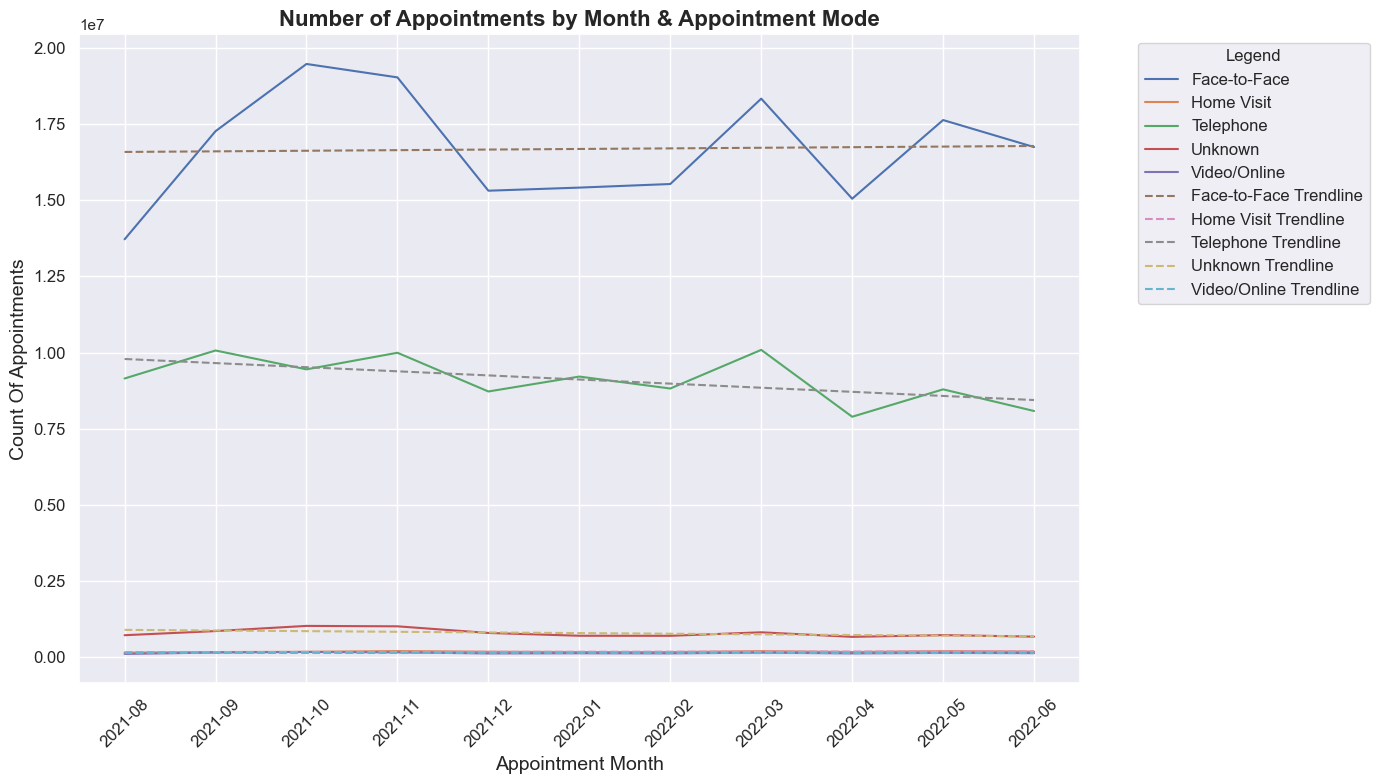

In [333]:
# Create a lineplot to show the number of appointments by appointment mode over time.
generate_multi_lineplot_with_trendline(ar_am_fil, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='appointment_mode', \
                                       title='Number of Appointments by Month & Appointment Mode', \
                                       save_path='fig_appointment_month_mode_2021')

**5.3.2. Appointment Mode since January 2020**

In [336]:
# Create an aggregated data set to review appointment mode.
ar_am = ar.groupby(['appointment_month', 'appointment_mode'])['count_of_appointments']. \
                            sum().reset_index()

# View the DataFrame.
ar_am.head()

appointment_month appointment_mode  count_of_appointments
0           2020-01     Face-to-Face               21733394
1           2020-01       Home Visit                 266942
2           2020-01        Telephone                3701775
3           2020-01          Unknown                1302979
4           2020-01     Video/Online                 194206

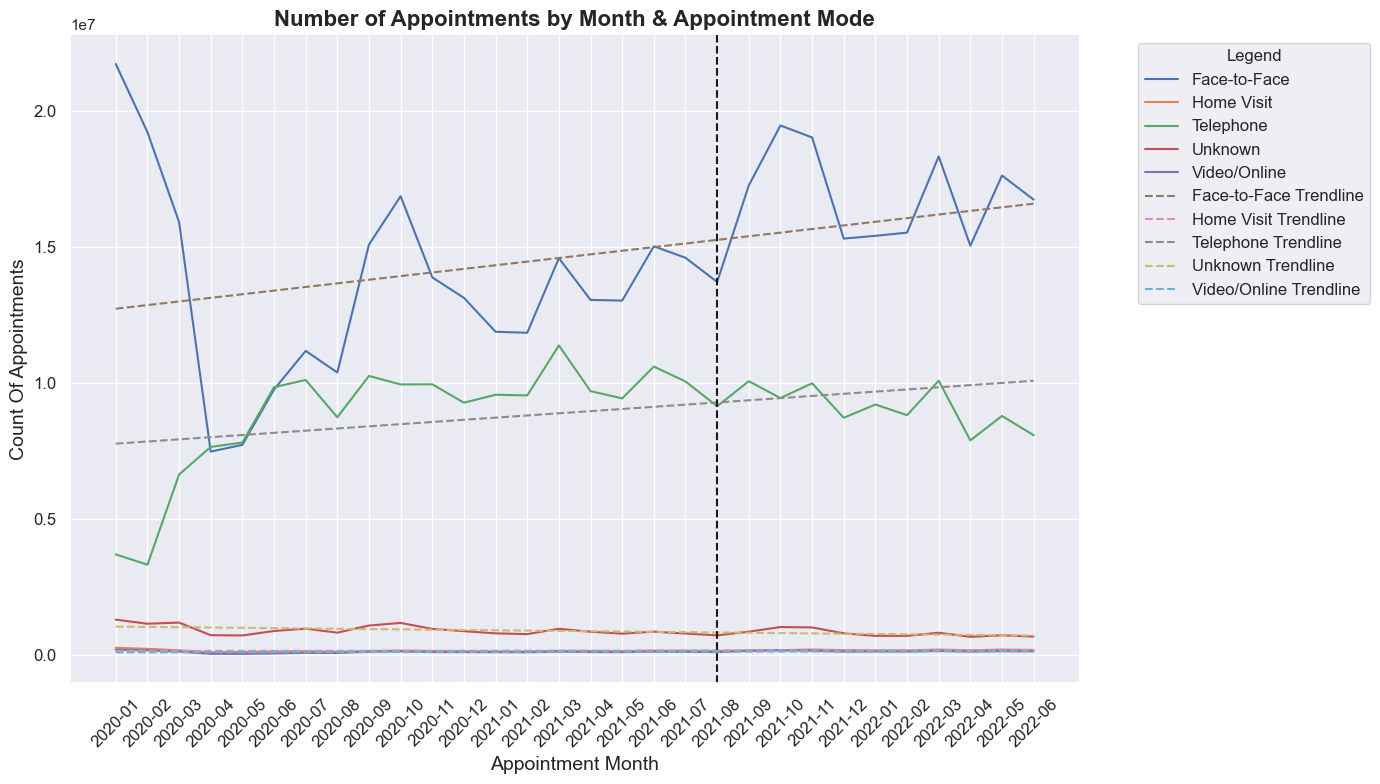

In [337]:
# Create a lineplot to show the number of appointments by appointment mode over time.
generate_multi_lineplot_with_trendline(ar_am, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='appointment_mode', date='2021-08', \
                                       title='Number of Appointments by Month & Appointment Mode', \
                                       save_path='fig_appointment_month_mode')

> ***Observations*** <br>
> The number of telephone appointments had an upward trend, but is starting to decrease.

### 5.4. Are there any trends in time between booking an appointment?

Use the appoinments_regional DataFrame (ar).

In [342]:
# Determine the total number of appointments per month.
ar_bt = ar.groupby(['appointment_month', 'book_time'])['count_of_appointments']. \
                            sum().reset_index()

ar_bt.head()

appointment_month       book_time  count_of_appointments
0           2020-01           1 Day                1945711
1           2020-01  15  to 21 Days                1881819
2           2020-01     2 to 7 Days                5604909
3           2020-01  22  to 28 Days                1313557
4           2020-01   8  to 14 Days                3444637

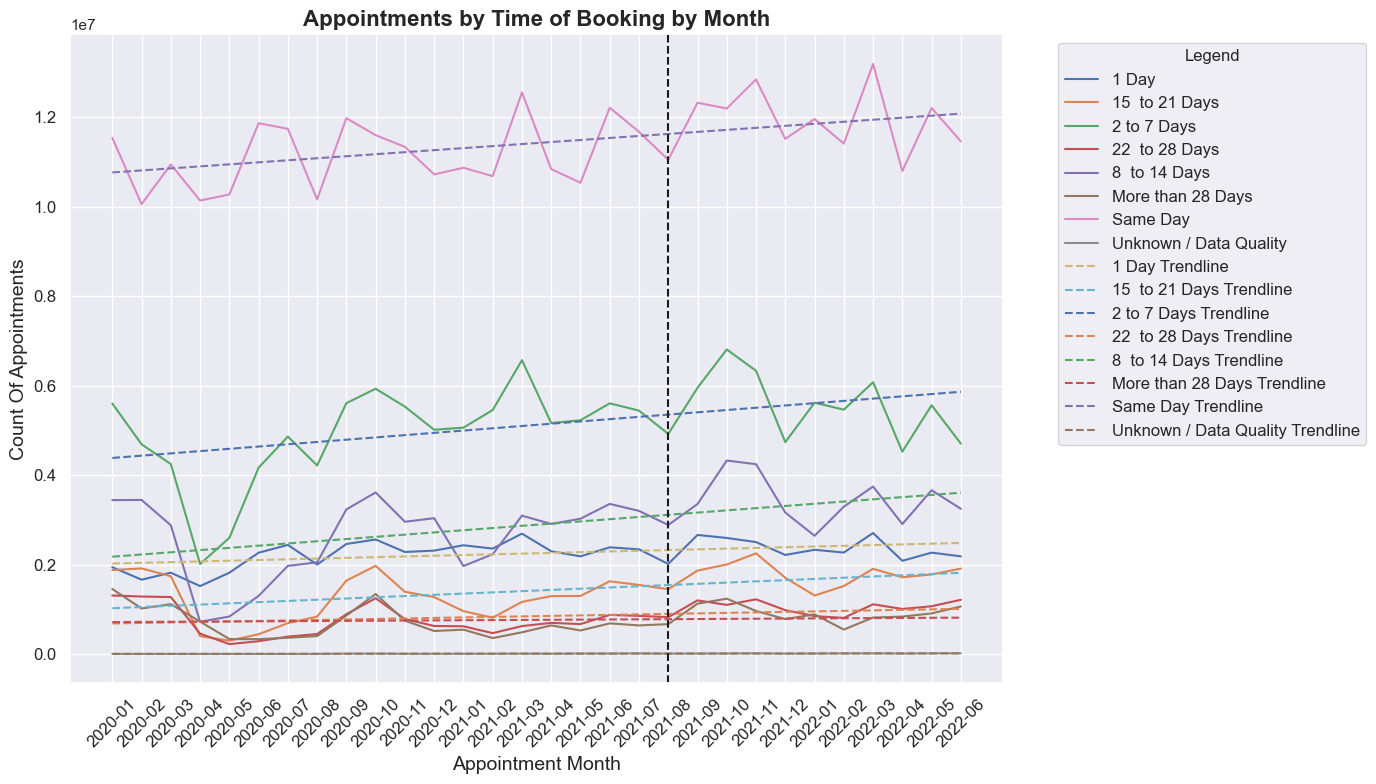

In [343]:
# Create lineplot showing service settings over time.
generate_multi_lineplot_with_trendline(ar_bt, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='book_time', date='2021-08', \
                                       title='Appointments by Time of Booking by Month', \
                                       save_path='fig_appointment_book_time_trend')

> ***Observations*** <br>
> Most appointments are booked for the same day and the number is increasing.

### 5.5. How do the healthcare professional (hcp) types differ over time?

Use the appoinments_regional DataFrame (ar).

**5.5.1. HCP type since August 2021**

In [349]:
# Create an aggregated data set to review hcp type.
ar_hcp_fil = ar_fil.groupby(['appointment_month', 'hcp_type'])['count_of_appointments']. \
                            sum().reset_index()
# View the DataFrame.
ar_hcp_fil.head()

appointment_month              hcp_type  count_of_appointments
0           2021-08                    GP               12299022
1           2021-08  Other Practice staff               10797821
2           2021-08               Unknown                 755328
3           2021-09                    GP               14487785
4           2021-09  Other Practice staff               13126731

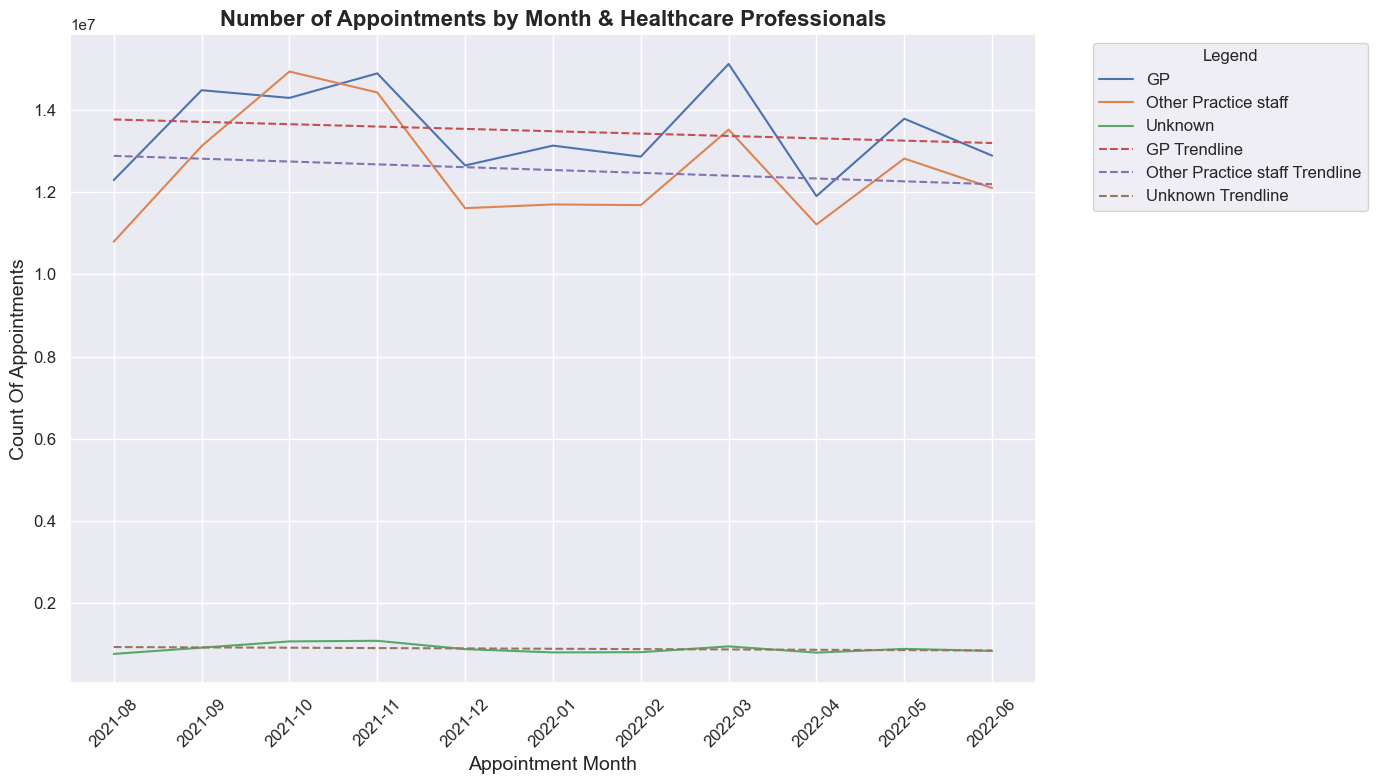

In [350]:
# Create a lineplot to show the number of appointments with different healthcare professionals over time.
generate_multi_lineplot_with_trendline(ar_hcp_fil, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='hcp_type', title='Number of Appointments by Month & Healthcare Professionals', \
                                       save_path='fig_appointment_month_hcp_2021')

**5.5.2. HCP type since January 2020**

In [353]:
# Create an aggregated data set to review hcp type using data from 2020-01 onwards.
ar_hcp = ar.groupby(['appointment_month', 'hcp_type'])['count_of_appointments']. \
                            sum().reset_index()
# View the DataFrame.
ar_hcp

appointment_month              hcp_type  count_of_appointments
0            2020-01                    GP               14168932
1            2020-01  Other Practice staff               12326031
2            2020-01               Unknown                 704333
3            2020-02                    GP               12467976
4            2020-02  Other Practice staff               11002550
..               ...                   ...                    ...
85           2022-05  Other Practice staff               12823200
86           2022-05               Unknown                 878374
87           2022-06                    GP               12893983
88           2022-06  Other Practice staff               12105677
89           2022-06               Unknown                 828418

[90 rows x 3 columns]

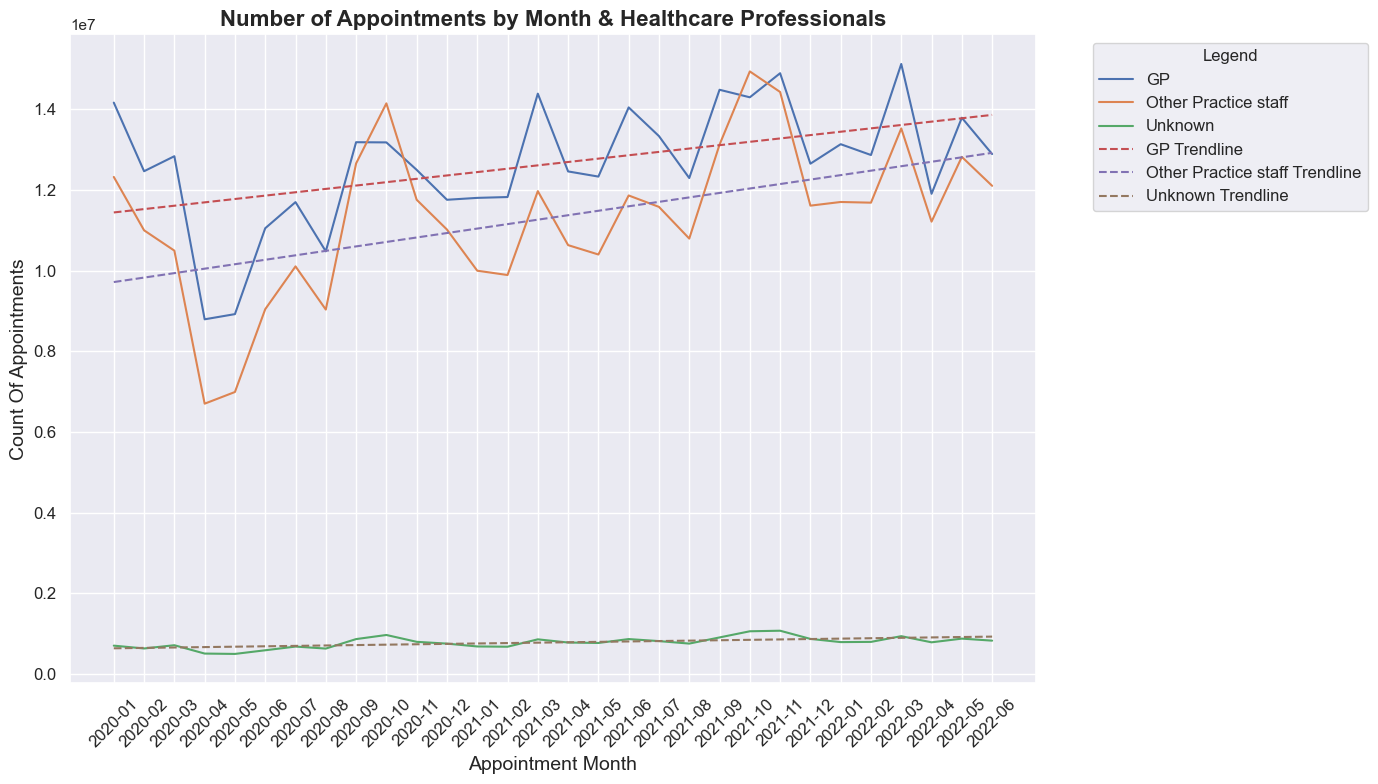

In [354]:
# Create a lineplot to show the number of appointments with different healthcare professionals over time.
generate_multi_lineplot_with_trendline(ar_hcp, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='hcp_type', \
                                       title='Number of Appointments by Month & Healthcare Professionals', \
                                      save_path='fig_appointment_month_hcp')

**5.5.3. Appointment Mode by Healthcare Professional**

In [357]:
# Group and pivot filtered appointments_regional by month and ICB.
ar_am_pivot= ar.pivot_table(index=['hcp_type'], columns='appointment_mode', 
                                      values='count_of_appointments',  aggfunc='sum')

# Add a column for the sum of total appointments.
ar_am_pivot['total_appointments'] = ar_am_pivot[['Face-to-Face', 'Home Visit', 'Telephone', 'Unknown', 'Video/Online']].sum(axis=1)

# View the DataFrame.
ar_am_pivot.head()

appointment_mode      Face-to-Face  Home Visit  Telephone   Unknown  \
hcp_type                                                              
GP                       180917227     1925253  189058386   5875990   
Other Practice staff     254425532     2222504   74344841   6915753   
Unknown                    4638970      740119    4459430  13659562   

appointment_mode      Video/Online  total_appointments  
hcp_type                                                
GP                         1873284           379650140  
Other Practice staff       1741905           339650535  
Unknown                       5769            23503850

In [358]:
# Group and pivot filtered appointments_regional by month and ICB.
ar_fil_am_pivot= ar_fil.pivot_table(index=['hcp_type'], columns='appointment_mode', 
                                      values='count_of_appointments',  aggfunc='sum')

# View the DataFrame.
ar_fil_am_pivot.head()

appointment_mode      Face-to-Face  Home Visit  Telephone  Unknown  \
hcp_type                                                             
GP                        75169895      826812   70168817  1476807   
Other Practice staff     106423082      898332   28352412  1497993   
Unknown                    1910610      266000    1753652  5758861   

appointment_mode      Video/Online  
hcp_type                            
GP                          729111  
Other Practice staff        810954  
Unknown                       3432

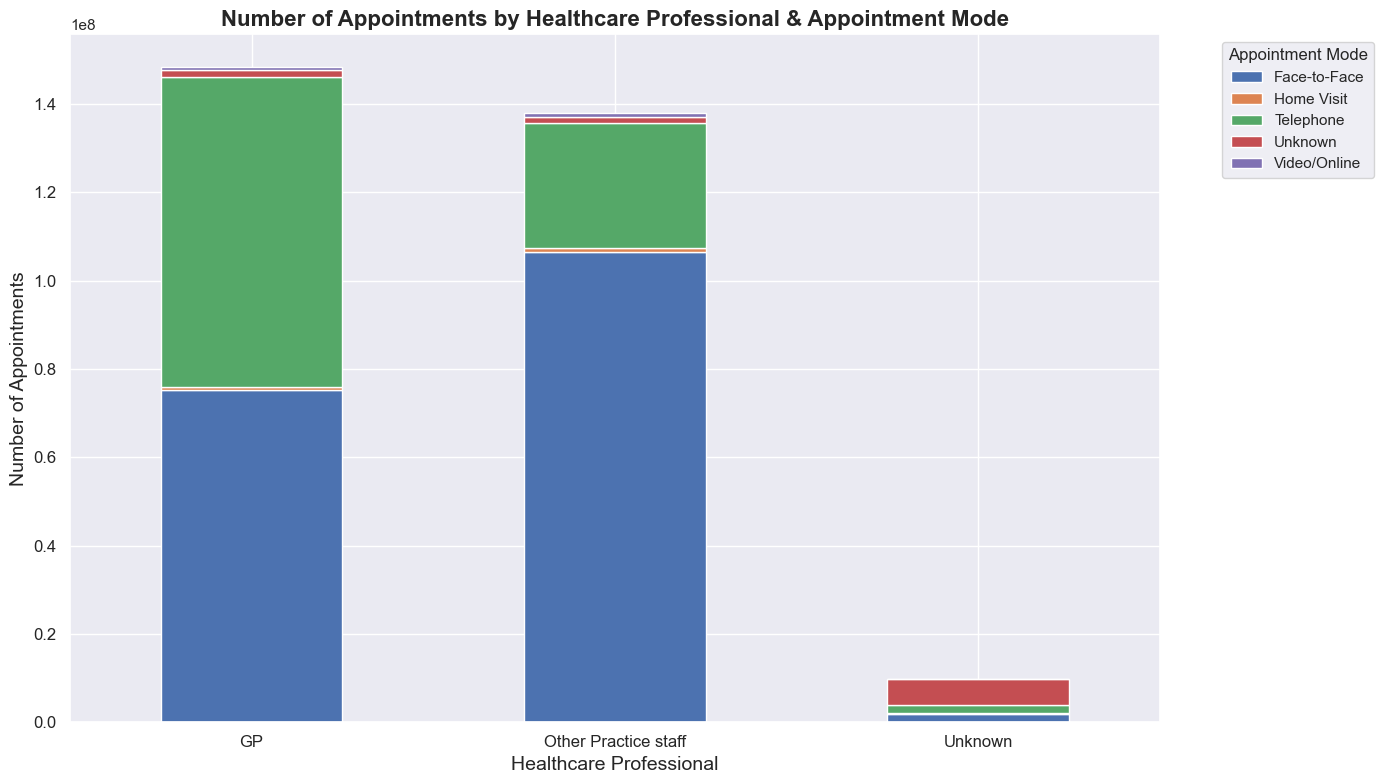

In [359]:
# Create a stacked bar plot to show appointment mode by healthcare professional.

# Set figure size & style for seaborn.
sns.set_theme(style='darkgrid')
sns.set(rc={'figure.figsize':(14, 8)})

# Plot the barplot.
ar_fil_am_pivot.plot(kind = 'bar', stacked = True)

# Adding titles and labels.
plt.title('Number of Appointments by Healthcare Professional & Appointment Mode', fontsize=16, fontweight='bold')
plt.xlabel('Healthcare Professional', fontsize=14)
plt.ylabel('Number of Appointments', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend (title='Appointment Mode', bbox_to_anchor=(1.05,1), loc='upper left')

# Rotate x-tick labels by 45 degrees
plt.xticks(rotation=0)

# Save the plot.
plt.savefig('fig_appointment_hcp_mode', dpi=500, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

In [360]:
# Create an aggregated data set to review hcp type using data from 2020-01 onwards.
ar_hcp_mode = ar.groupby(['appointment_month', 'hcp_type', 'appointment_mode'])['count_of_appointments']. \
                            sum().reset_index()
# View the DataFrame.
ar_hcp_mode

appointment_month hcp_type appointment_mode  count_of_appointments
0             2020-01       GP     Face-to-Face               10879889
1             2020-01       GP       Home Visit                 111549
2             2020-01       GP        Telephone                2621975
3             2020-01       GP          Unknown                 416439
4             2020-01       GP     Video/Online                 139080
..                ...      ...              ...                    ...
443           2022-06  Unknown     Face-to-Face                 172598
444           2022-06  Unknown       Home Visit                  22384
445           2022-06  Unknown        Telephone                 150172
446           2022-06  Unknown          Unknown                 482875
447           2022-06  Unknown     Video/Online                    389

[448 rows x 4 columns]

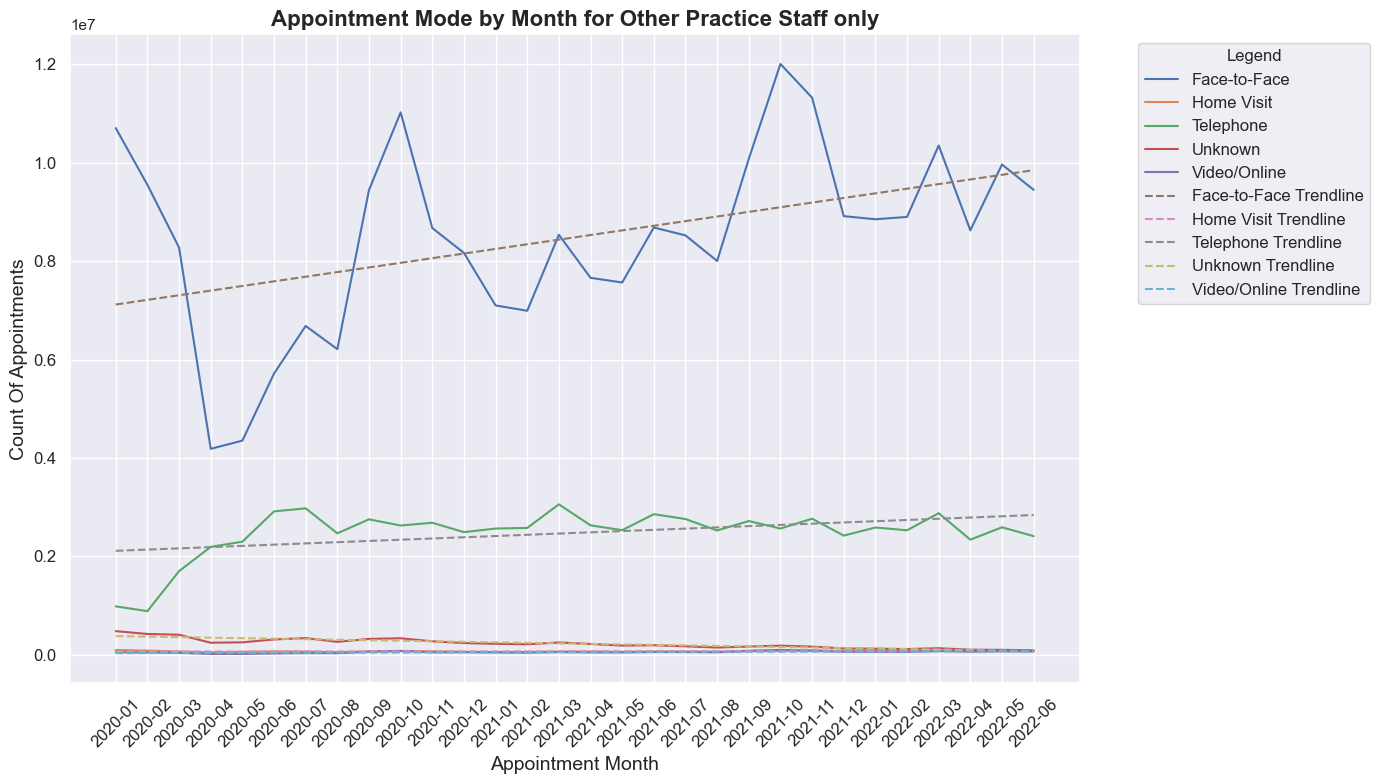

In [361]:
# Only show chart for certain national categories due to scale.
ar_ops_mode = ar_hcp_mode[ar_hcp_mode['hcp_type'].isin(['Other Practice staff'])]

# Create lineplot showing the specific service settings over time.
generate_multi_lineplot_with_trendline(ar_ops_mode, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='appointment_mode', title='Appointment Mode by Month for Other Practice Staff only')

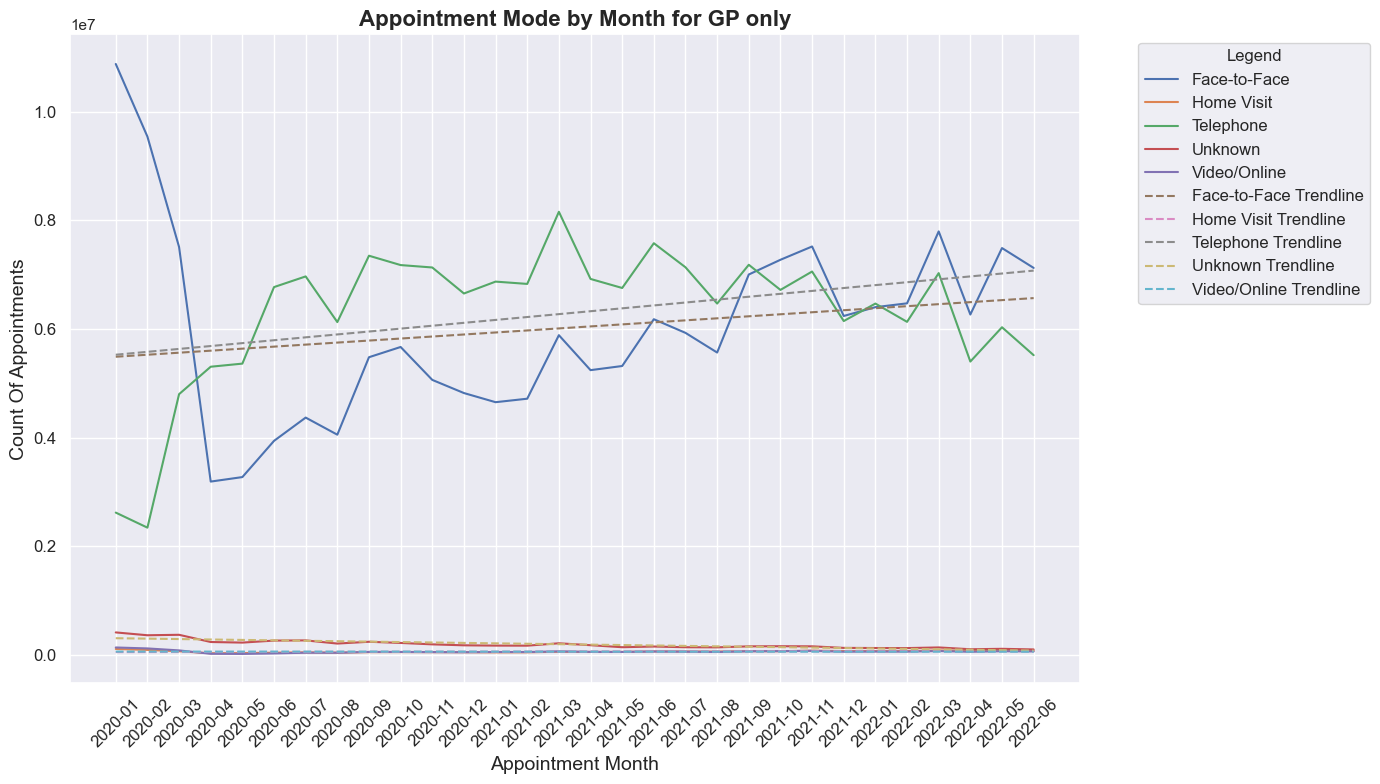

In [362]:
# Only show chart for certain national categories due to scale.
ar_gp_mode = ar_hcp_mode[ar_hcp_mode['hcp_type'].isin(['GP'])]

# Create lineplot showing the specific service settings over time.
generate_multi_lineplot_with_trendline(ar_gp_mode, x_axis='appointment_month', y_axis='count_of_appointments', \
                                       hue='appointment_mode', title='Appointment Mode by Month for GP only')

> ***Observations*** <br>
> - After increasing since 2020, the total number of appointments is starting to level out.
> - In peak months other practice staff carry out more of the appointments.
> - Other Practice Staff take a higher share of appointments Face-to-Face, while GPs take more Telephone appointments than the Other Practice Staff.

### 5.6. Summary of Findings & Recommendations

### Observations

**Data Quality**
There are variations in completeness & quality:
- different practices fill in their records in different ways
- staff manually classifies the data
- different IT system suppliers

**Seasonality**
Main peaks are in October and March, which is already known as 'winter pressure'.

**Patient & GP Numbers** <br>
Between 2021-08 and 2022-06
- the number of appointments per patient is decreasing
- the number of patients is increasing
- the number of fully qualified GPs has remained relatively constant (-1%)
- the number of GPs in training has decreased (-9%), so that the number of all GPs has reduced by almost -3% <br>
**Result**: the number of patients per GP is increasing, reducing availability to GPs.

**Did not Attend (DNA)** - Apintments not attended <br>
- The data shows a correlation between the number of appointments per patient and the share of DNA, meaning greater availability of appointments per patient reduces the share of DNA.
- 53% of appointments are booked for the same day or the day after. The further in advance an appointment is booked, the higher the share of DNA.
- Face-to-Face appointments have the highest share of DNA, while Telephone appointments have the lowest.
- The share of DNA for appointments with Other Practice Staff is higher than for GPs.

**Appointment Duration** Almost 69% of appointments take less than 15 minutes.

**Tweets**<br>
- #healthcare, #health, #job, #strategy and #pharmaceutical are the top 5 trending hashtags. <br>
- The #job suggests that X can be used to advertise jobs.

### Trends
- Utilisation Rate > 1 means there is more demand than average monthly capacity.
- The number of appointments not attended is increasing.
- The number of telephone appointments had an upward trend, but is starting to decrease.
- Most appointments are booked for the same day and the number is increasing.
- In peak months other practice staff carry out more of the appointments.
- Other Practice Staff take a higher share of appointments Face-to-Face, while GPs take more Telephone appointments than the Other Practice Staff.

### Recommendations

The trends suggsest that more staff & capacity is needed in the networks. <br>
If due to budget constraints, hiring more staff is not an option, action can be taken to improve availaibility with current staff levels.

**Better data = better decisions**
- Introduce national standards for data entry
- Provide training & support for practice staff on data entry
- Start with Sub-ICBS with greatest quality issues

**Increase availability by using resources more effectively**
- Increase appointments carried out by Other Practice Staff, as in peak months

**Increase availability by reducing ‘Did not Attend’ by**
- raising awareness via social media of the cost of appointments not attended to patients  
- expanding digitalisation, such as the NHS app, to book & cancel appointments & access health data to reduce pressure on practice staff